<a href="https://colab.research.google.com/github/RVasconcelosMiguel/PerceptionMapping/blob/main/PMT3_versao_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = np.loadtxt('/content/data_slam.txt')

# Extract sections of the data
pose_data = data[:, :3]  # Pose variations: Δx, Δy, Δtheta
lidar_data = data[:, 3:]   # LIDAR measurements

# Parameters for LIDAR
angles = np.deg2rad(np.linspace(-30, 30, 61))  # Angles from -30° to 30°


Corner Types: []

Corner Angles (rad): []


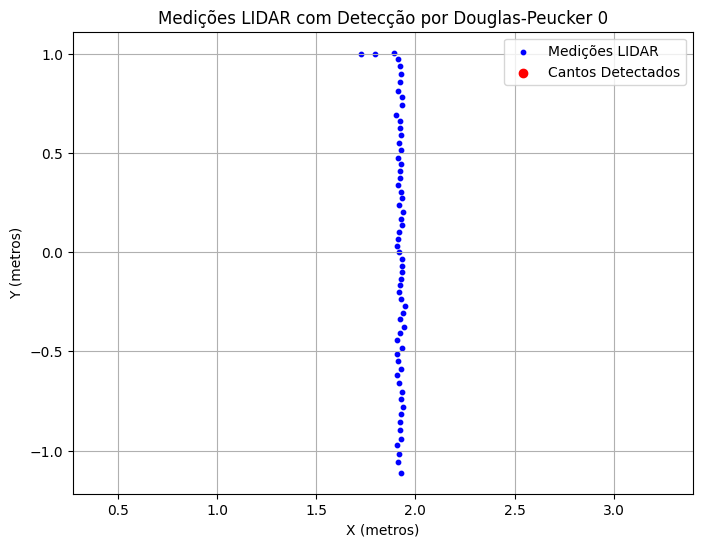


Corner Types: []

Corner Angles (rad): []


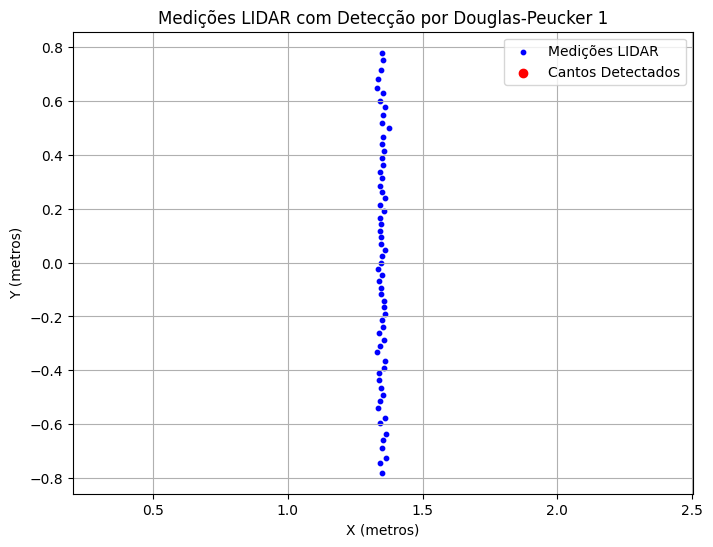


Corner Types: []

Corner Angles (rad): []


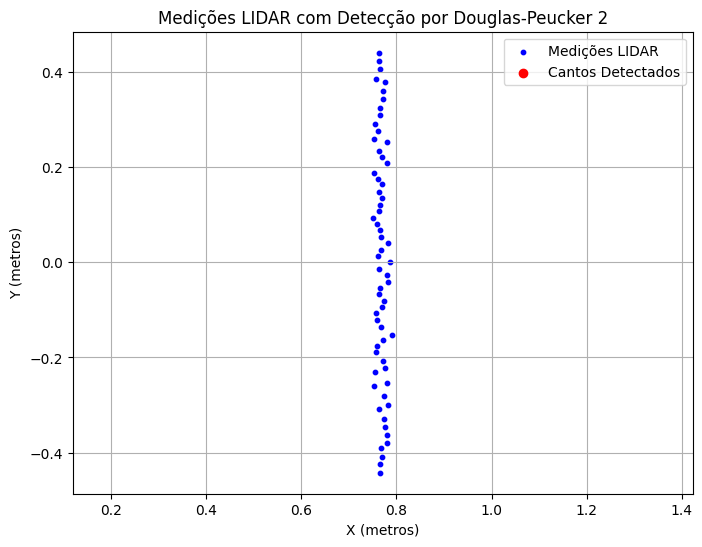


Corner Types: []

Corner Angles (rad): []


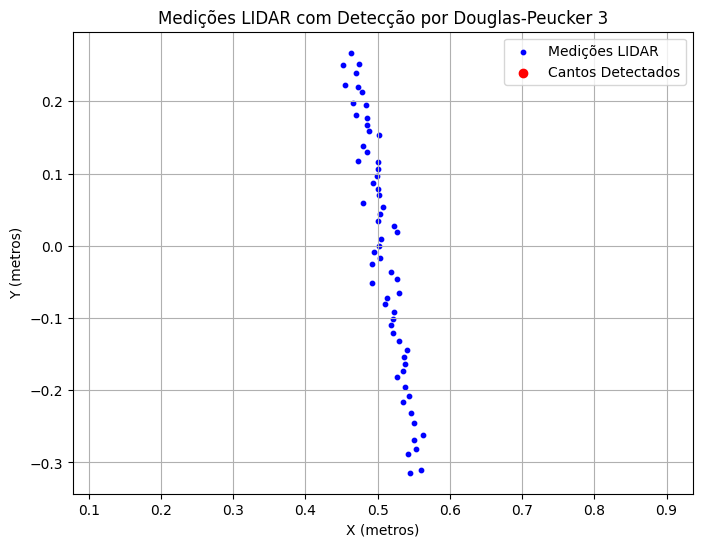


Corner Types: []

Corner Angles (rad): []


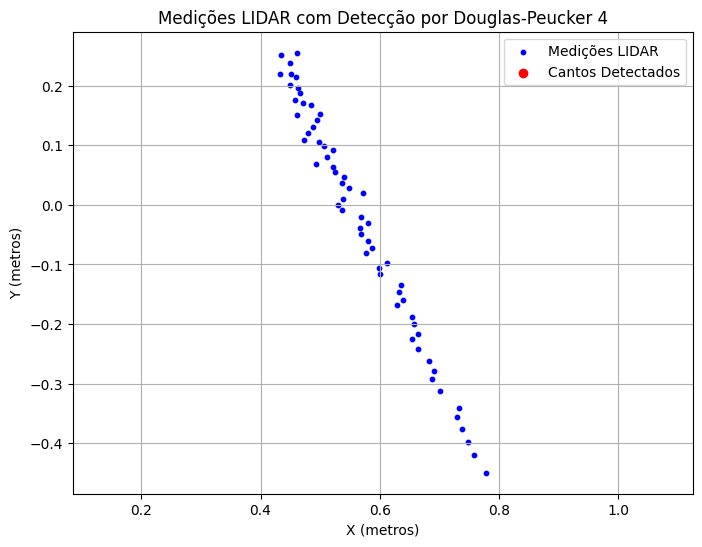


Corner Types: []

Corner Angles (rad): []


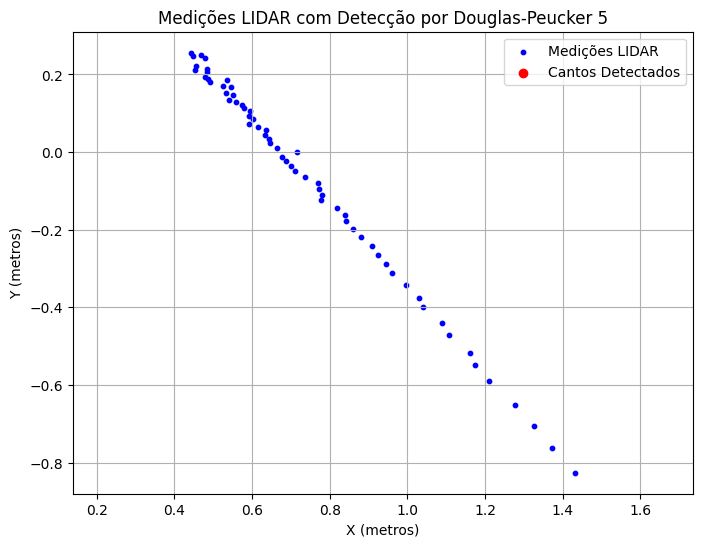


Corner Types: [1]

Corner Angles (rad): [-2.8576213471588034]


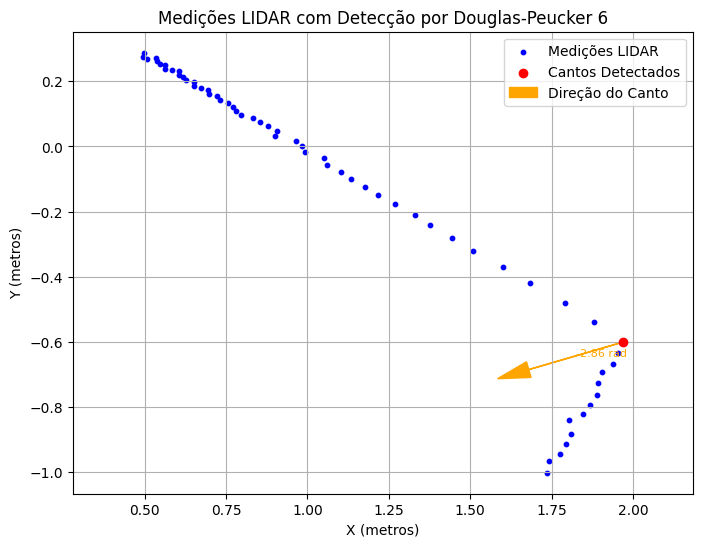


Corner Types: [1]

Corner Angles (rad): [-2.585869835571658]


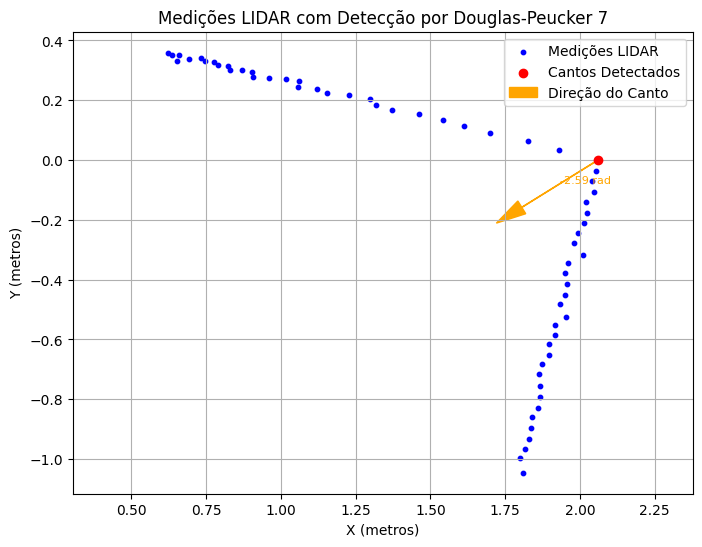


Corner Types: [1]

Corner Angles (rad): [-2.465587246953546]


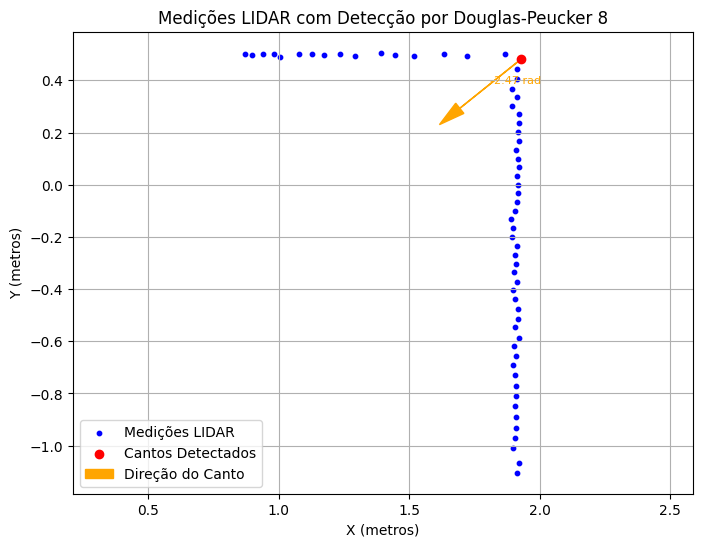


Corner Types: [1]

Corner Angles (rad): [-2.4499420700554544]


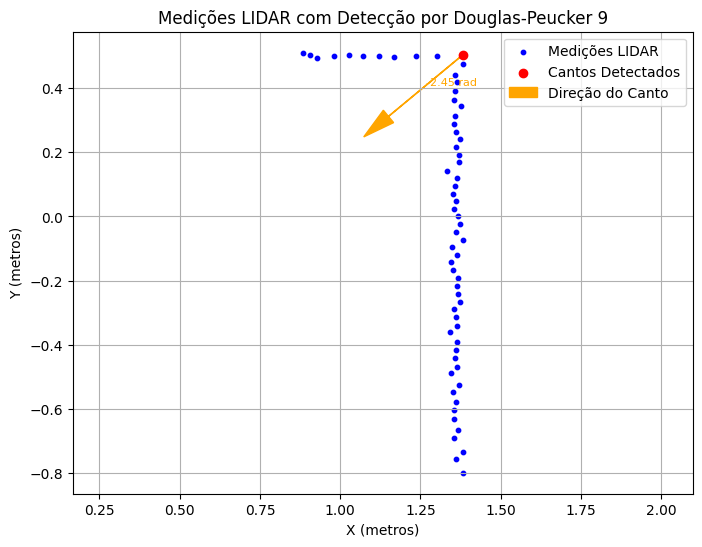


Corner Types: []

Corner Angles (rad): []


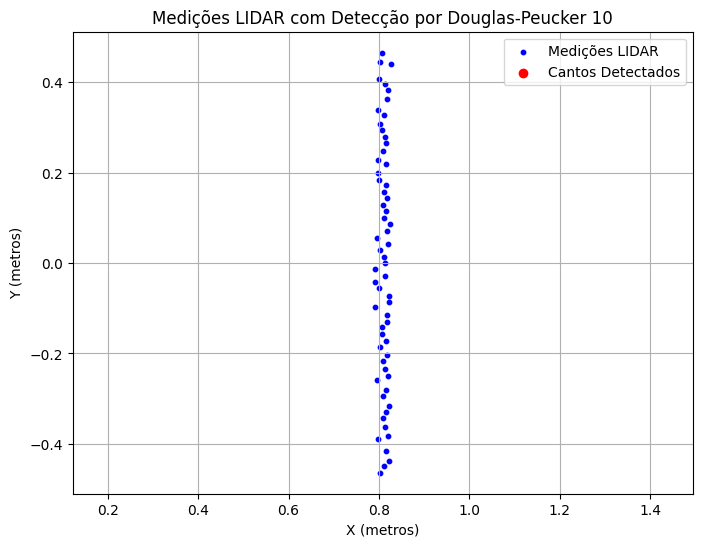


Corner Types: []

Corner Angles (rad): []


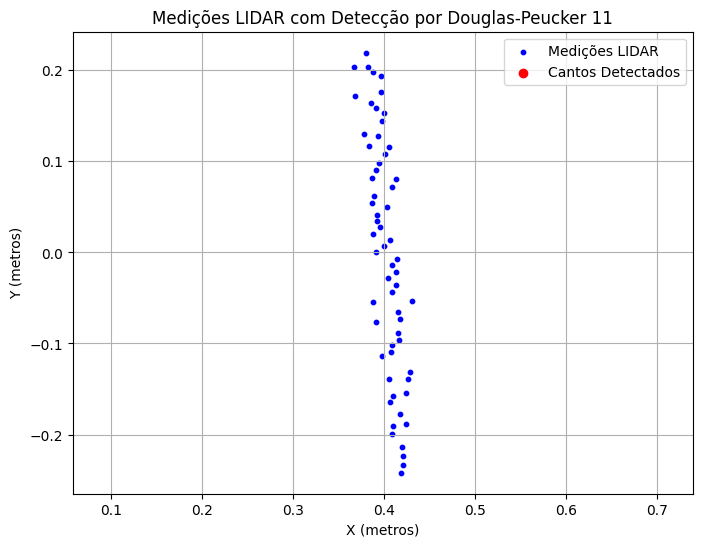


Corner Types: []

Corner Angles (rad): []


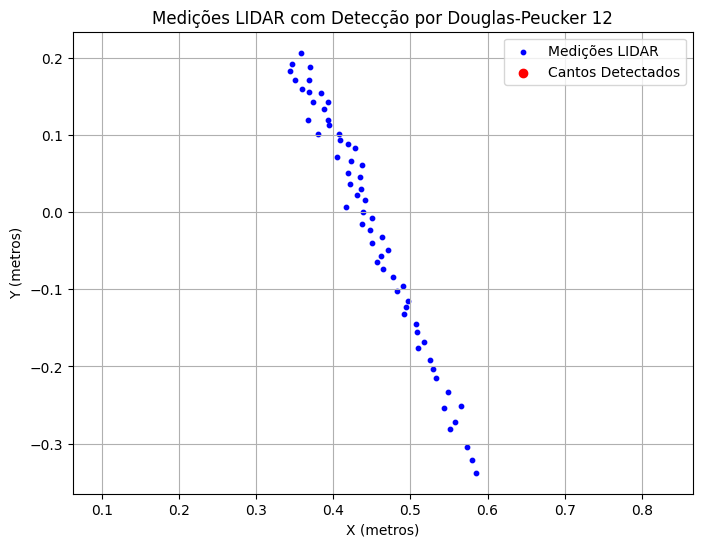


Corner Types: []

Corner Angles (rad): []


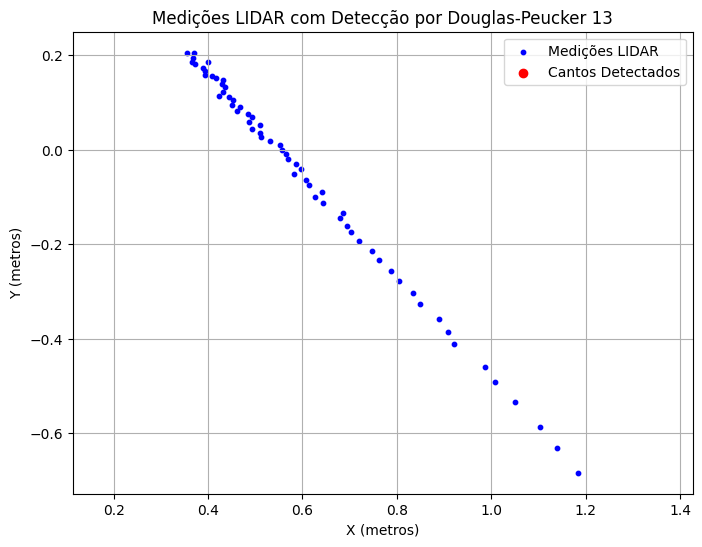


Corner Types: []

Corner Angles (rad): []


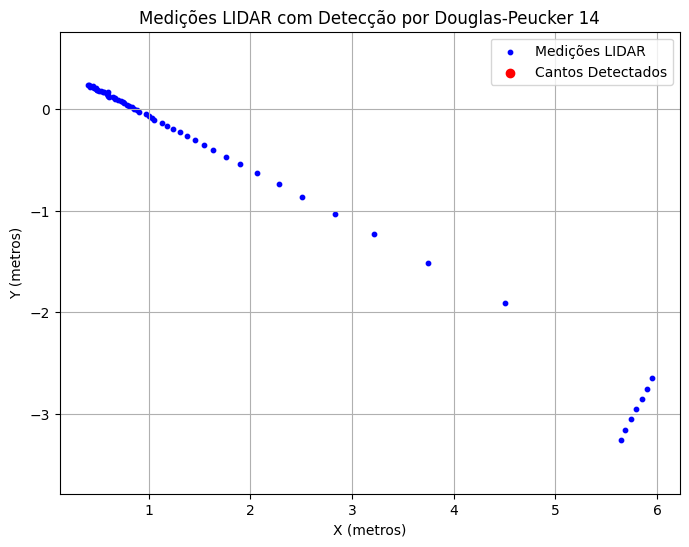


Corner Types: [1]

Corner Angles (rad): [-0.9444347851274075]


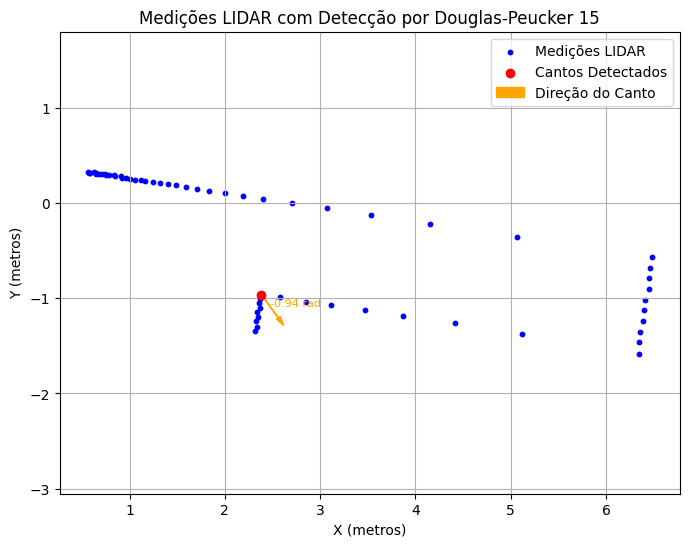


Corner Types: [0]

Corner Angles (rad): [-0.8383794625027492]


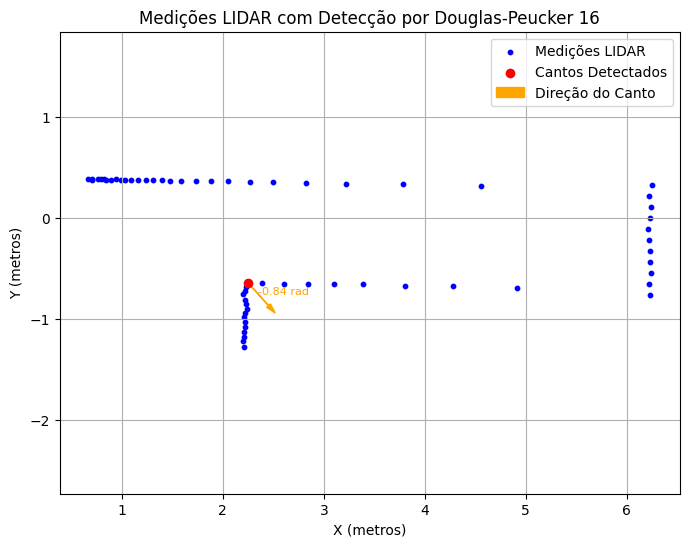


Corner Types: [1, 0]

Corner Angles (rad): [-1.0472572665910815, 2.3390307608186953]


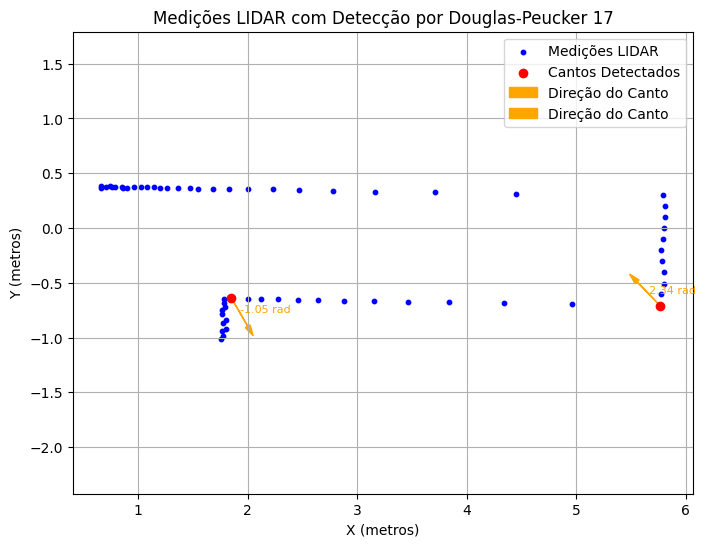


Corner Types: []

Corner Angles (rad): []


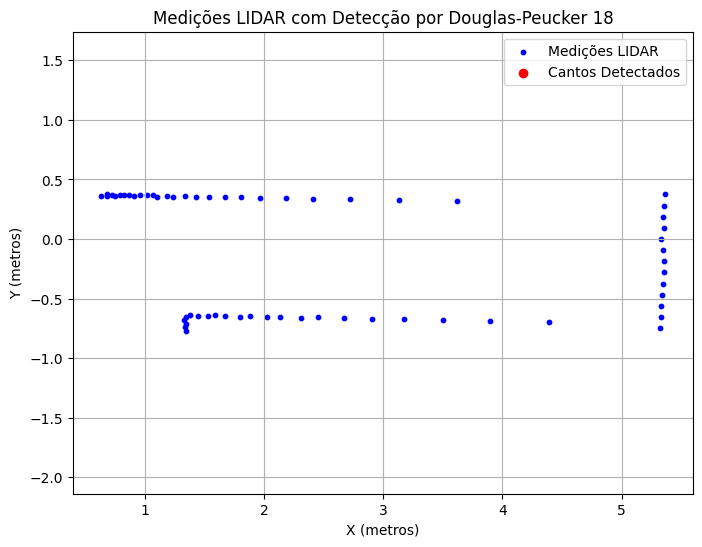


Corner Types: []

Corner Angles (rad): []


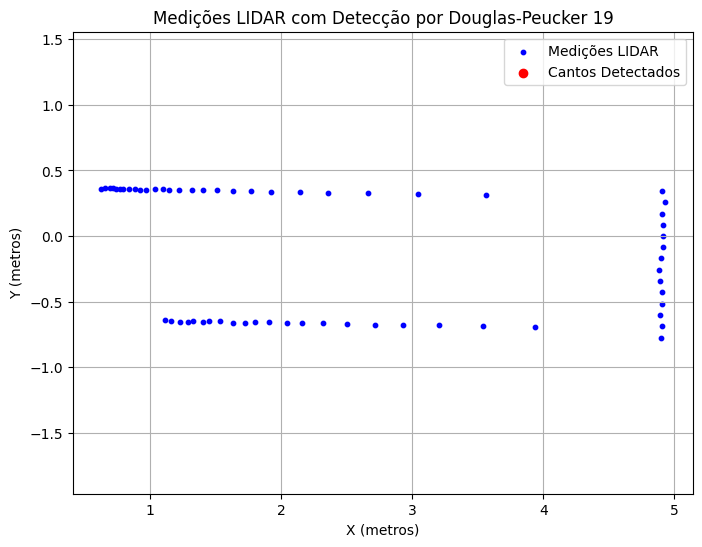


Corner Types: []

Corner Angles (rad): []


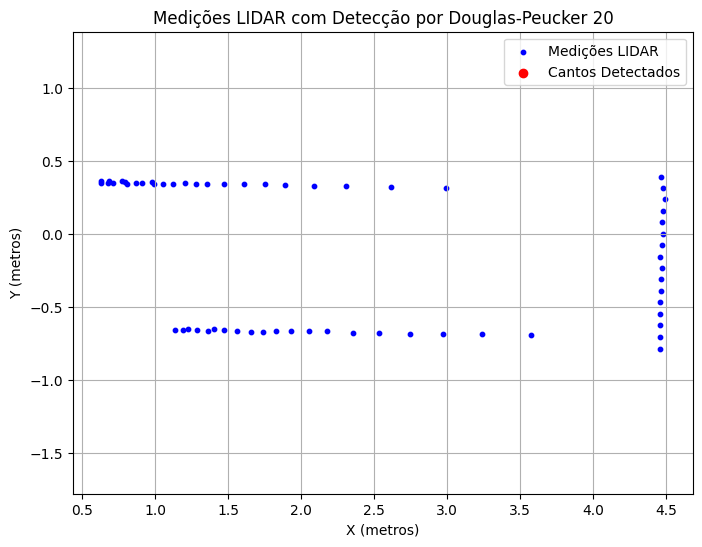


Corner Types: []

Corner Angles (rad): []


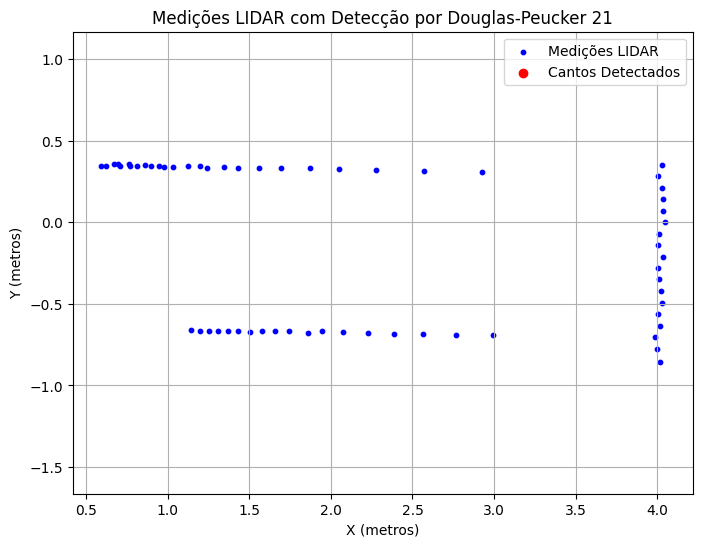


Corner Types: []

Corner Angles (rad): []


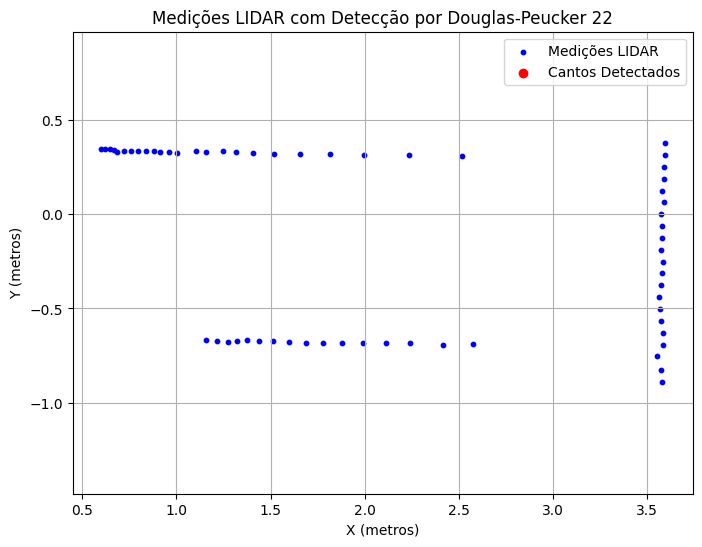


Corner Types: []

Corner Angles (rad): []


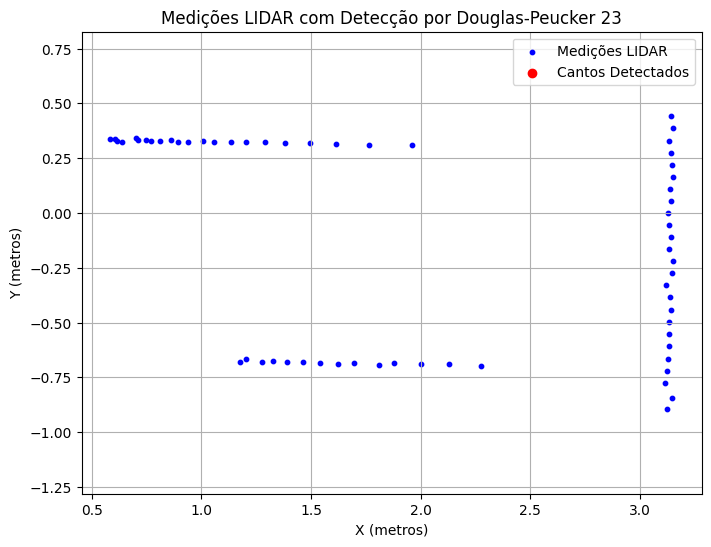


Corner Types: []

Corner Angles (rad): []


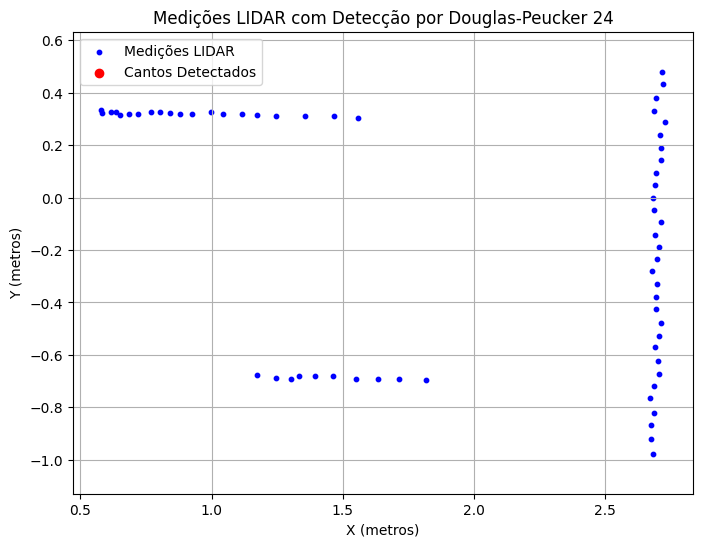


Corner Types: []

Corner Angles (rad): []


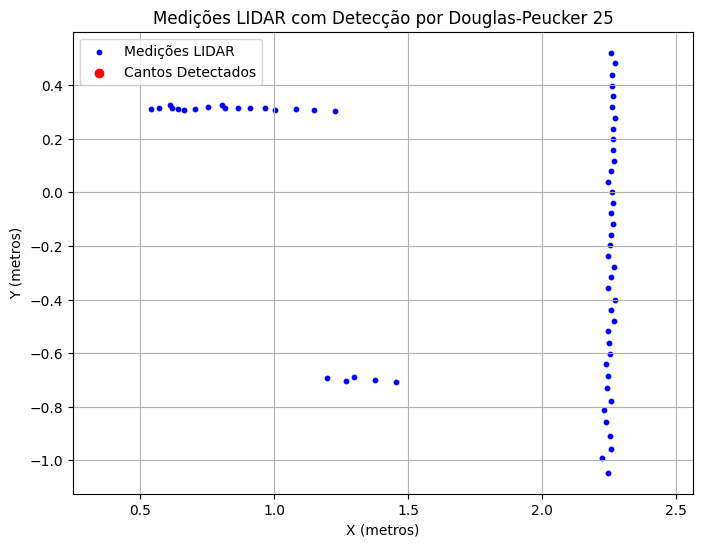


Corner Types: []

Corner Angles (rad): []


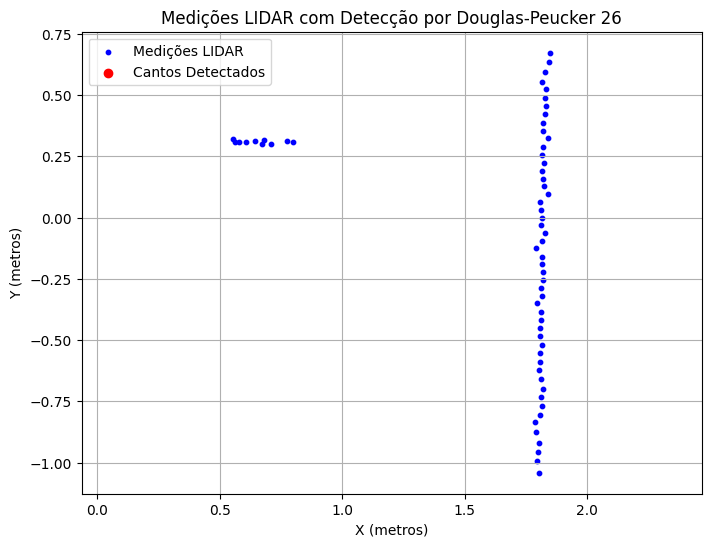


Corner Types: []

Corner Angles (rad): []


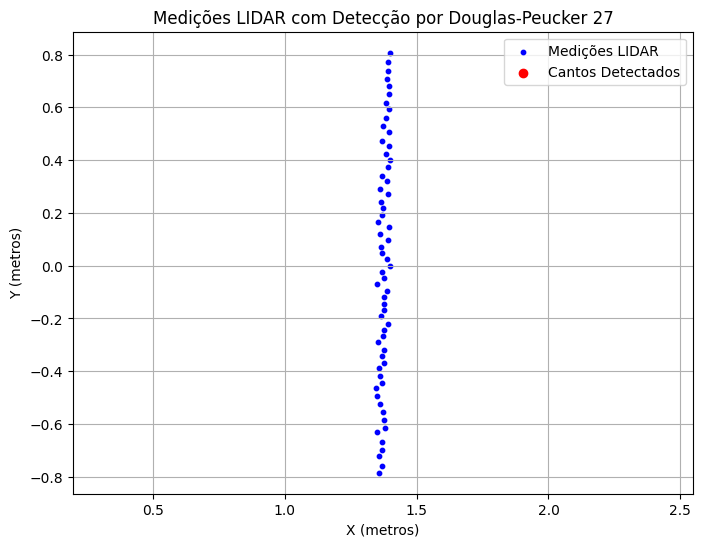


Corner Types: []

Corner Angles (rad): []


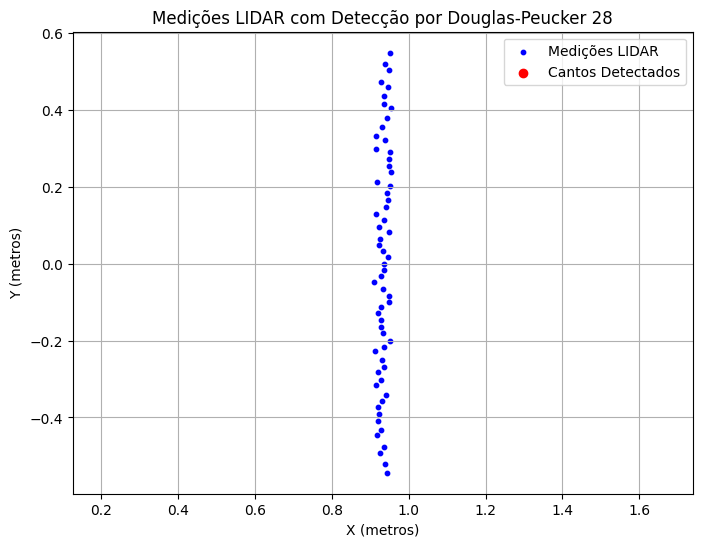


Corner Types: []

Corner Angles (rad): []


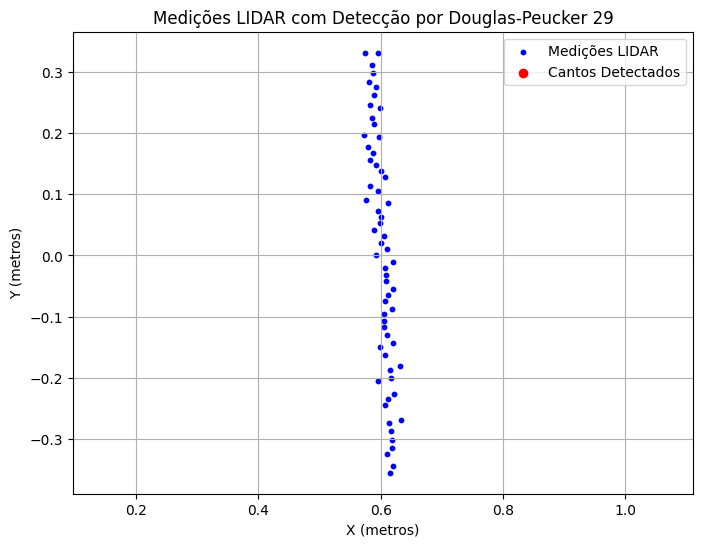


Corner Types: []

Corner Angles (rad): []


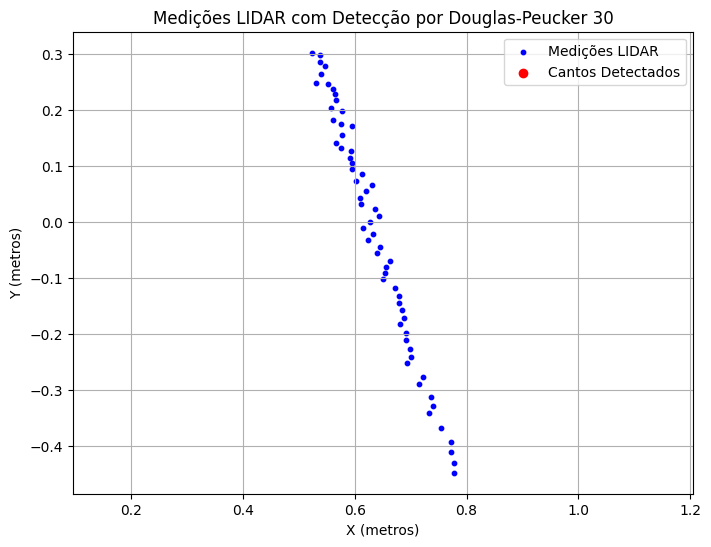


Corner Types: []

Corner Angles (rad): []


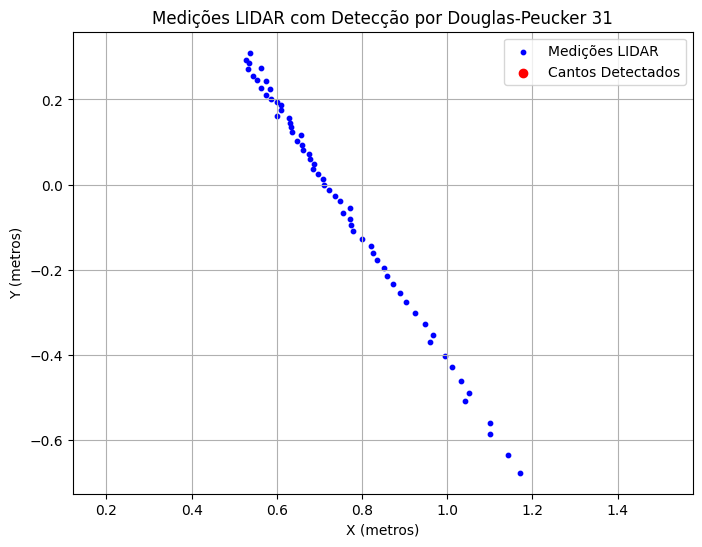


Corner Types: []

Corner Angles (rad): []


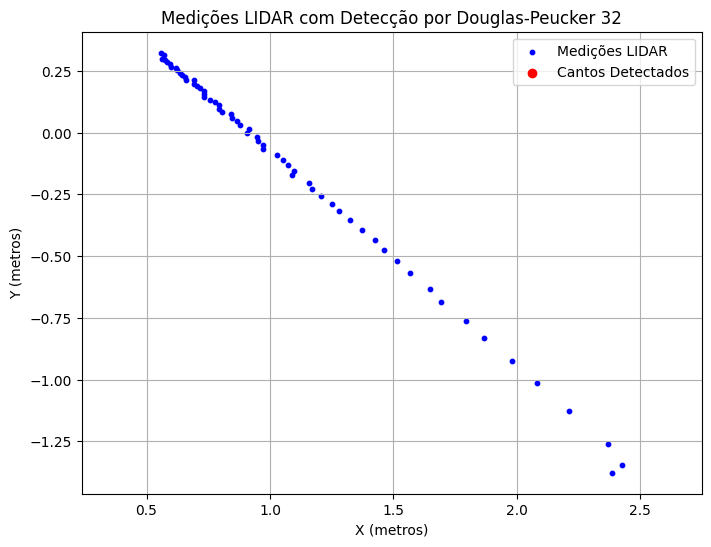


Corner Types: [1]

Corner Angles (rad): [-2.8186277243185054]


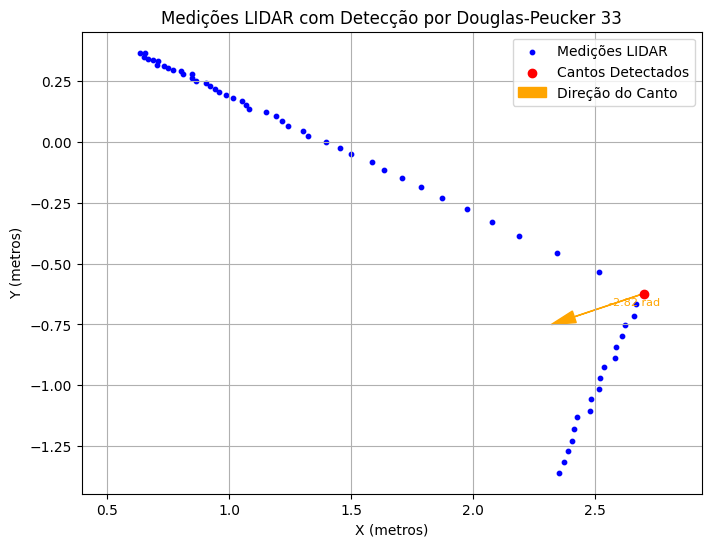


Corner Types: [1]

Corner Angles (rad): [-2.504187668983787]


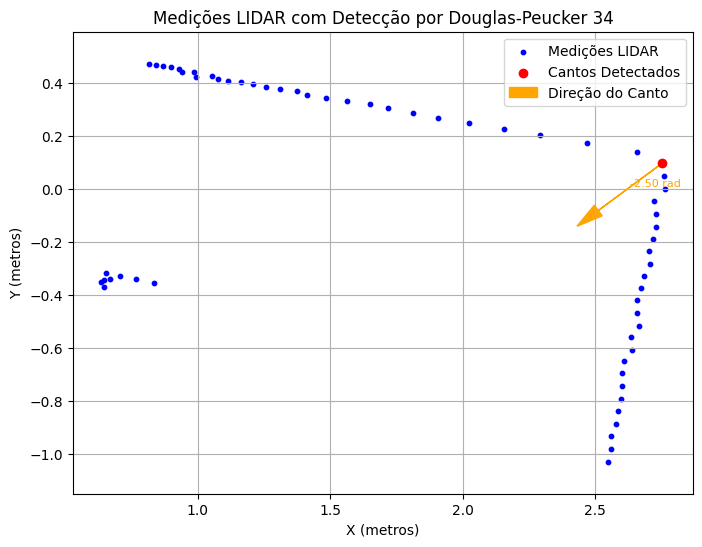


Corner Types: [1]

Corner Angles (rad): [-2.3944300776649325]


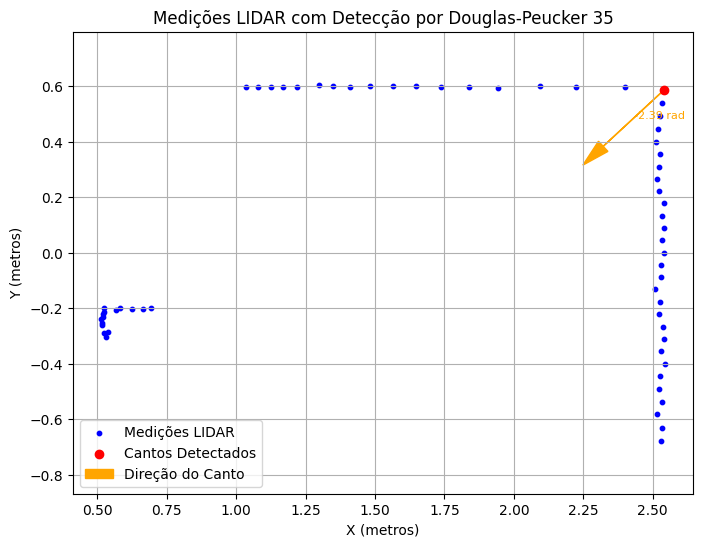


Corner Types: [1]

Corner Angles (rad): [-2.406619272734792]


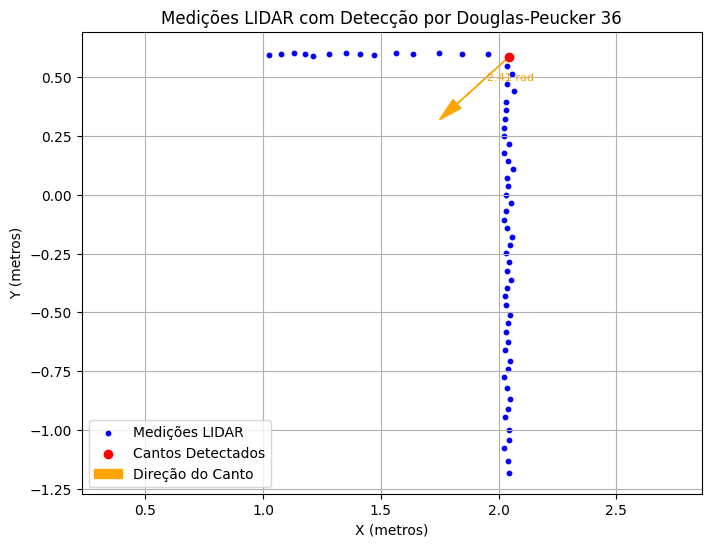


Corner Types: [1]

Corner Angles (rad): [-2.3680943199281925]


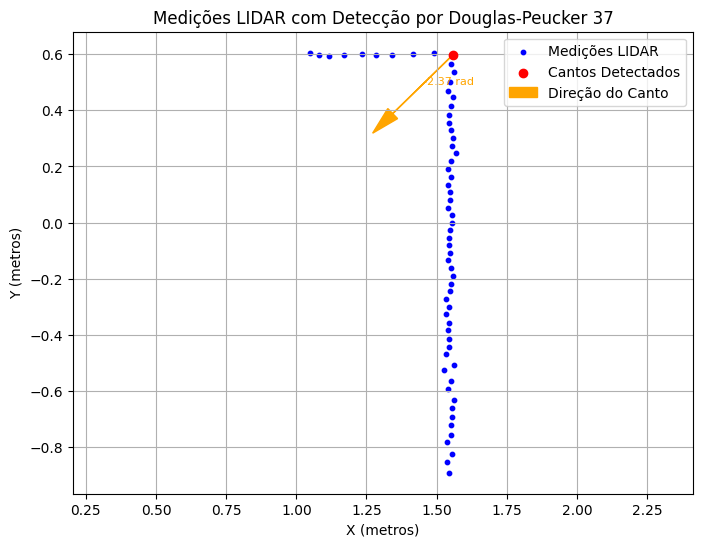


Corner Types: []

Corner Angles (rad): []


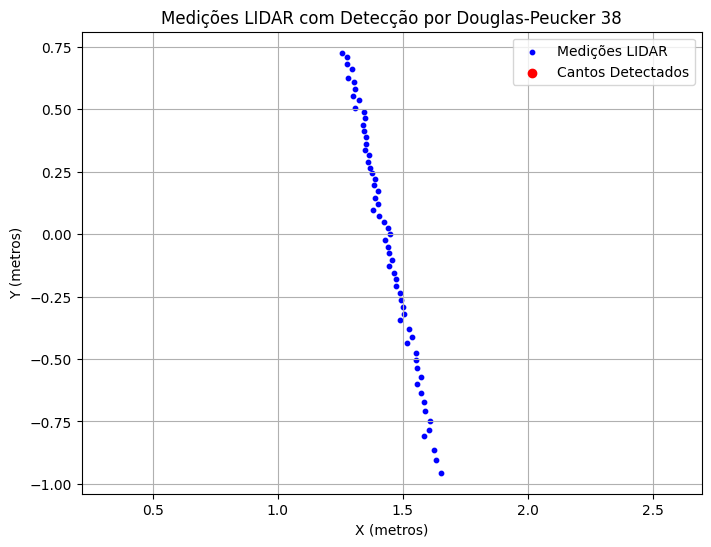


Corner Types: []

Corner Angles (rad): []


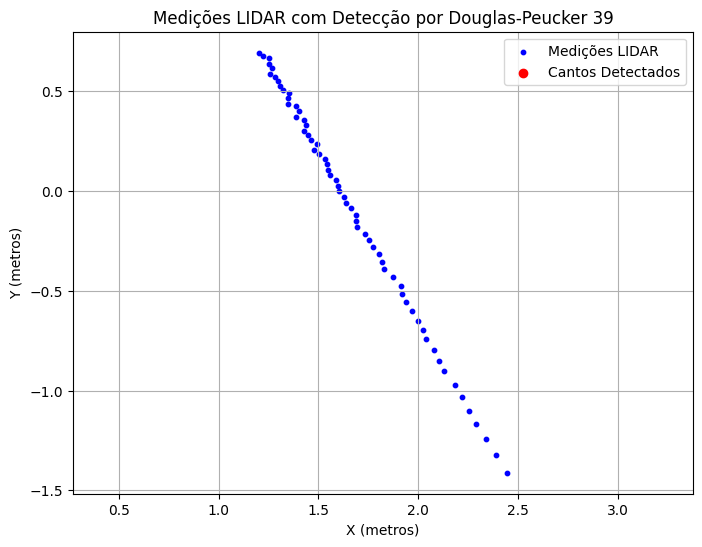


Corner Types: [1]

Corner Angles (rad): [-2.955629884786965]


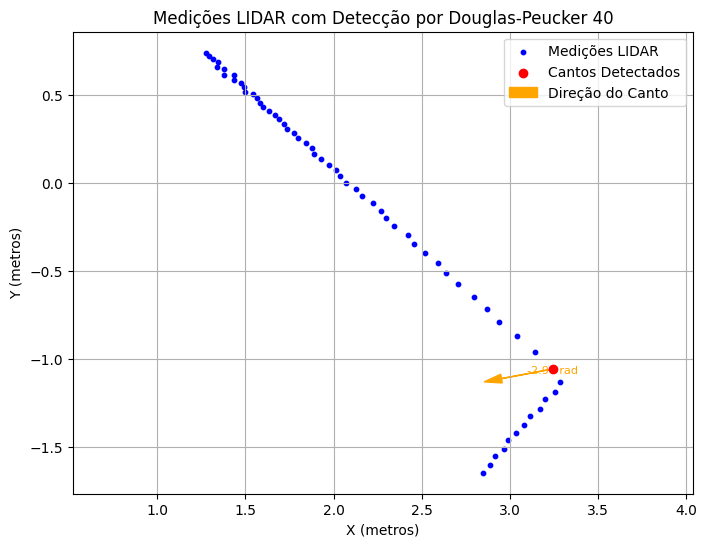


Corner Types: [1]

Corner Angles (rad): [-2.763163197636136]


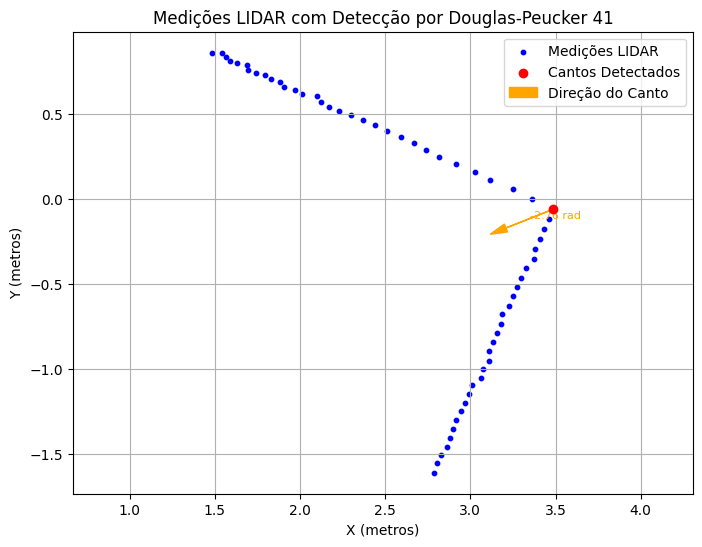


Corner Types: [0, 1]

Corner Angles (rad): [2.2191194873402194, -2.5342525103995386]


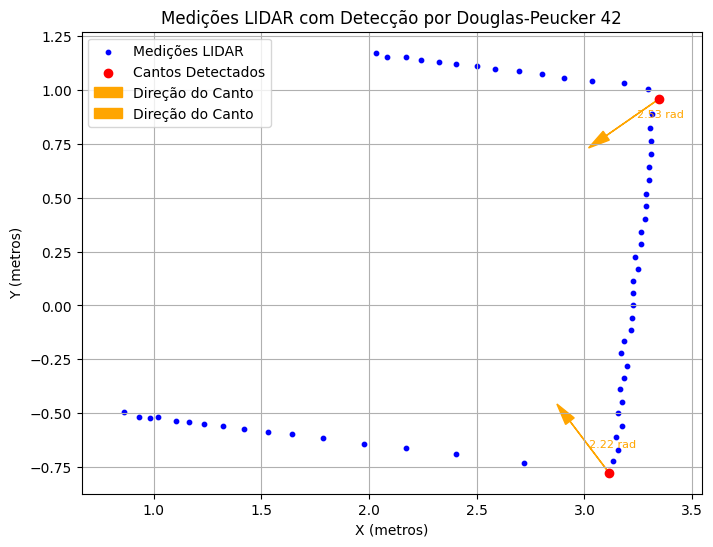


Corner Types: [1, 1]

Corner Angles (rad): [2.343742955933742, -2.413412788649804]


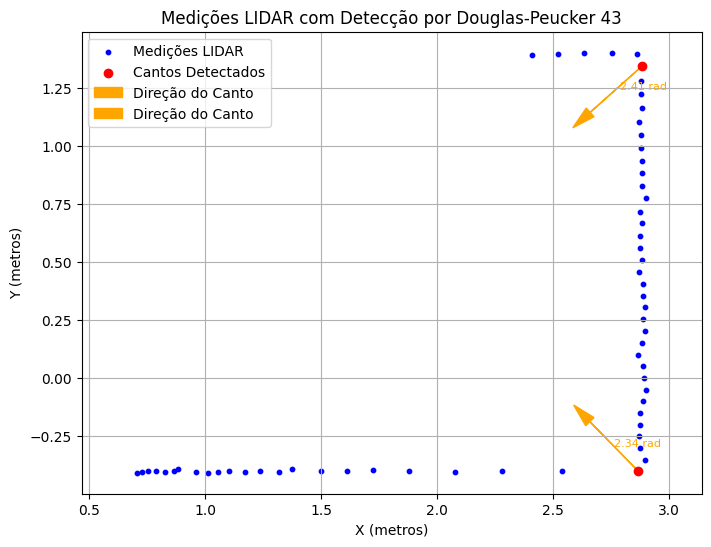


Corner Types: [0]

Corner Angles (rad): [2.3388782816581015]


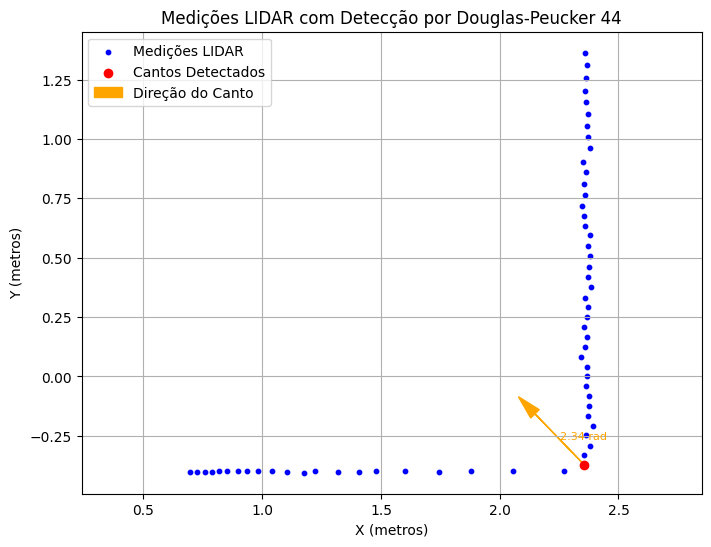


Corner Types: [1]

Corner Angles (rad): [2.3426395889700617]


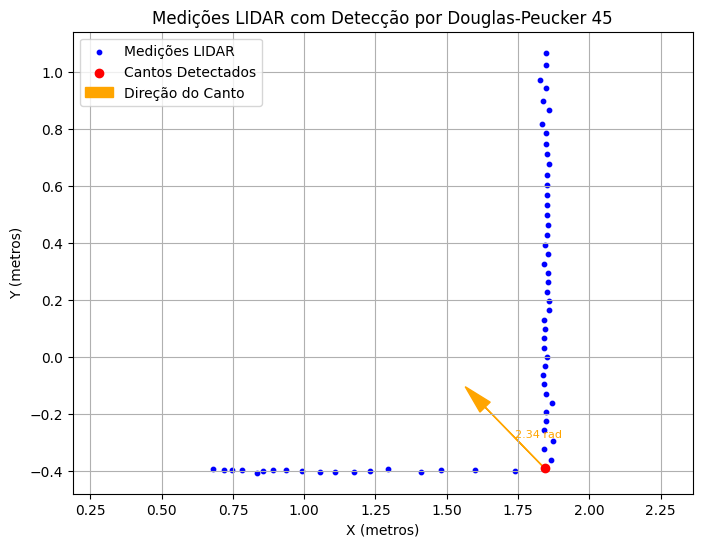


Corner Types: [0]

Corner Angles (rad): [2.443203682900412]


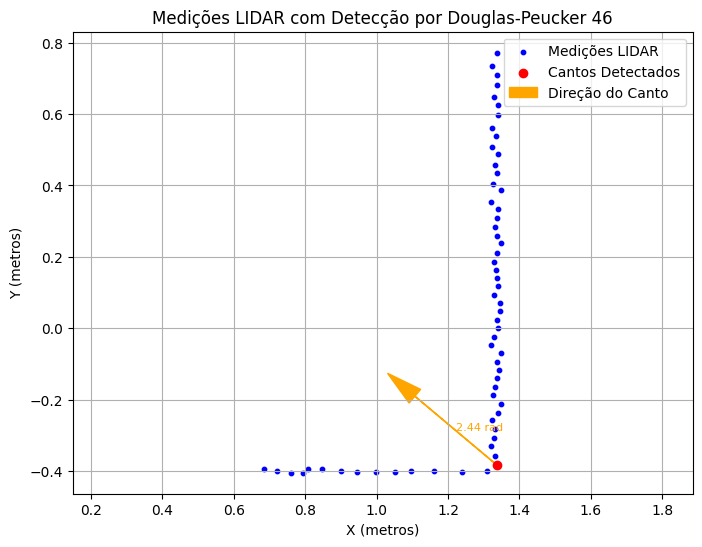


Corner Types: []

Corner Angles (rad): []


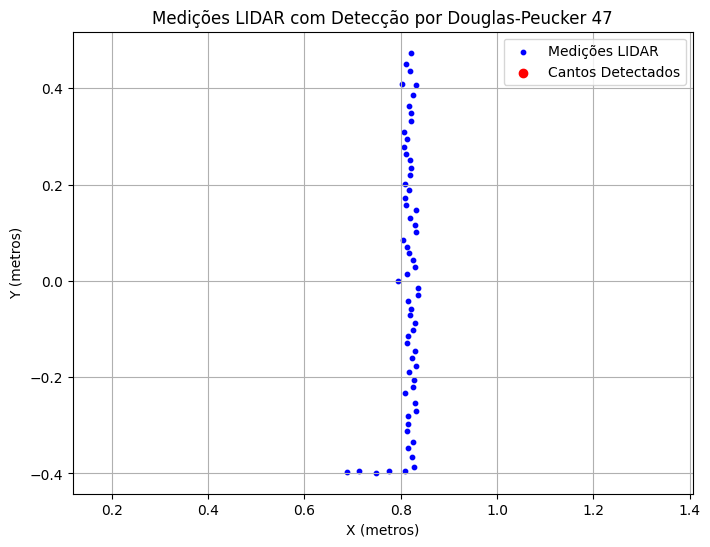


Corner Types: []

Corner Angles (rad): []


KeyboardInterrupt: 

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Função para converter medições LIDAR para coordenadas cartesianas
def lidar_to_cartesian(lidar_data, angles):
    x_coords = lidar_data * np.cos(angles)
    y_coords = lidar_data * np.sin(angles)
    return np.vstack((x_coords, y_coords)).T  # Transposta para (N, 2)

# Implementação do algoritmo Douglas-Peucker
def douglas_peucker(points, epsilon):
    """
    Simplifica uma linha poligonal usando o algoritmo Douglas-Peucker.
    :param points: Lista de pontos [(x1, y1), (x2, y2), ...].
    :param epsilon: Distância mínima para manter um ponto.
    :return: Pontos simplificados [(x1, y1), (xk, yk), ...].
    """
    # Encontrar a distância máxima de um ponto à linha inicial-final
    start, end = points[0], points[-1]
    line_vector = end - start
    line_length = np.linalg.norm(line_vector)

    if line_length == 0:
        distances = np.linalg.norm(points - start, axis=1)
    else:
        normalized_vector = line_vector / line_length
        projections = np.dot(points - start, normalized_vector)
        projections_points = start + np.outer(projections, normalized_vector)
        distances = np.linalg.norm(points - projections_points, axis=1)

    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]

    # Dividir recursivamente se a distância máxima for maior que epsilon
    if max_dist > epsilon:
        left = douglas_peucker(points[:max_dist_idx + 1], epsilon)
        right = douglas_peucker(points[max_dist_idx:], epsilon)
        return np.vstack((left[:-1], right))
    else:
        return np.array([start, end])

def are_angles_opposed(angle1, angle2, tolerance=np.radians(30)):
    """
    Check if two normalized angles are approximately in opposite directions (~= π radians apart).

    :param angle1: First angle in radians (assumed normalized within [-π, π)).
    :param angle2: Second angle in radians (assumed normalized within [-π, π)).
    :param tolerance: Tolerance in radians for considering angles opposed (~= π).
                      Default is 5 degrees converted to radians.
    :return: True if the angles are approximately opposite, False otherwise.
    """
    # Ensure angles are normalized to [-π, π)
    angle1 = (angle1 + np.pi) % (2 * np.pi) - np.pi
    angle2 = (angle2 + np.pi) % (2 * np.pi) - np.pi

    # Compute the absolute difference
    angle_diff = np.abs(angle1 - angle2)

    # Check if the difference is close to π (accounting for wraparound)
    return np.abs(angle_diff - np.pi) <= tolerance

def get_angle_and_type_linear(lidar_data, corner_idx, window_size):
    """
    Calculate the angle and type (convex or concave) for a corner point using linear approximation.

    :param lidar_data: Cartesian coordinates of LiDAR points (Nx2 array).
    :param corner_idx: Index of the corner point in the data.
    :param window_size: Number of points before and after the corner to consider for linear fit.
    :return: Type (1 for concave, 0 for convex) and angle in radians.
    """
    keep=1
    bef_points=[]
    aft_points=[]

    bef_points.append(lidar_data[corner_idx])
    bef_idx = corner_idx-window_size
    if(bef_idx<0):
      bef_idx=0
    bef_points.append(lidar_data[corner_idx-window_size])
    aft_points.append(lidar_data[corner_idx])
    aft_idx = corner_idx+window_size
    if(aft_idx>len(lidar_data)-1):
      aft_idx=len(lidar_data)-1
    aft_points.append(lidar_data[aft_idx])

    bef_points = np.array(bef_points)
    aft_points = np.array(aft_points)
    x_bef = bef_points[:, 0]
    y_bef = bef_points[:, 1]
    slope_bef, intercept_bef = np.polyfit(x_bef, y_bef, 1)
    y_bef_ini = slope_bef * bef_points[0, 0] + intercept_bef
    y_bef_end = slope_bef * bef_points[1, 0] + intercept_bef
    vector_bef = np.array([bef_points[1, 0]-bef_points[0, 0], y_bef_end-y_bef_ini])
    angle_bef = np.arctan2(vector_bef[1], vector_bef[0])

    x_aft = aft_points[:, 0]
    y_aft = aft_points[:, 1]
    slope_aft, intercept_aft = np.polyfit(x_aft, y_aft, 1)
    y_aft_ini = slope_aft * aft_points[0, 0] + intercept_aft
    y_aft_end = slope_aft * aft_points[1, 0] + intercept_aft
    vector_aft = np.array([aft_points[1, 0]-aft_points[0, 0], y_aft_end-y_aft_ini])
    angle_aft = np.arctan2(vector_aft[1], vector_aft[0])

    if(are_angles_opposed(angle_bef, angle_aft)==1):
      keep=0
      return 0, 0, keep

    vector = vector_bef / np.sqrt(vector_bef[0]**2 + vector_bef[1]**2) + vector_aft/ np.sqrt(vector_aft[0]**2 + vector_aft[1]**2)
    angle_f = np.arctan2(vector[1], vector[0])

    # Ensure we have enough points in the window
    idx_before = max(0, corner_idx - window_size)
    idx_aft = min(len(lidar_data), corner_idx + window_size + 1)

    # Points before the corner
    points_before = lidar_data[idx_before:corner_idx]

    # Points after the corner
    points_after = lidar_data[corner_idx + 1:idx_aft+1]

    # Fit a line to points_before
    x_before, y_before = points_before[:, 0], points_before[:, 1]
    slope_before, intercept_before = np.polyfit(x_before, y_before, 1)  # Linear fit (y = mx + b)

    # Fit a line to points_after
    x_after, y_after = points_after[:, 0], points_after[:, 1]
    slope_after, intercept_after = np.polyfit(x_after, y_after, 1)  # Linear fit (y = mx + b)

    # Calculate the angle between the two slopes
    tan_angle = abs((slope_after - slope_before) / (1 + slope_after * slope_before))
    angle = np.arctan(tan_angle)  # Angle in radians

    # Determine convexity/concavity using cross product of directional vectors
    v1 = np.array([1, slope_before])  # Direction vector for line before
    v2 = np.array([1, slope_after])   # Direction vector for line after

    cross_product = np.cross(v1, v2)

    if cross_product < 0:
        corner_type = 1  # Concave
    else:
        corner_type = 0  # Convex


    return corner_type, angle_f, keep


# Main function for detecting corners using Douglas-Peucker
def detect_corners_douglas_peucker(lidar_data, angles, epsilon=0.3, radius=0.85, window_size=5):
    corners = []
    lidar_cartesian = lidar_to_cartesian(lidar_data, angles)  # Convert to Cartesian coordinates

    # Simplify the line using Douglas-Peucker
    simplified_points = douglas_peucker(lidar_cartesian, epsilon)

    # Detect indices of simplified points in the original data
    for point in simplified_points:
        idx = np.where((lidar_cartesian == point).all(axis=1))[0]
        if len(idx) > 0:
            corners.append(idx[0])

    # Filter out the first and last points
    corners = [idx for idx in corners if idx != 0 and idx != len(lidar_cartesian) - 1]

    # Perform filtering based on distance to adjacent points
    filtered_corners = []
    filtered_corners_type = []
    filtered_corners_angle = []
    filtered_corner_coords = []


    for corner_idx in corners:
        prev_idx = corner_idx - 1
        next_idx = corner_idx + 1

        if prev_idx >= 0 and next_idx < len(lidar_cartesian):
            prev_point = lidar_cartesian[prev_idx]
            next_point = lidar_cartesian[next_idx]
            corner_point = lidar_cartesian[corner_idx]

            # Calculate distances to the adjacent points
            dist_to_prev = np.linalg.norm(corner_point - prev_point)
            dist_to_next = np.linalg.norm(corner_point - next_point)

            # Keep the corner only if both adjacent points are within the radius
            if dist_to_prev <= radius and dist_to_next <= radius:
                # Get convex/concave type and angle
                c_type, c_angle, keep = get_angle_and_type_linear(lidar_cartesian, corner_idx, window_size)
                if keep==1:
                  filtered_corners_type.append(c_type)
                  filtered_corners_angle.append(c_angle)
                  filtered_corners.append(corner_idx)
                  filtered_corner_coords.append(corner_point)

    return filtered_corners, filtered_corners_type, filtered_corners_angle, filtered_corner_coords



# Plotar medições LIDAR com os cantos detectados
def plot_lidar_with_corners(lidar_data, corners, angles, corner_coords, corner_angles, iter):
    x_coords, y_coords = lidar_to_cartesian(lidar_data, angles).T
    corner_x, corner_y = x_coords[corners], y_coords[corners]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, s=10, label="Medições LIDAR", color='b')
    plt.scatter(corner_x, corner_y, color='r', label="Cantos Detectados", zorder=5)

    # Plot vectors for each corner
    for (x, y), angle in zip(corner_coords, corner_angles):
        vector_length = 0.3  # Length of the vector
        dx = vector_length * np.cos(angle)
        dy = vector_length * np.sin(angle)

        plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, color='orange', label="Direção do Canto")

        # Annotate the angle in radians
        plt.text(x + dx / 2, y + dy / 2, f"{angle:.2f} rad", color='orange', fontsize=8)

    plt.axis("equal")
    plt.title(f"Medições LIDAR com Detecção por Douglas-Peucker {iter}")
    plt.xlabel("X (metros)")
    plt.ylabel("Y (metros)")
    plt.legend()
    plt.grid(True)
    plt.show()



class Corner:
    def __init__(self, position, corner_type, facing_angle=None):
        self.position = position  # [x, y]
        self.corner_type = corner_type  # 'convex' ou 'concave'
        self.facing_angle = facing_angle  # Ângulo que o canto está enfrentando (opcional)

    def __str__(self):
        return f"Corner(position={self.position}, type={self.corner_type}, facing_angle={self.facing_angle})"



# Iterar sobre as leituras LIDAR
for i in range(len(lidar_data)):
    lidar_row = lidar_data[i]
    corners, corners_type, corners_angle, corner_coords = detect_corners_douglas_peucker(lidar_row, angles)

    # Print corner information
    print("\nCorner Types:", corners_type)
    print("\nCorner Angles (rad):", corners_angle)

    # Plot LIDAR data with corners and vectors
    plot_lidar_with_corners(lidar_row, corners, angles, corner_coords, corners_angle, i)

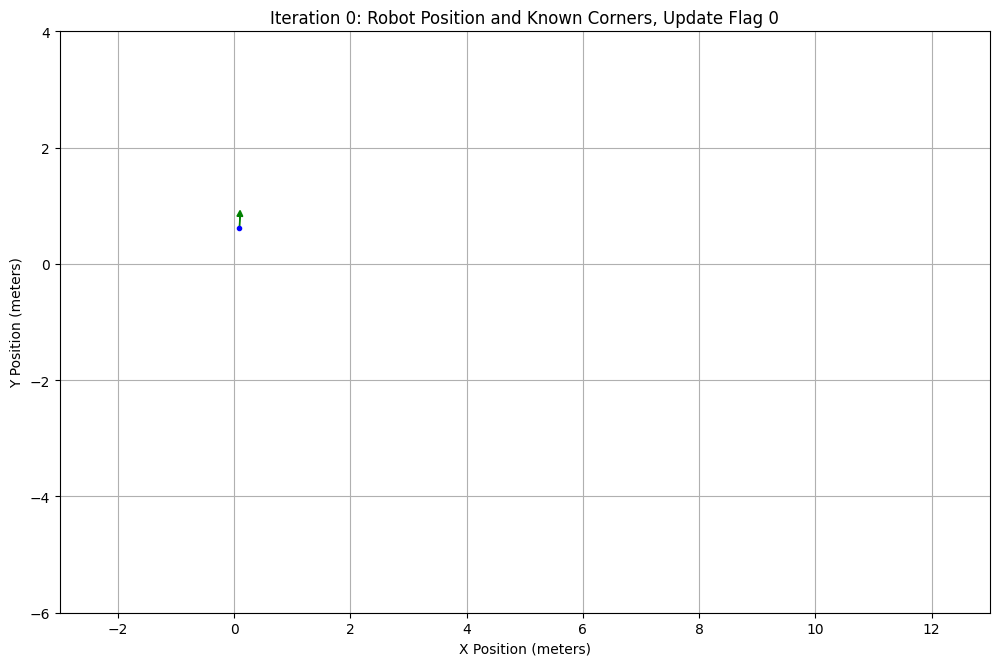

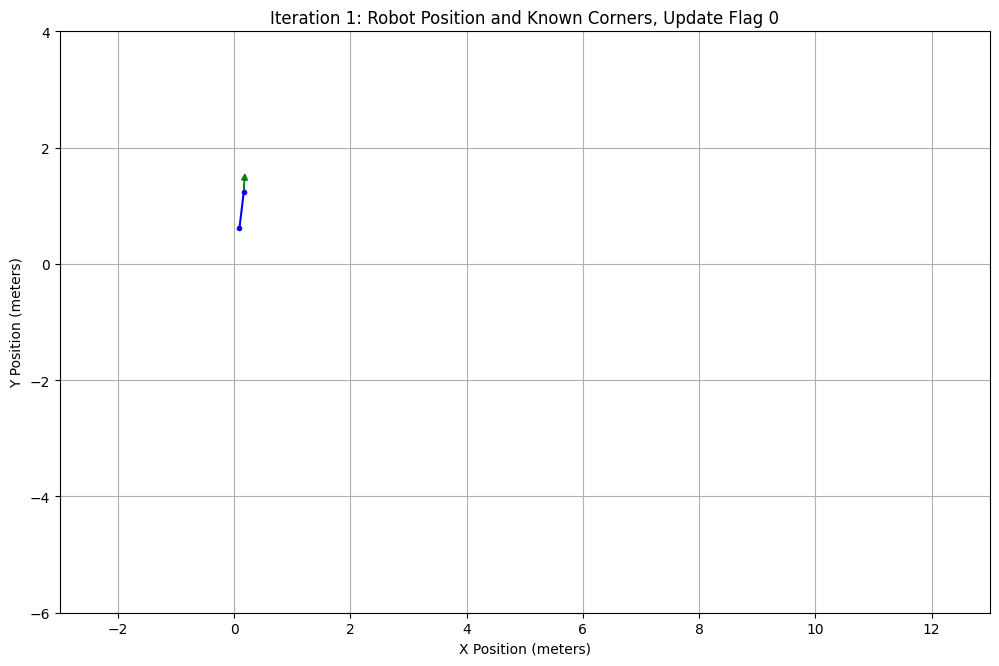

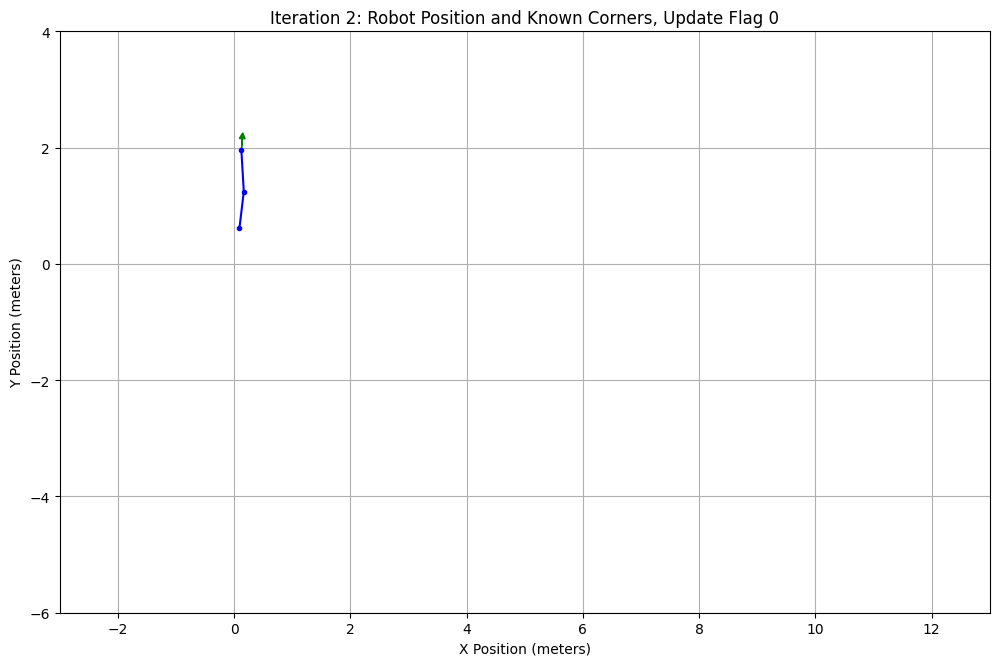

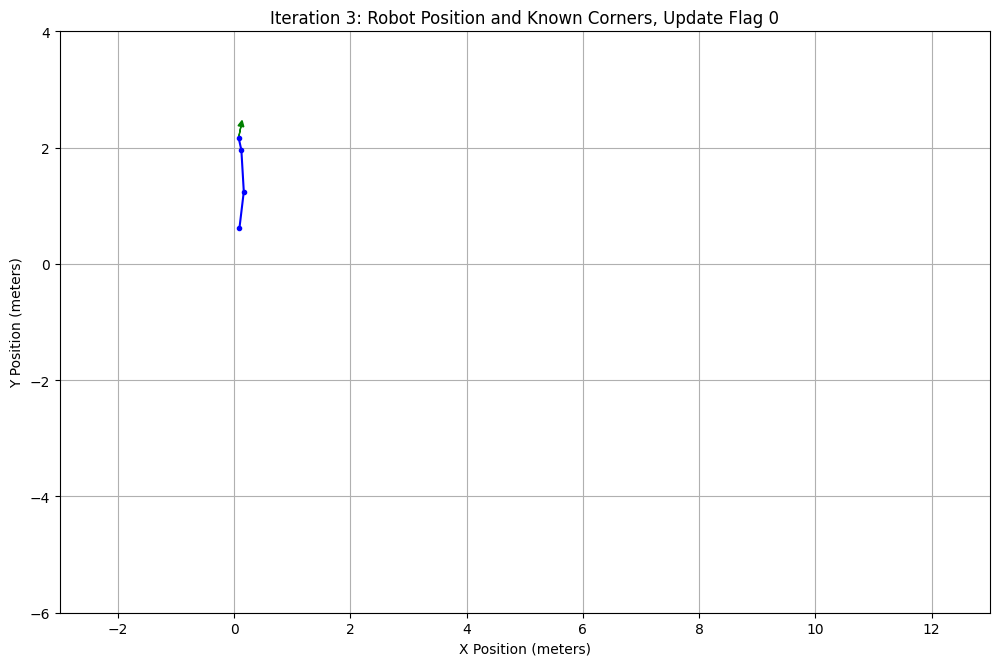

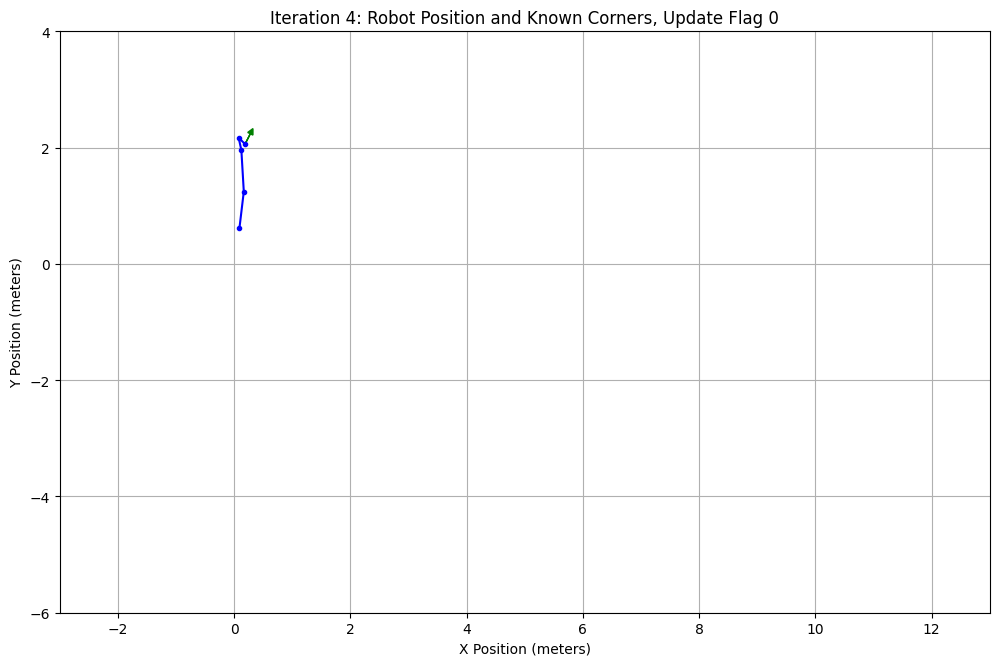

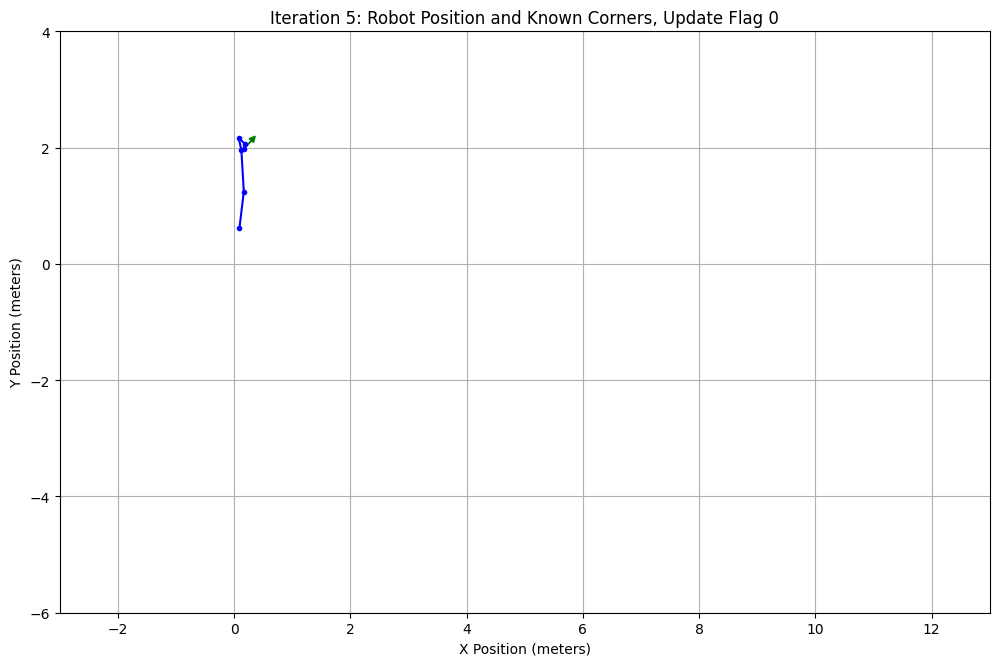

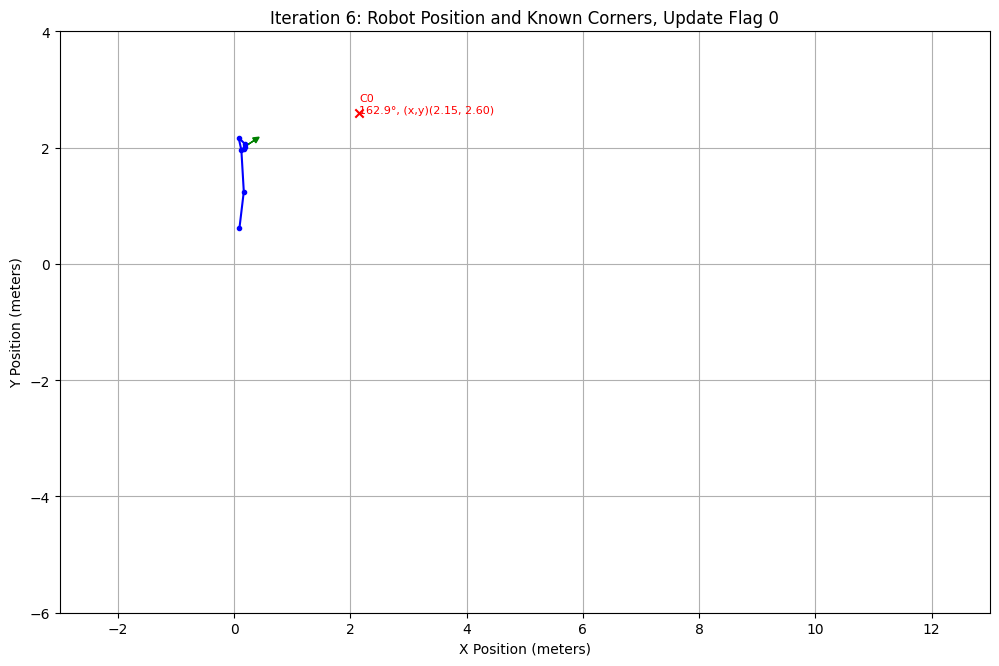

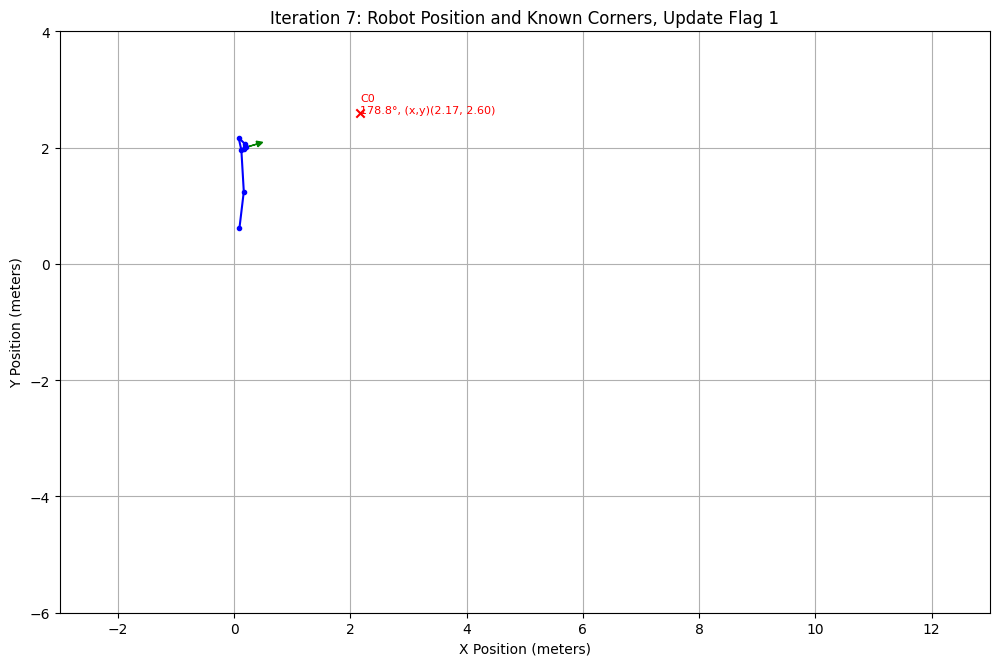

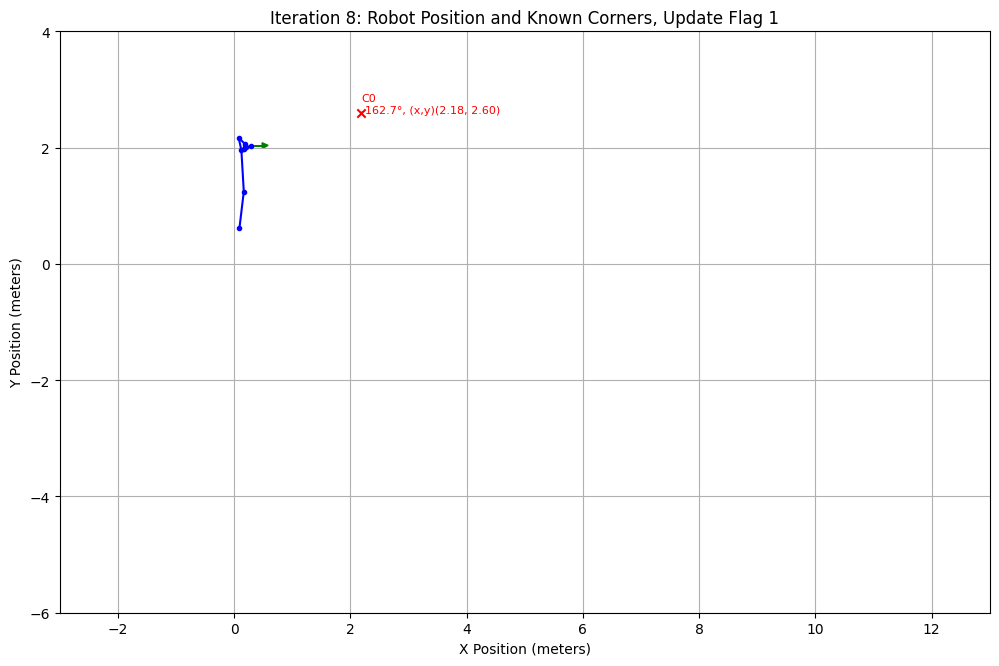

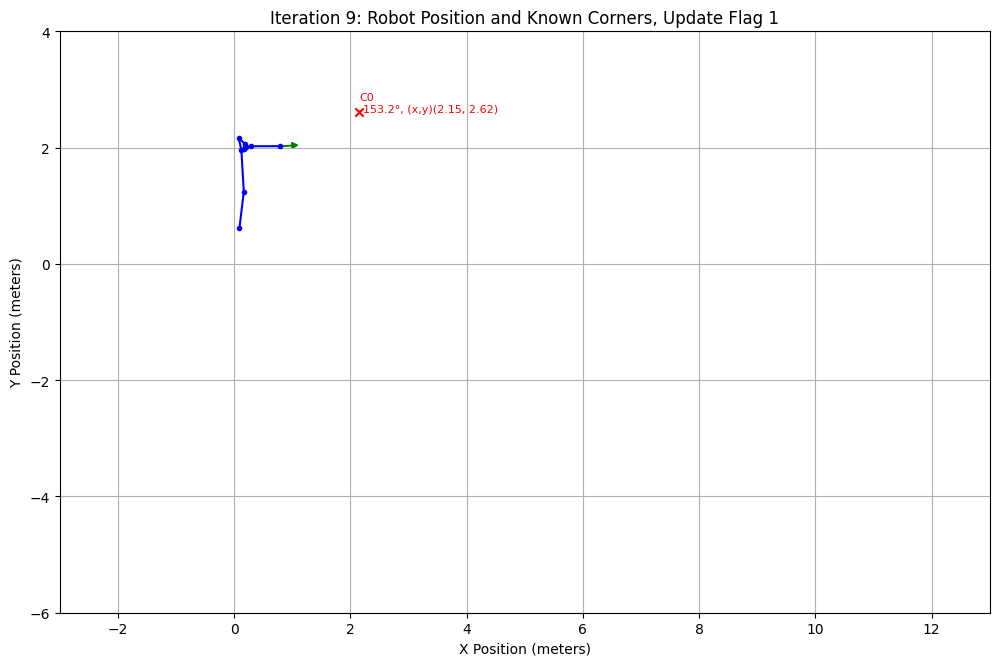

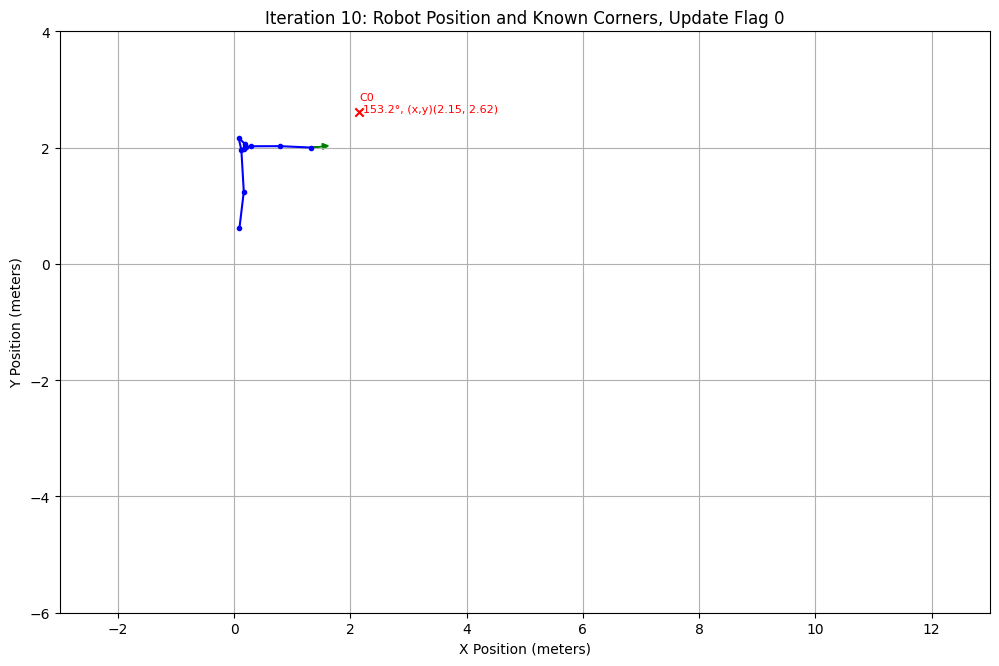

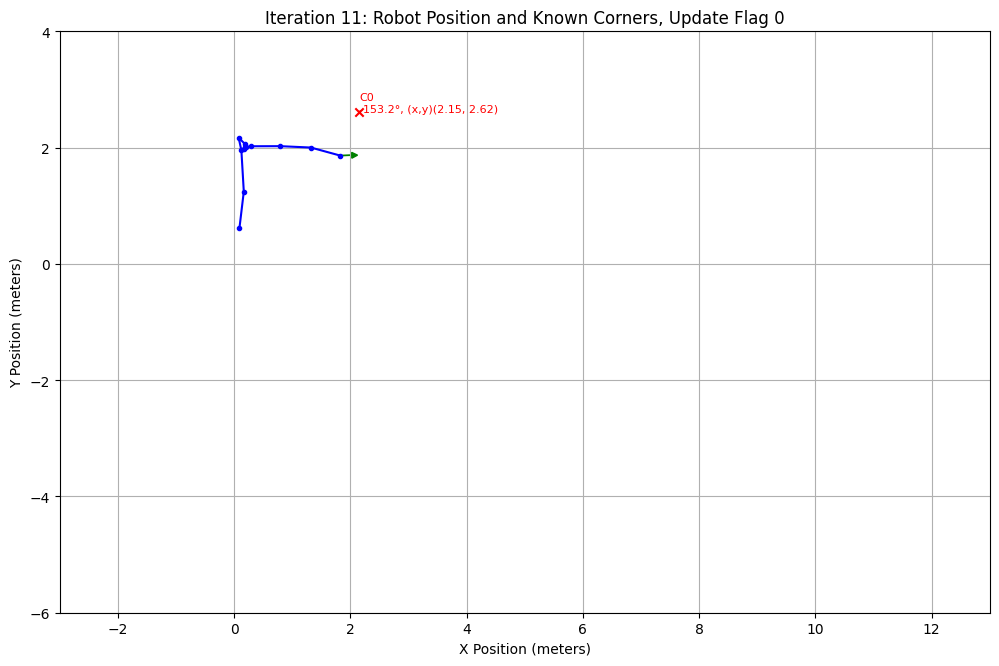

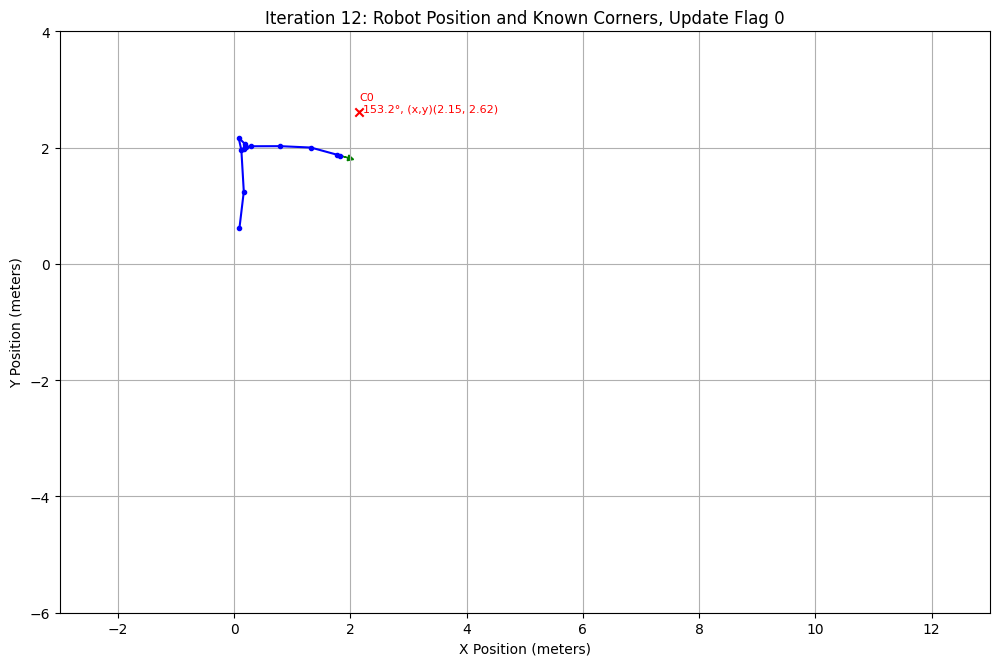

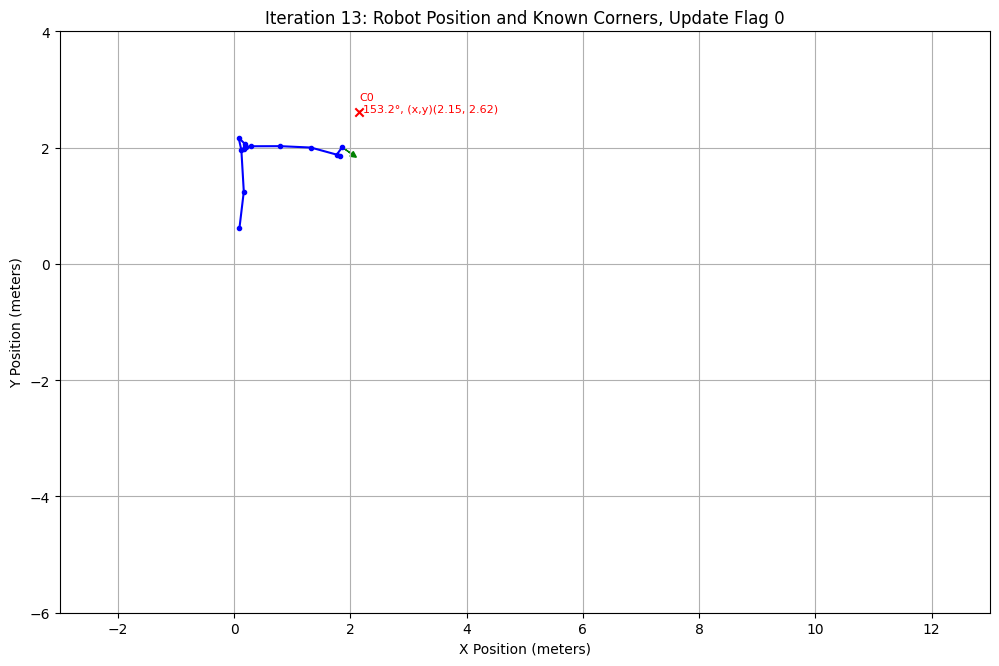

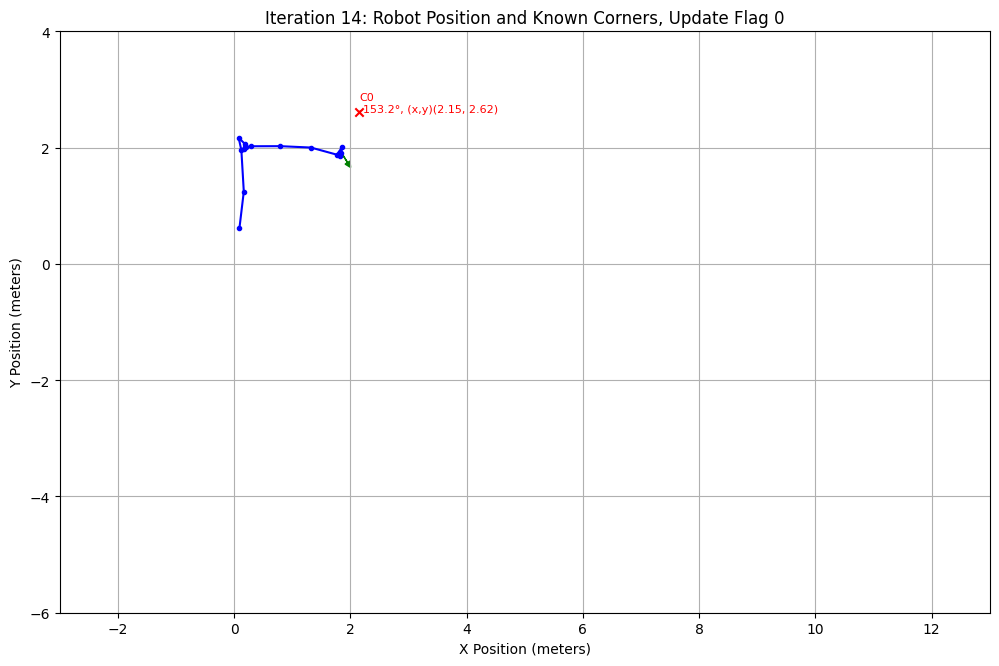

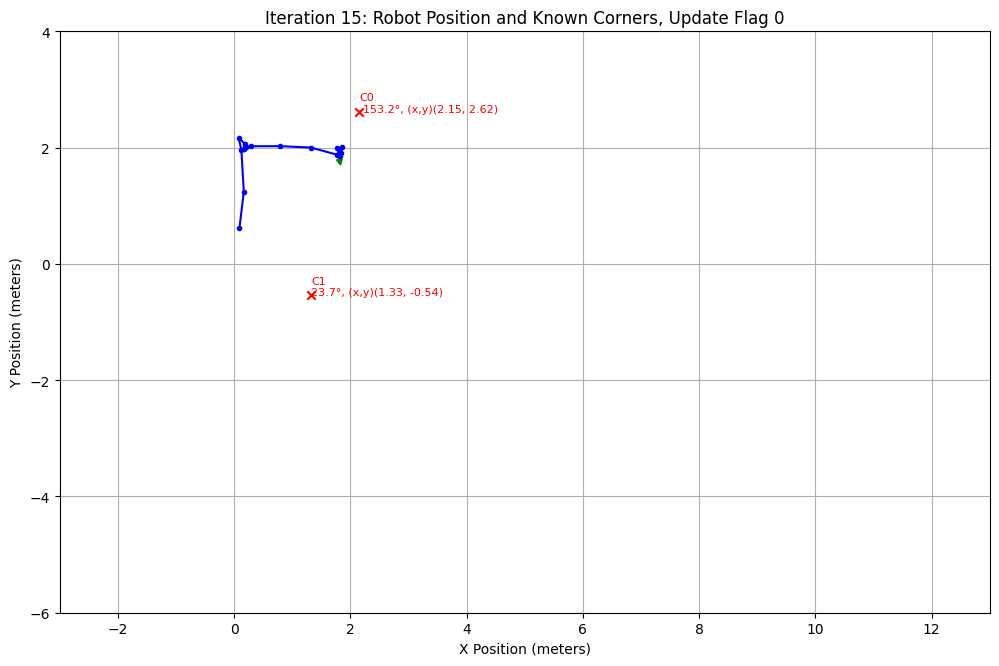

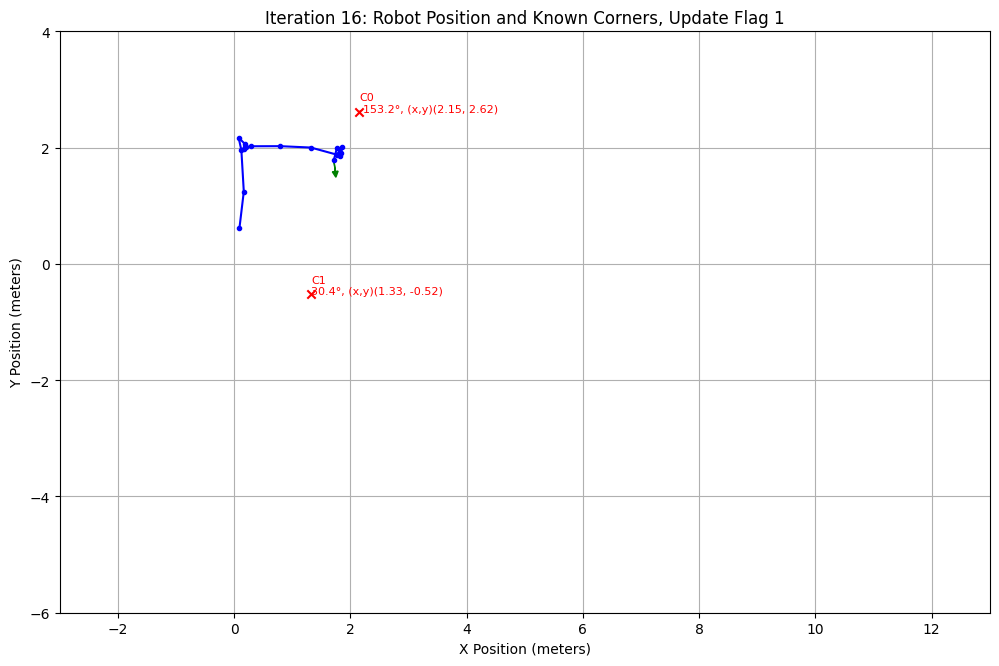

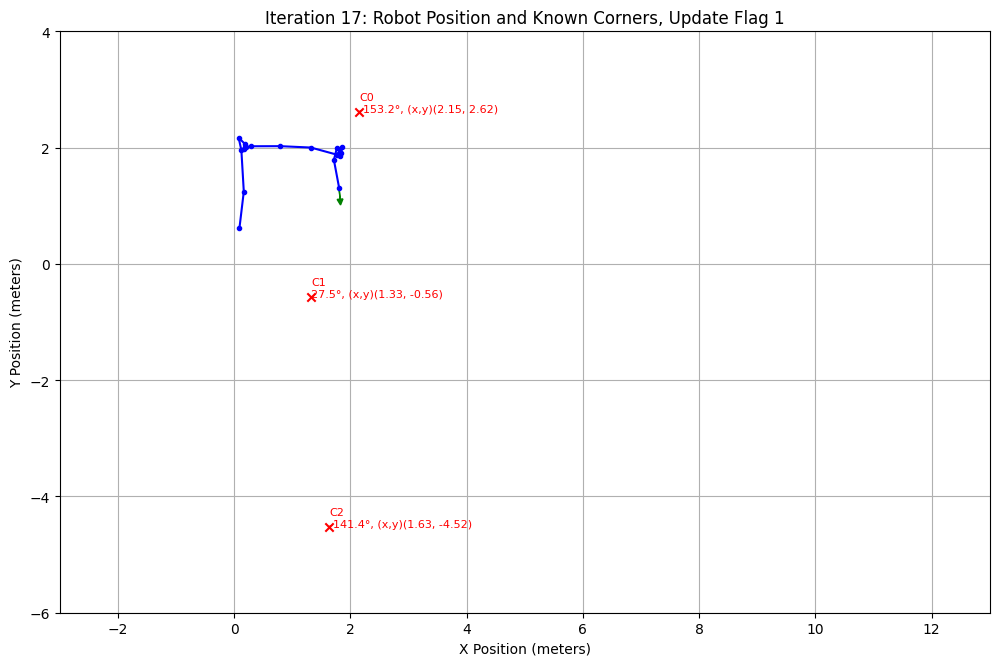

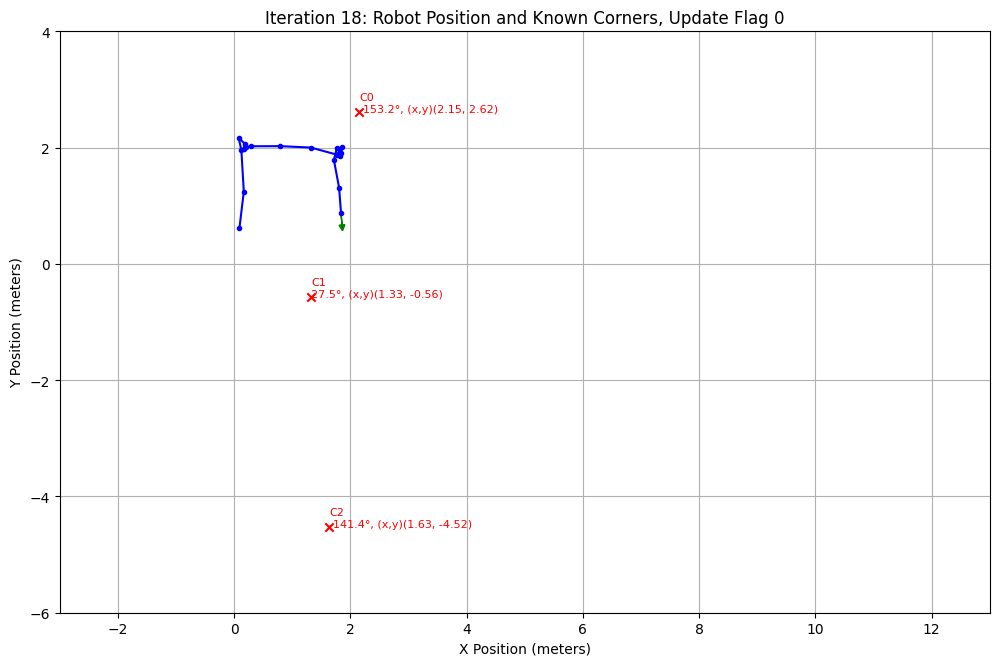

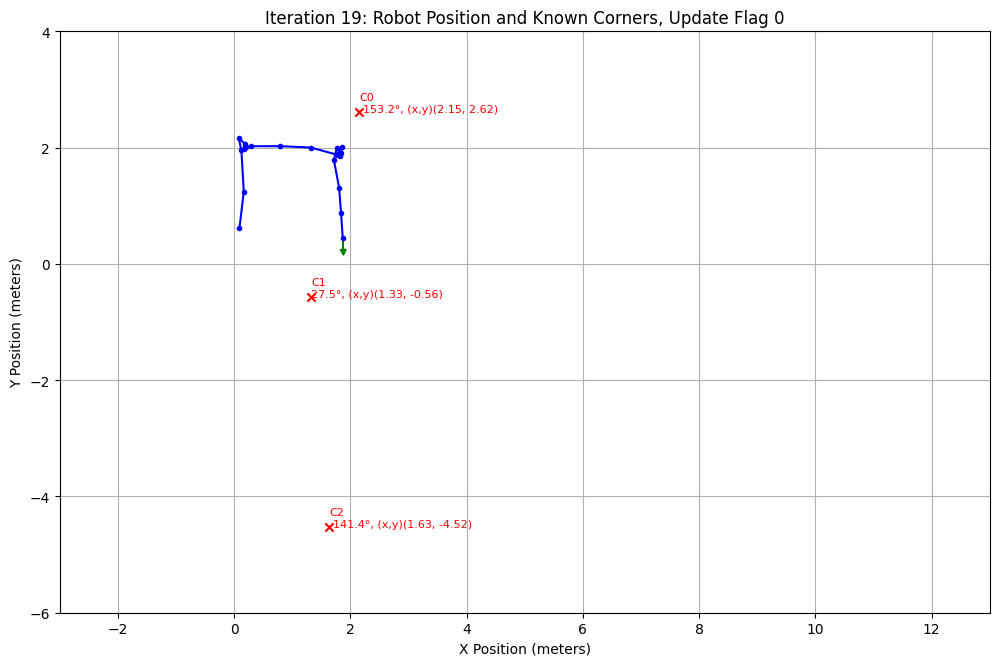

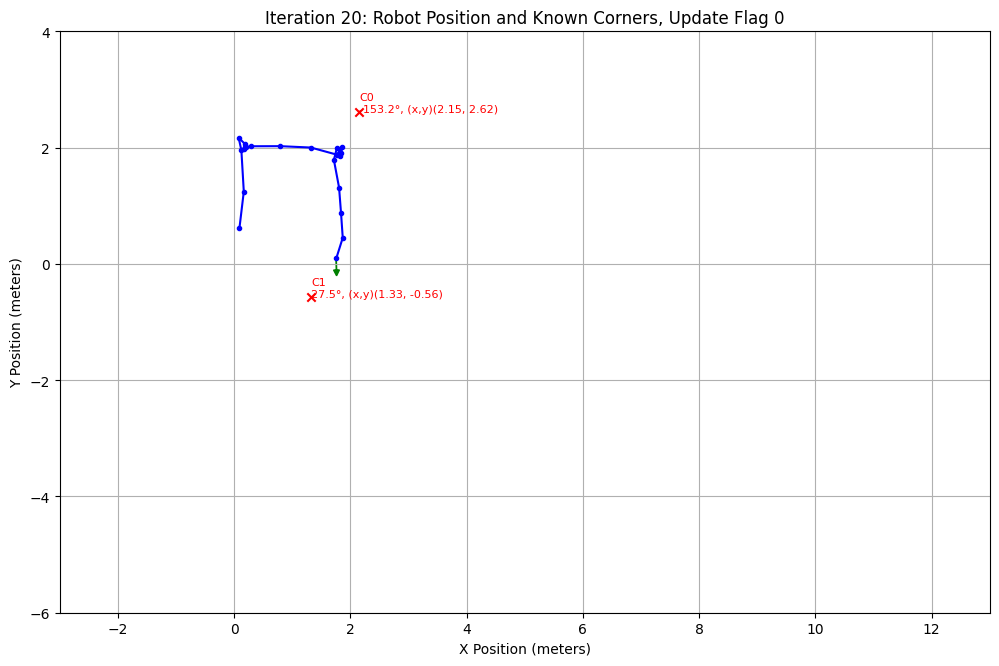

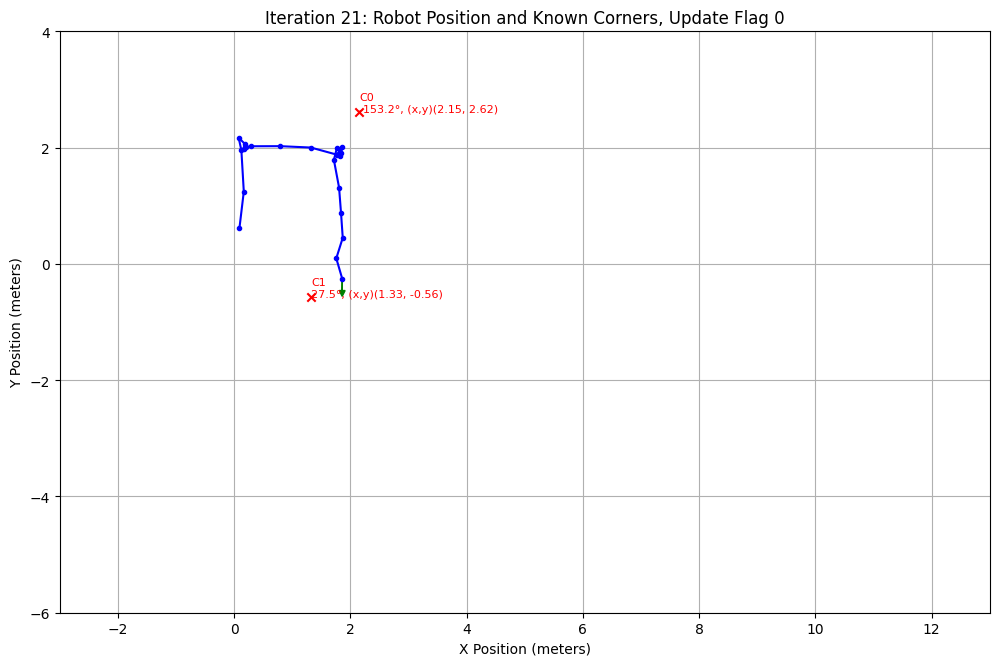

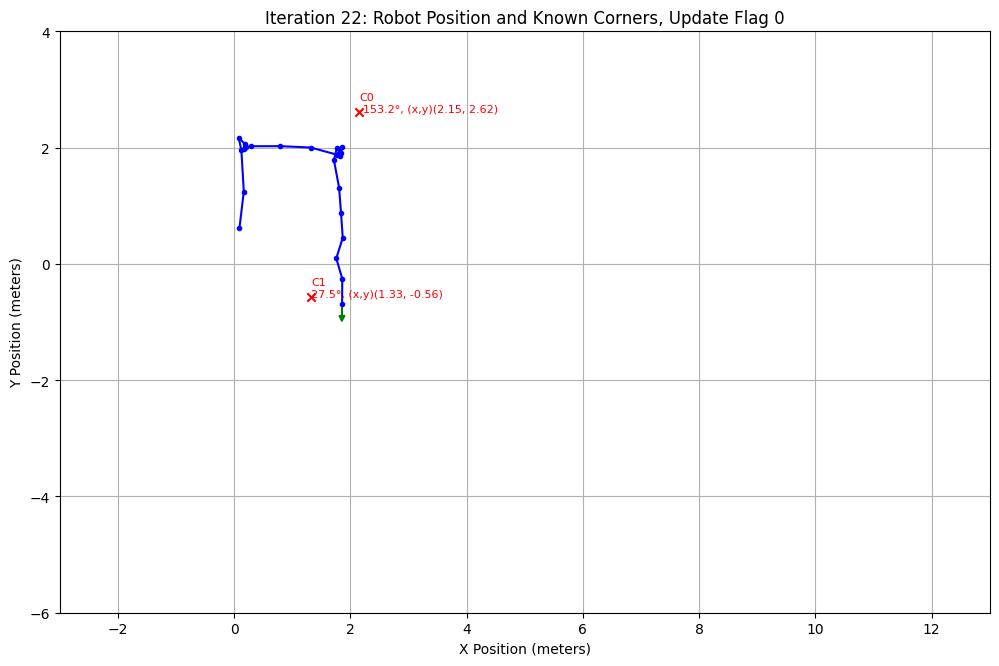

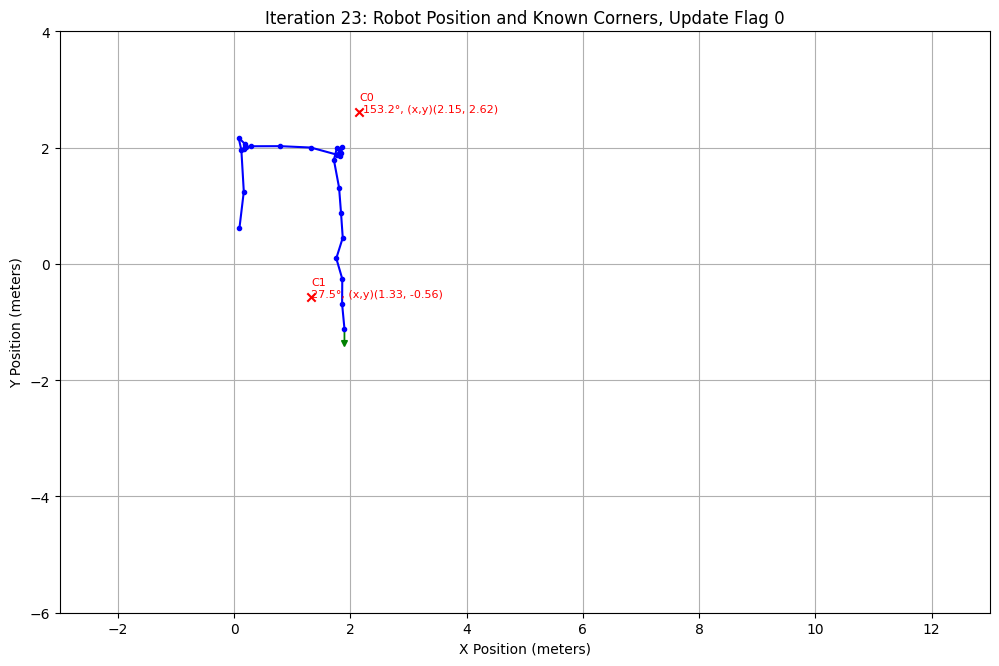

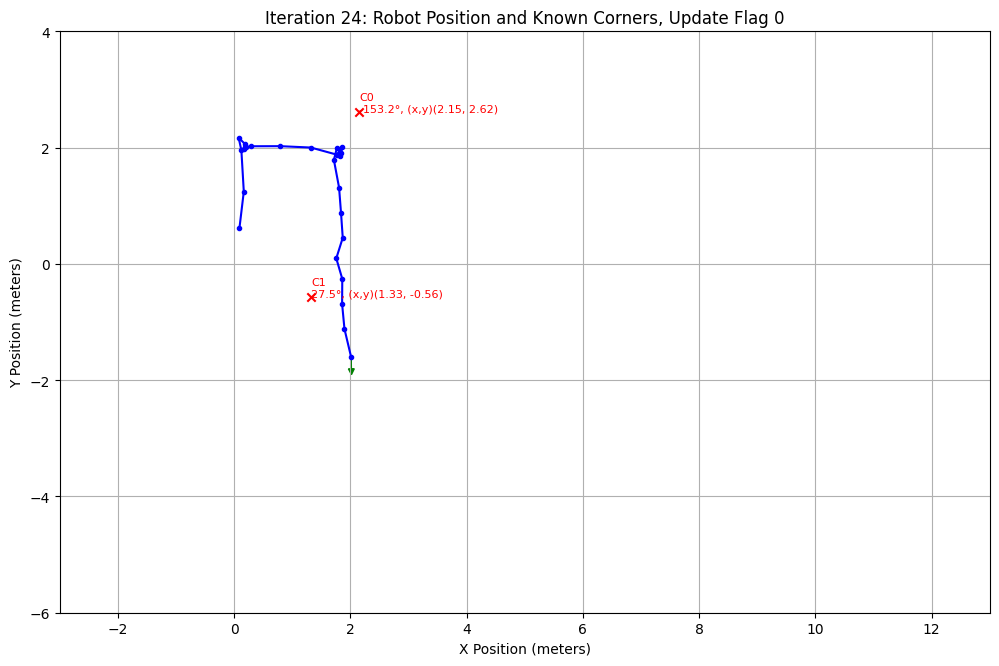

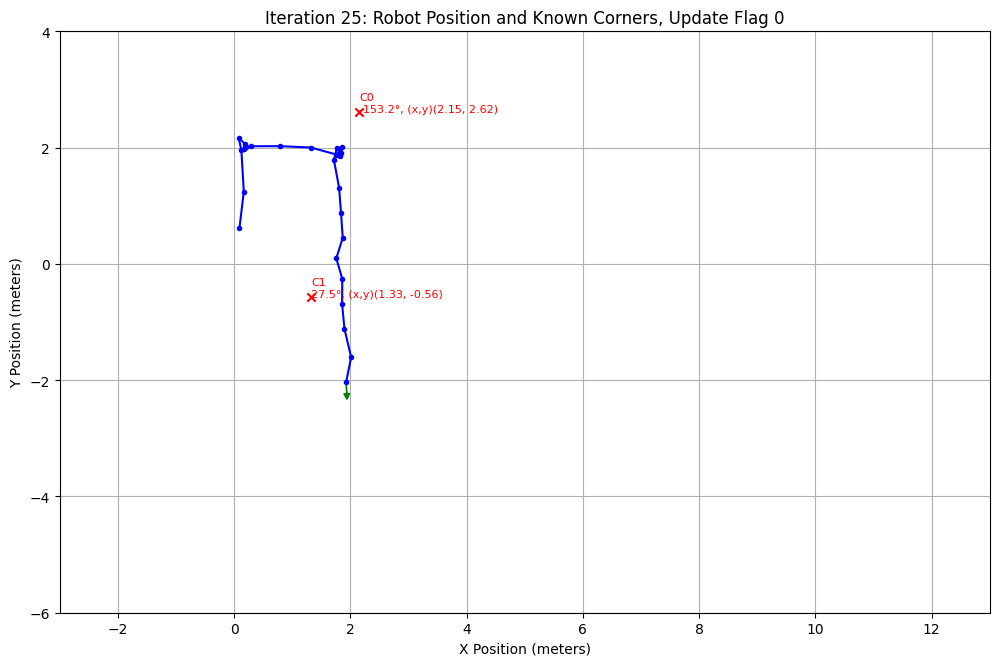

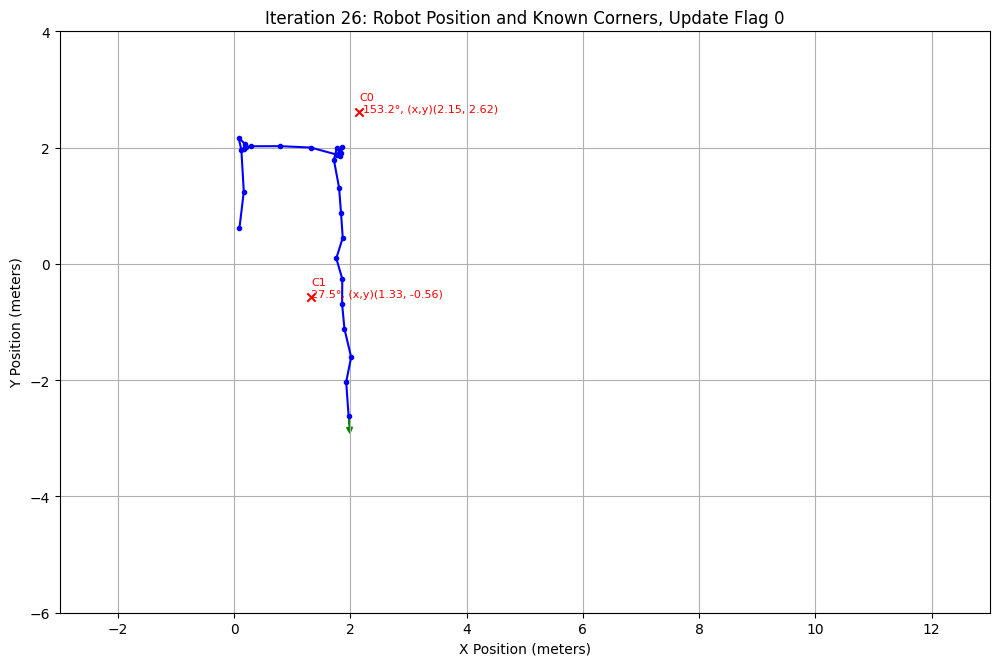

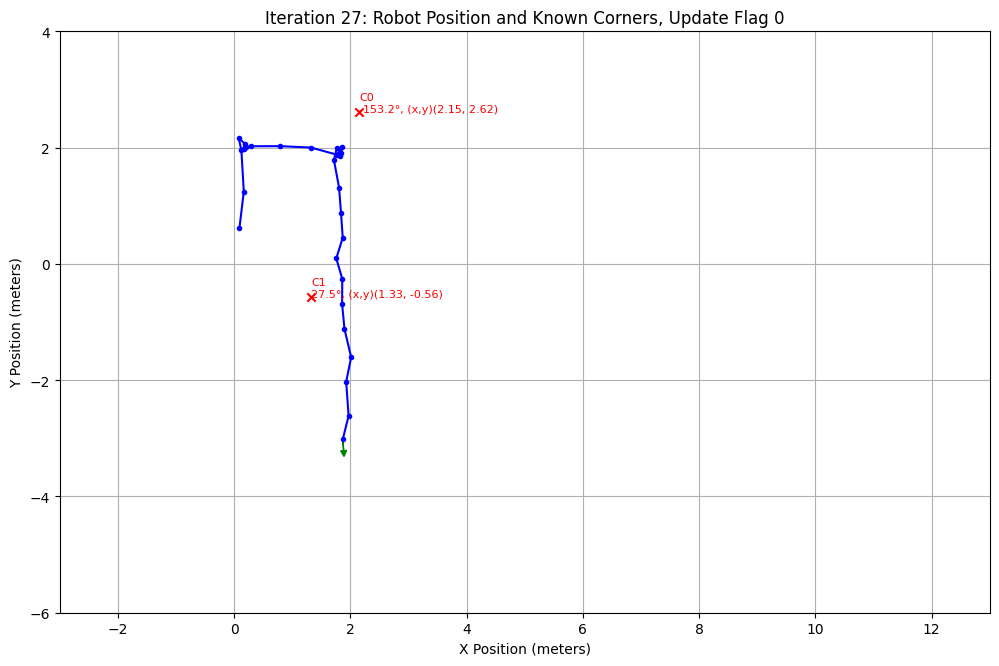

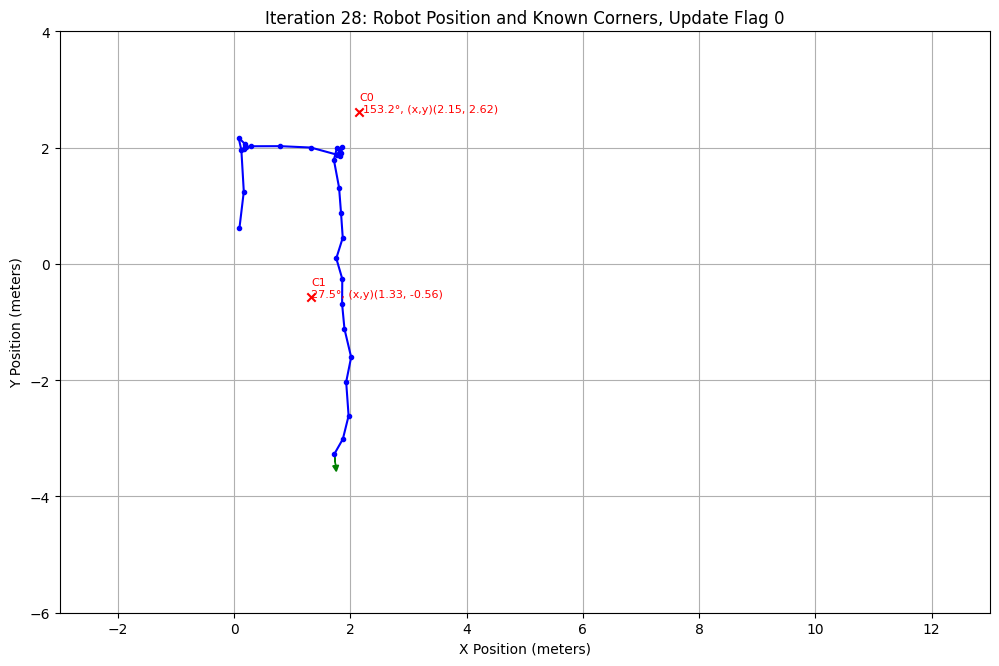

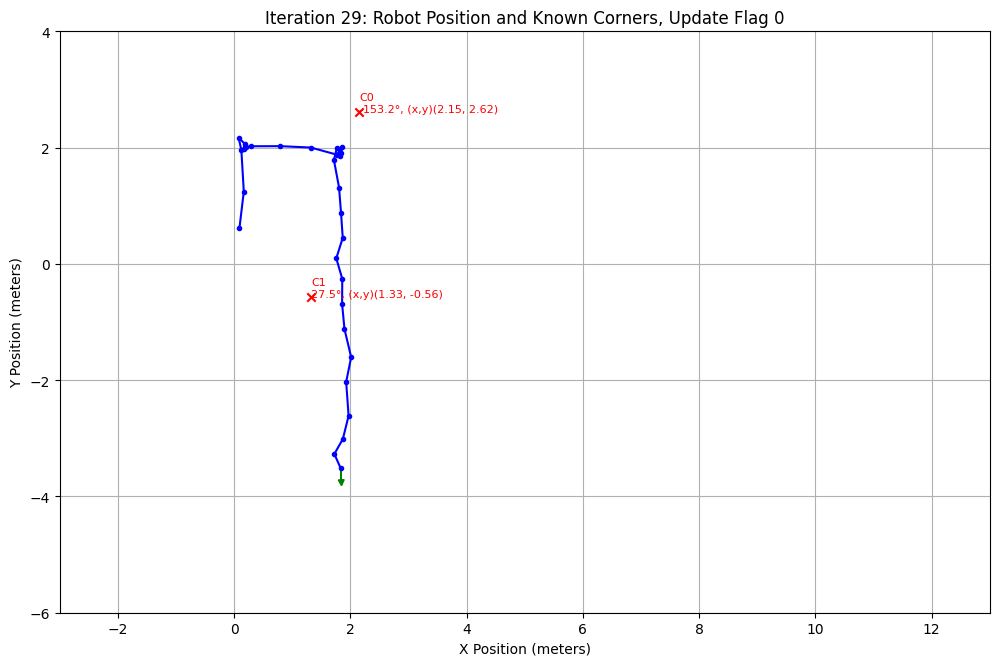

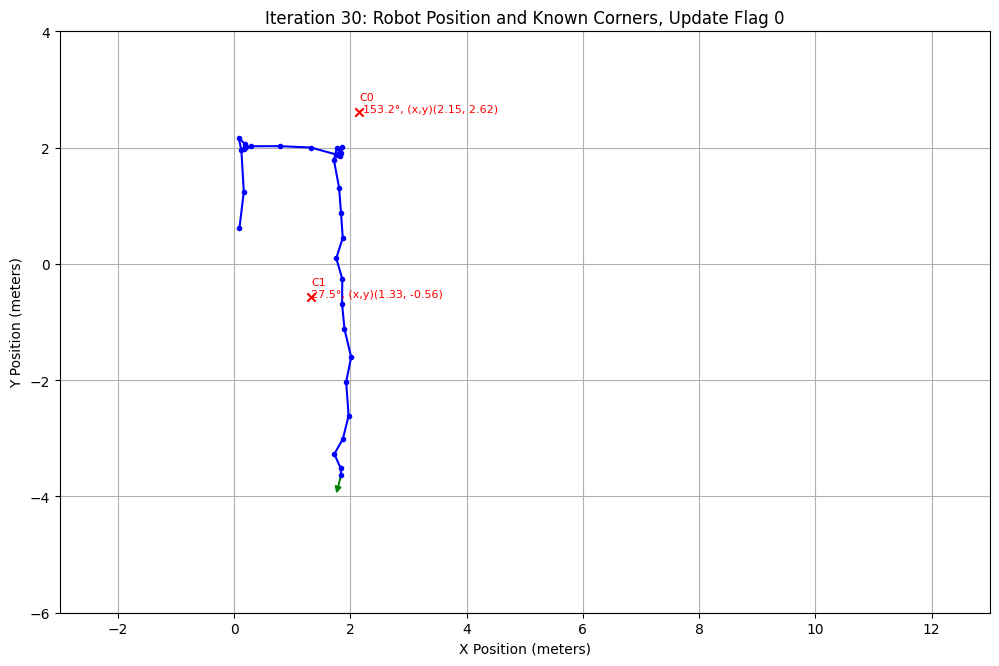

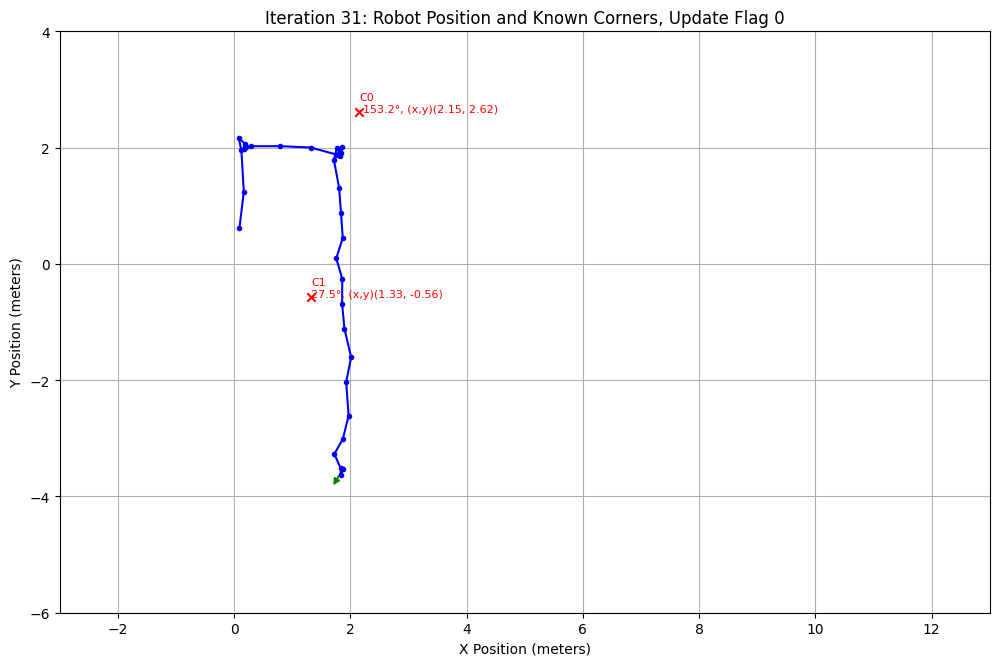

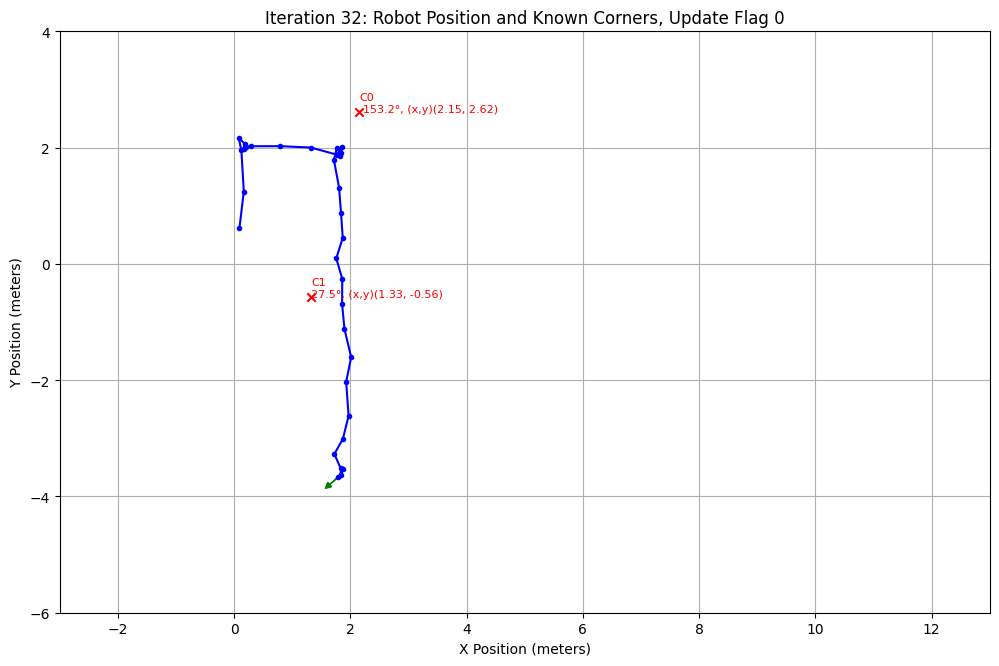

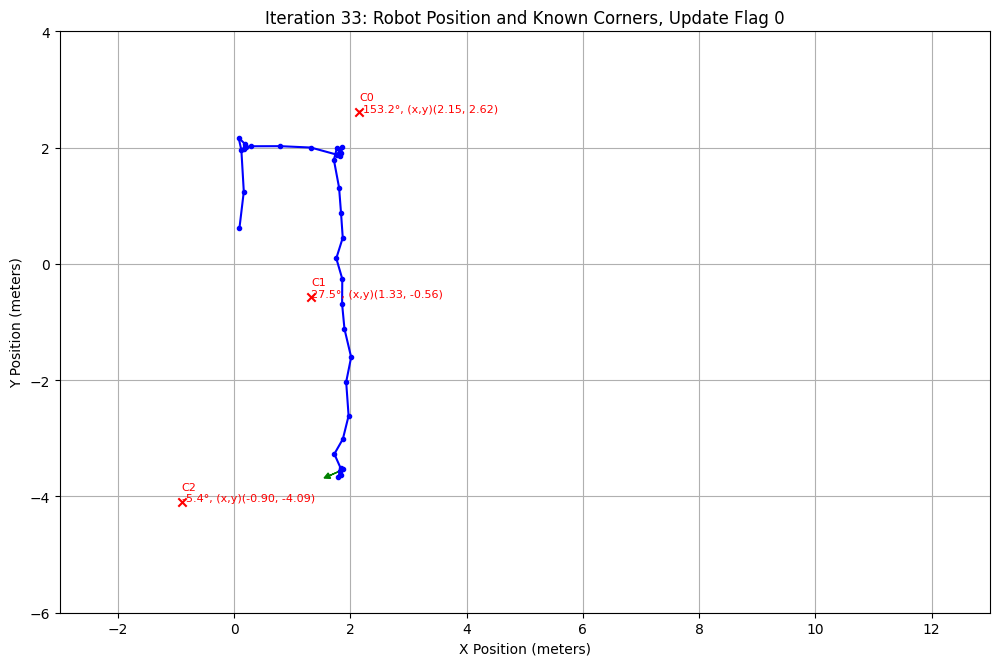

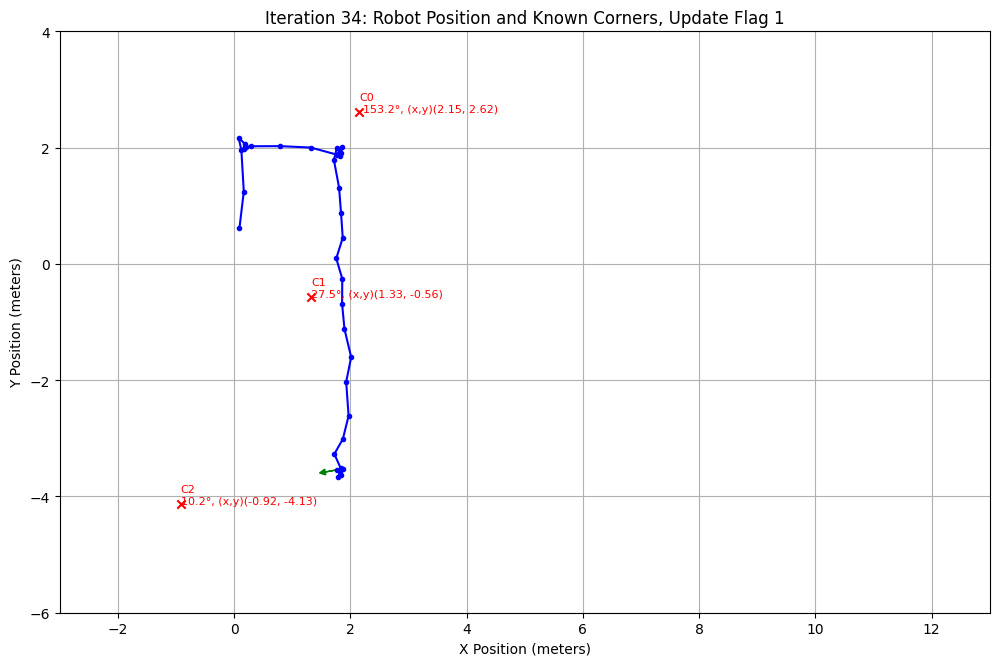

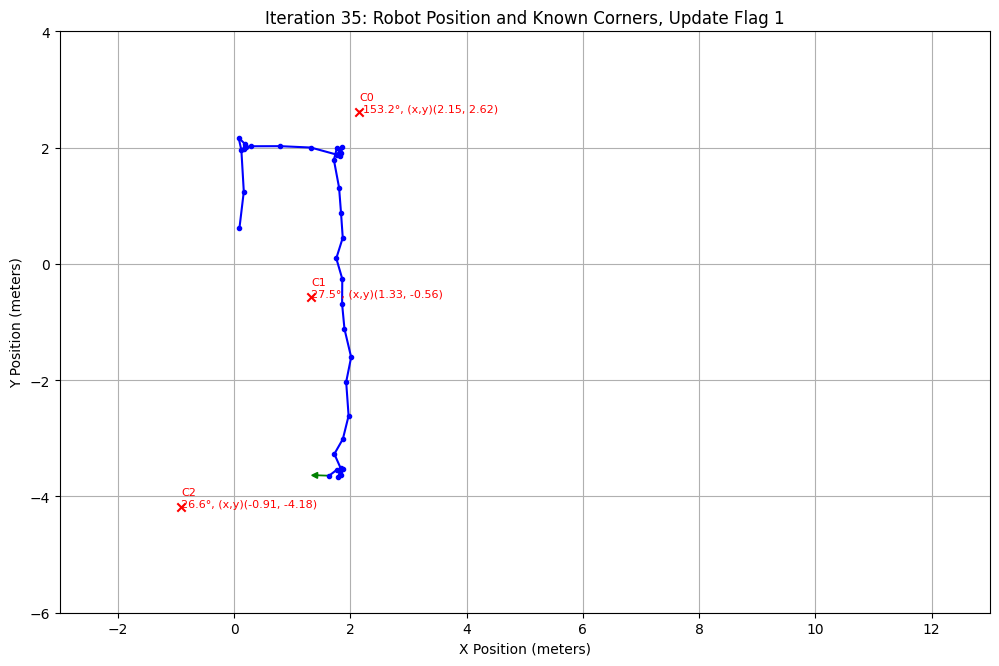

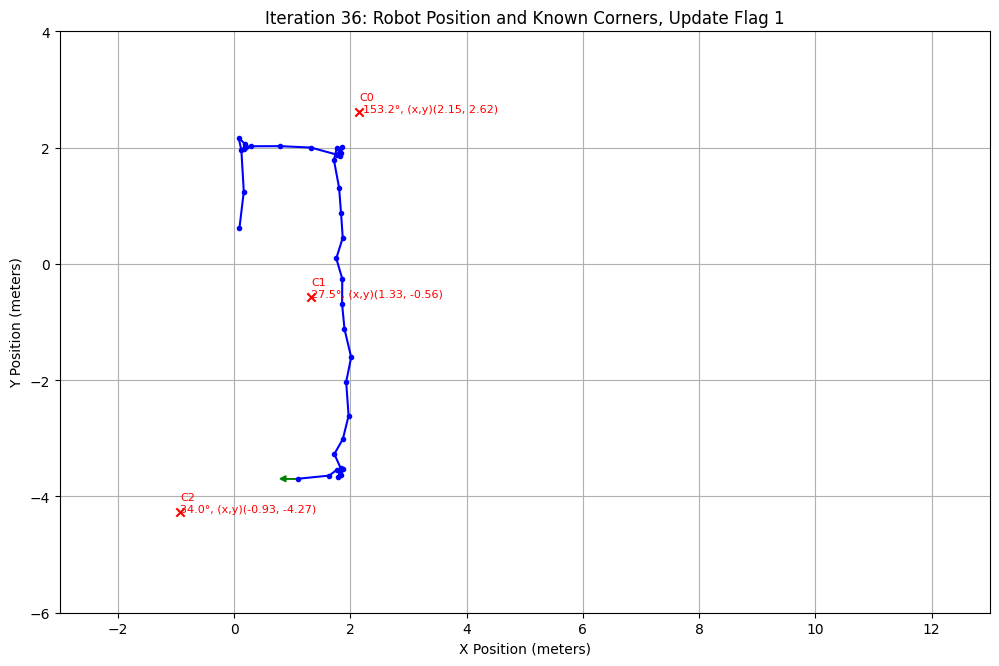

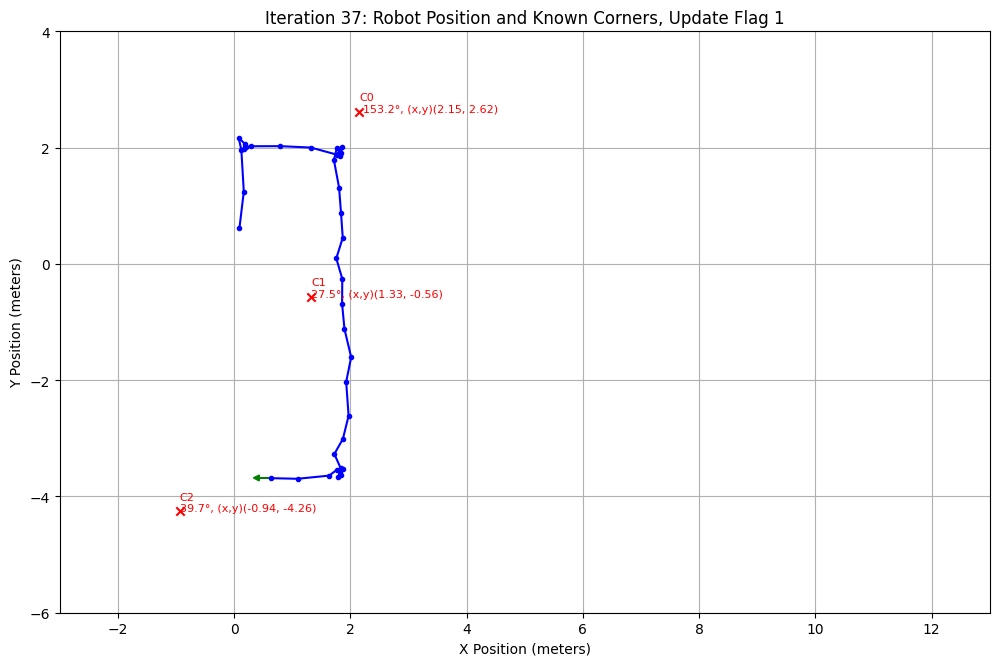

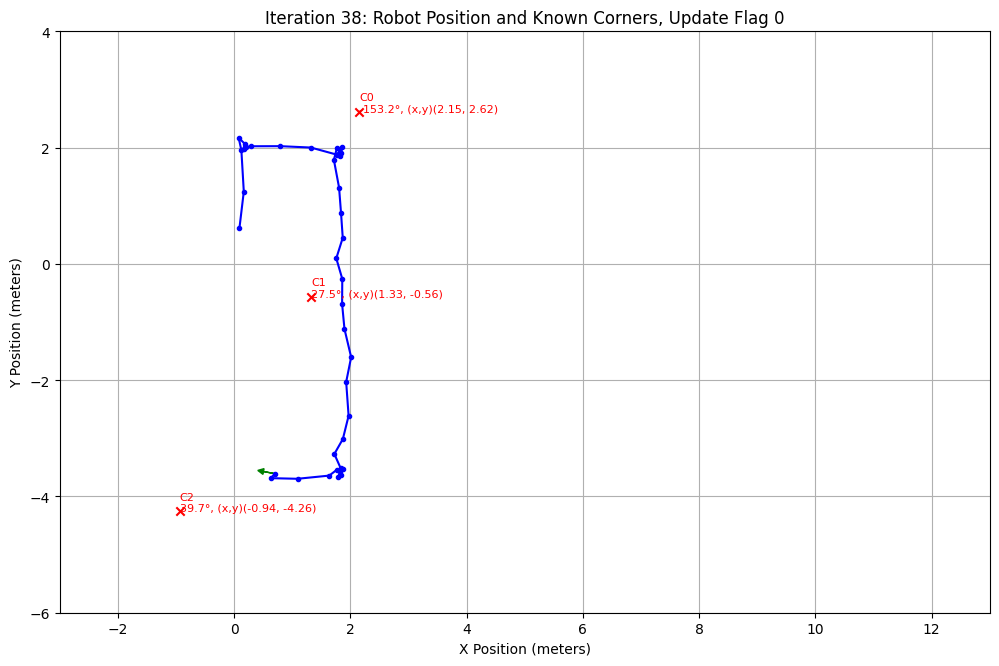

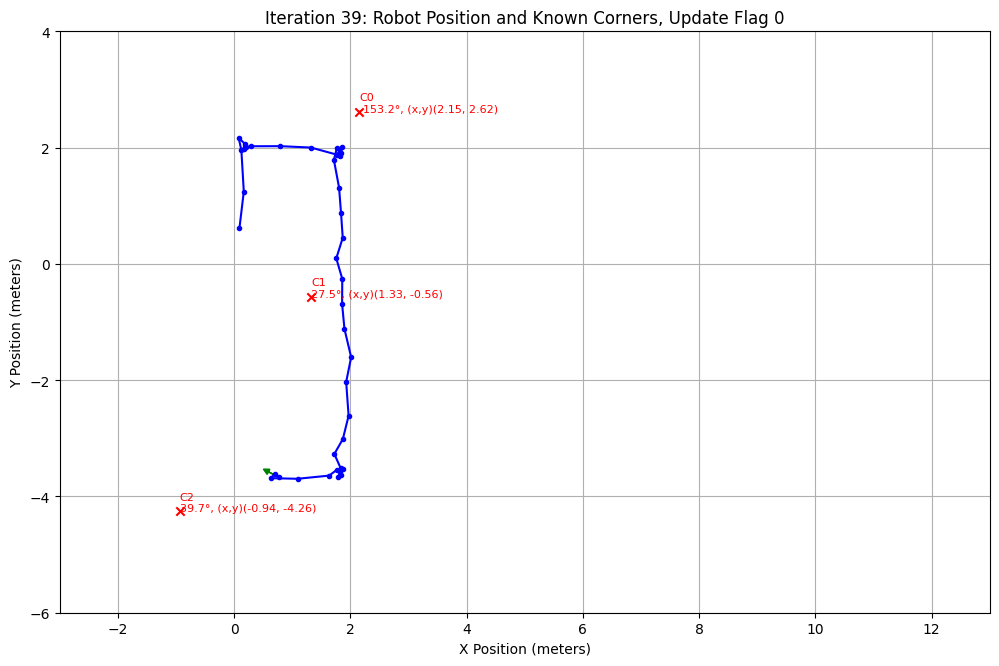

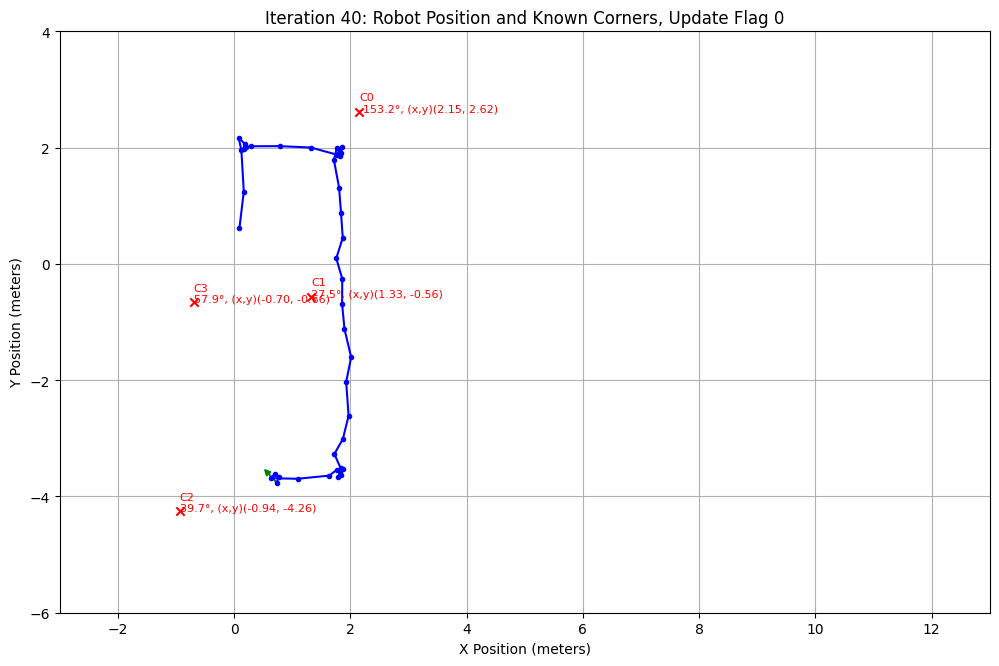

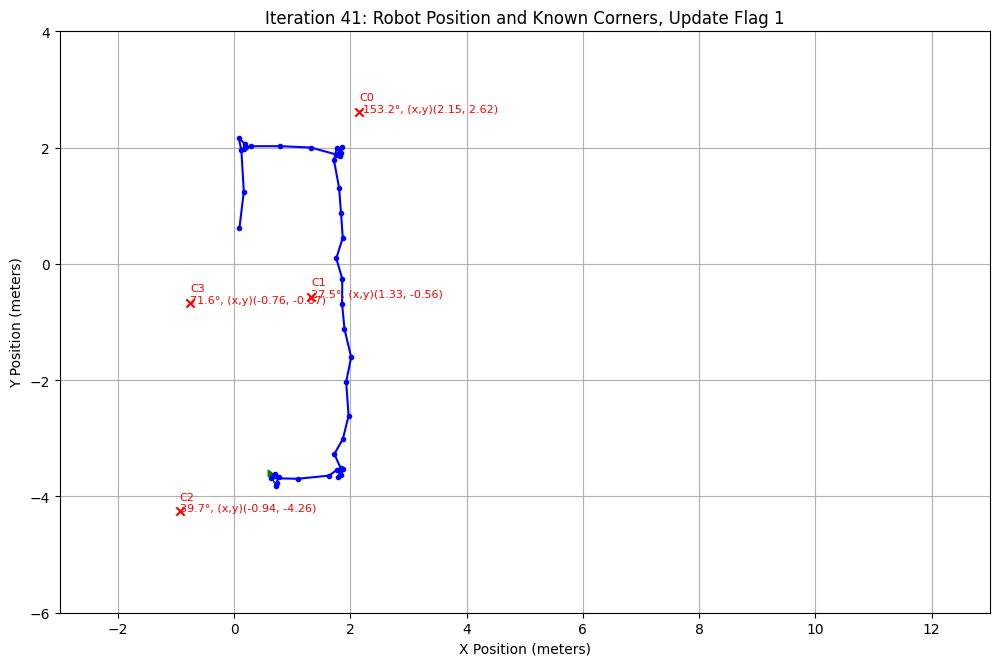

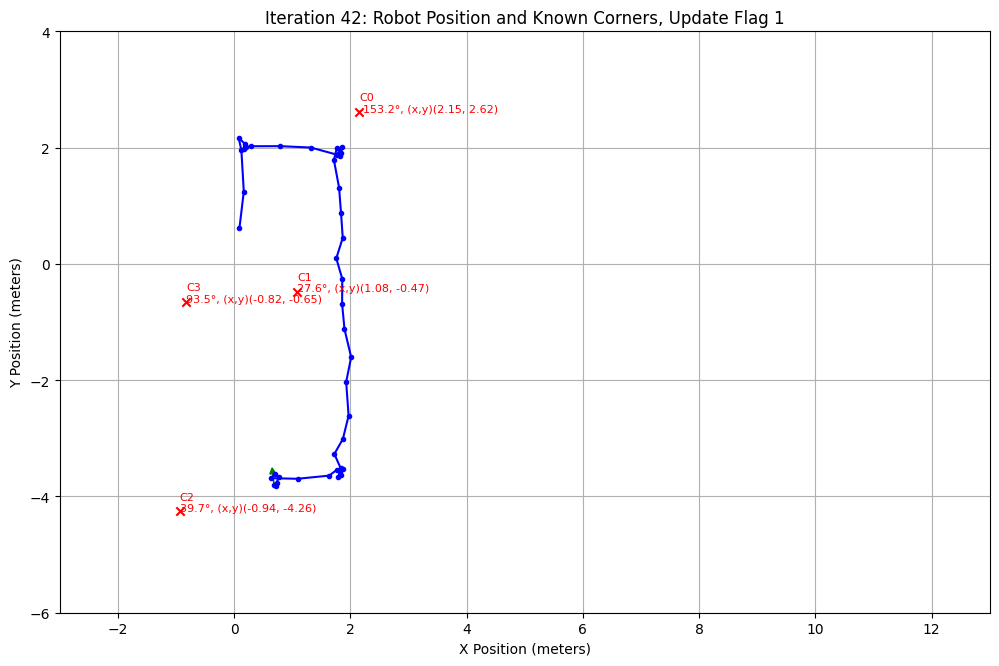

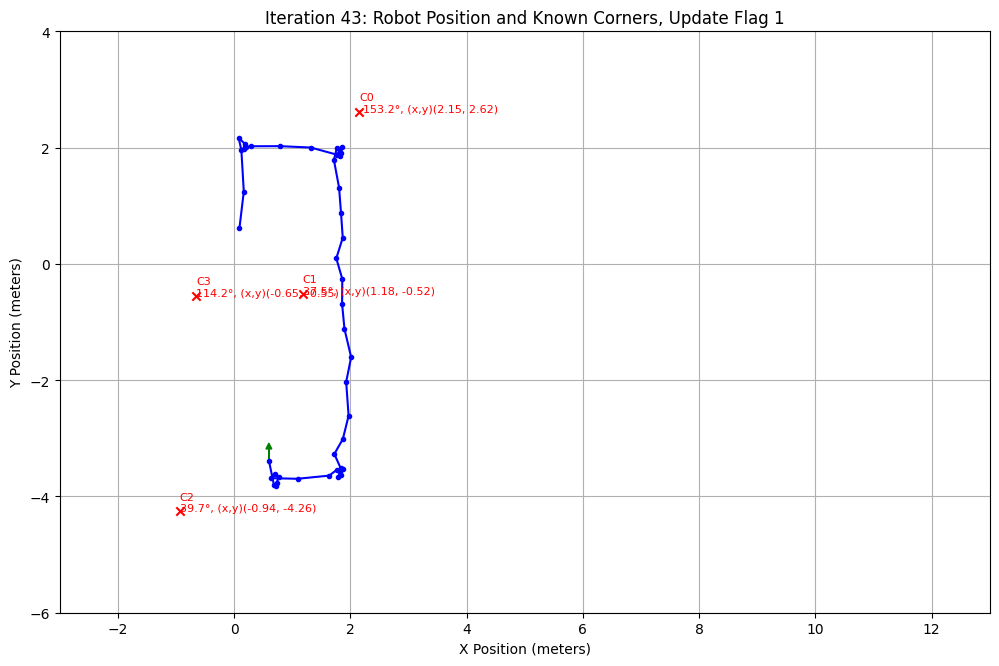

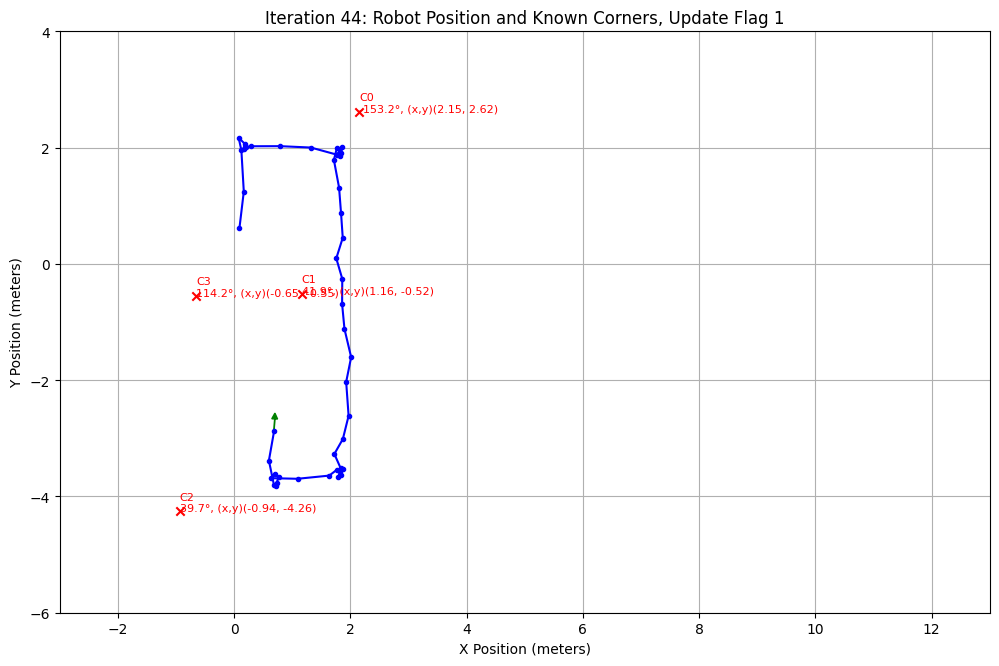

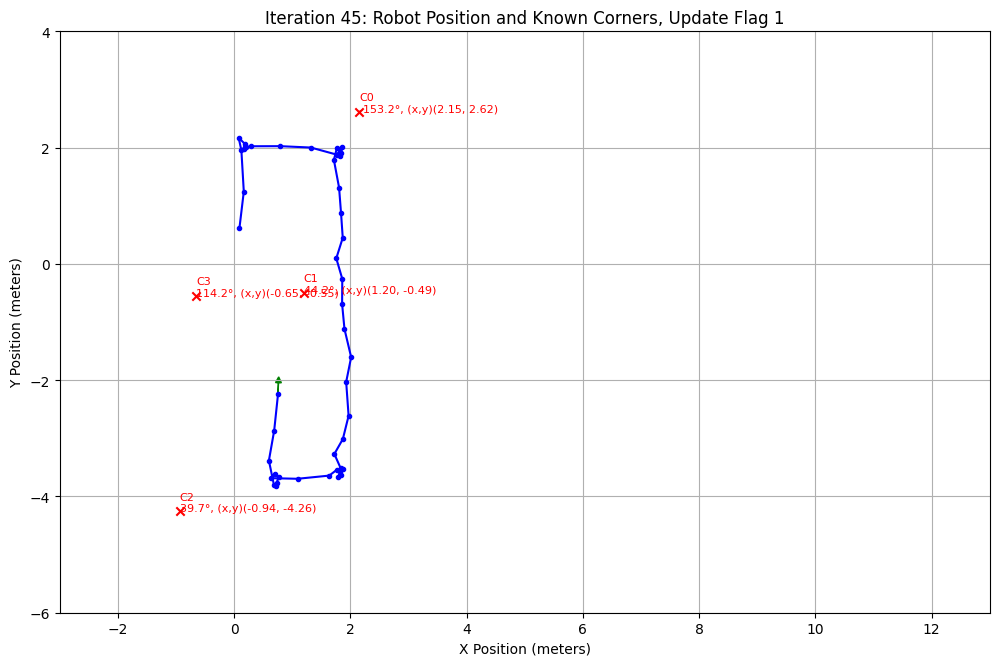

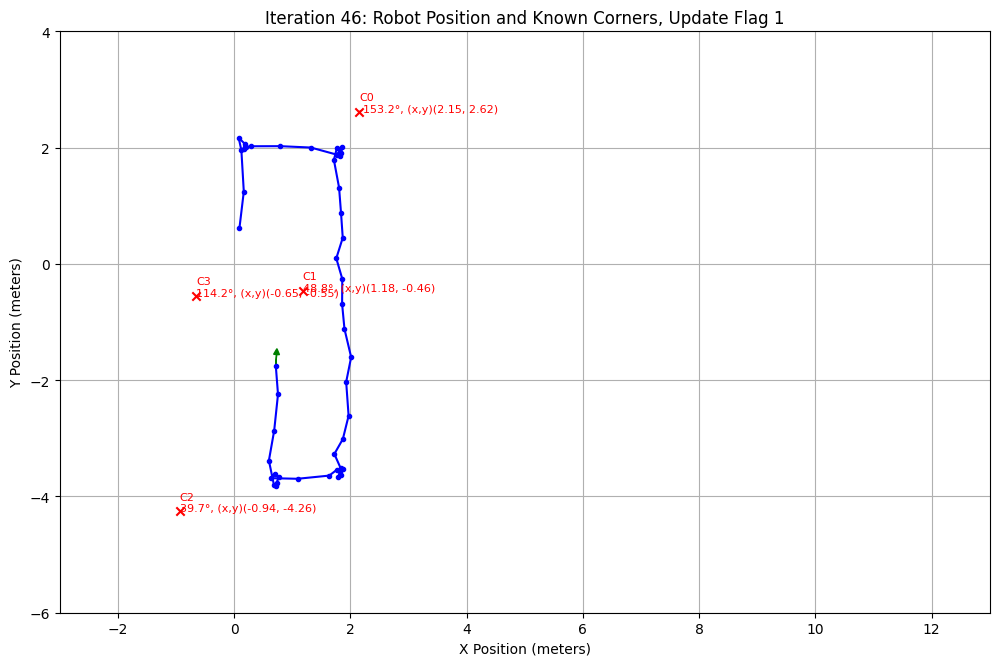

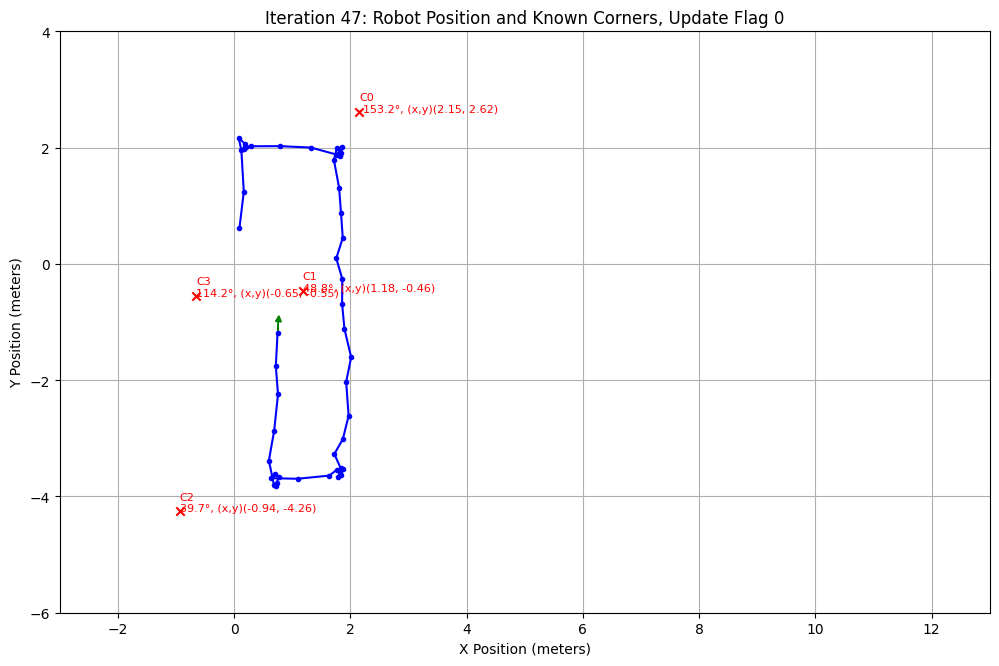

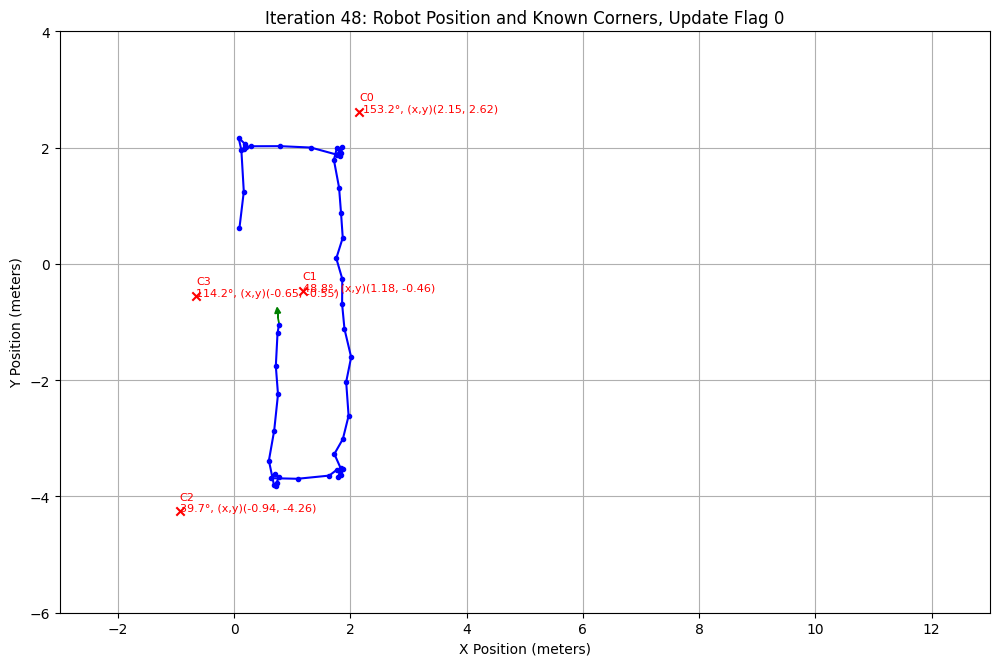

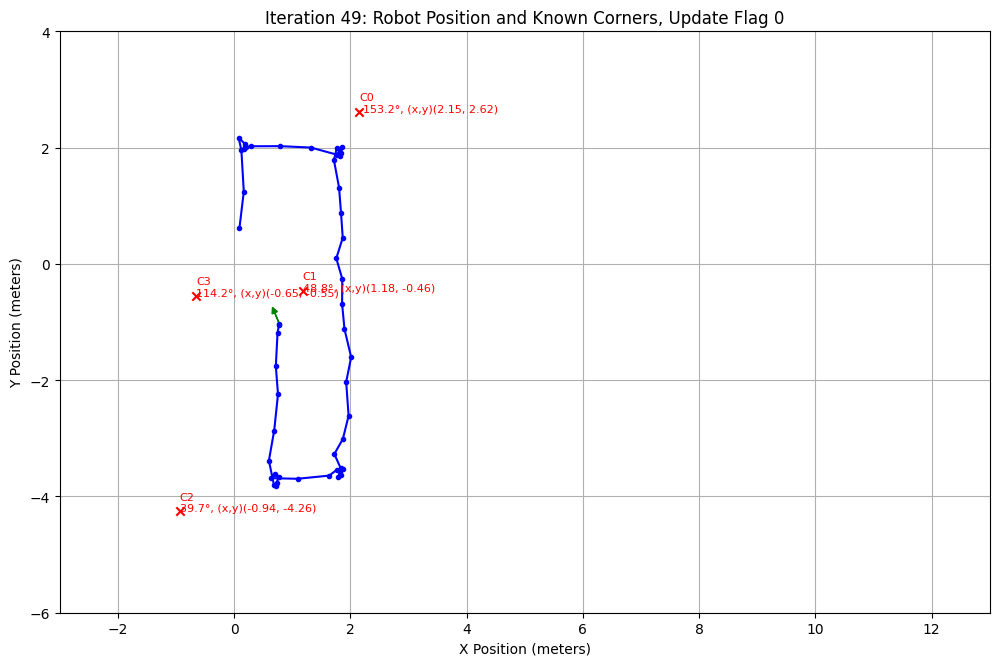

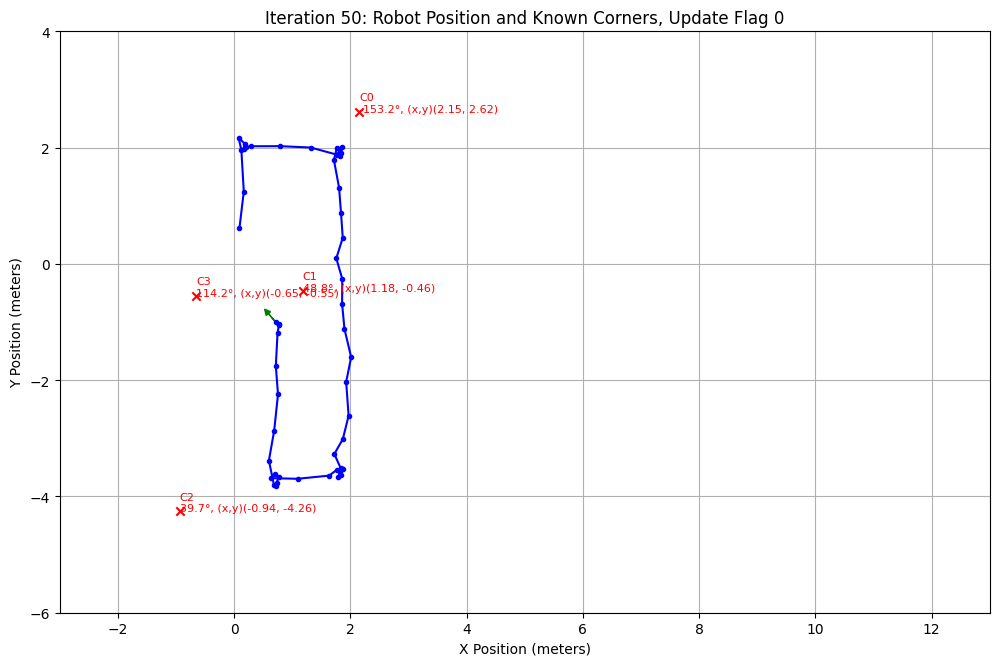

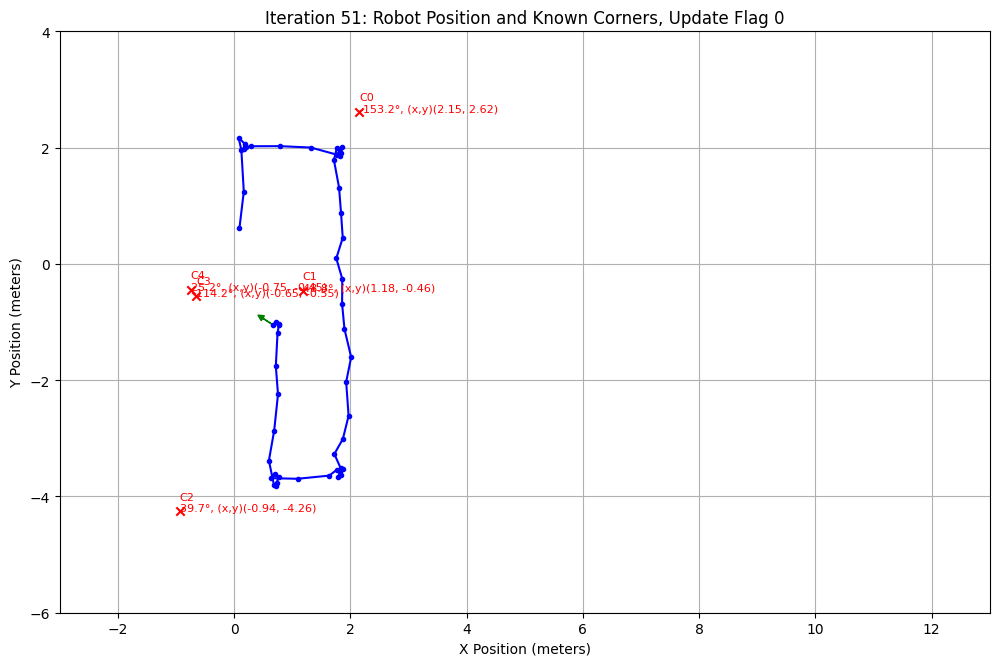

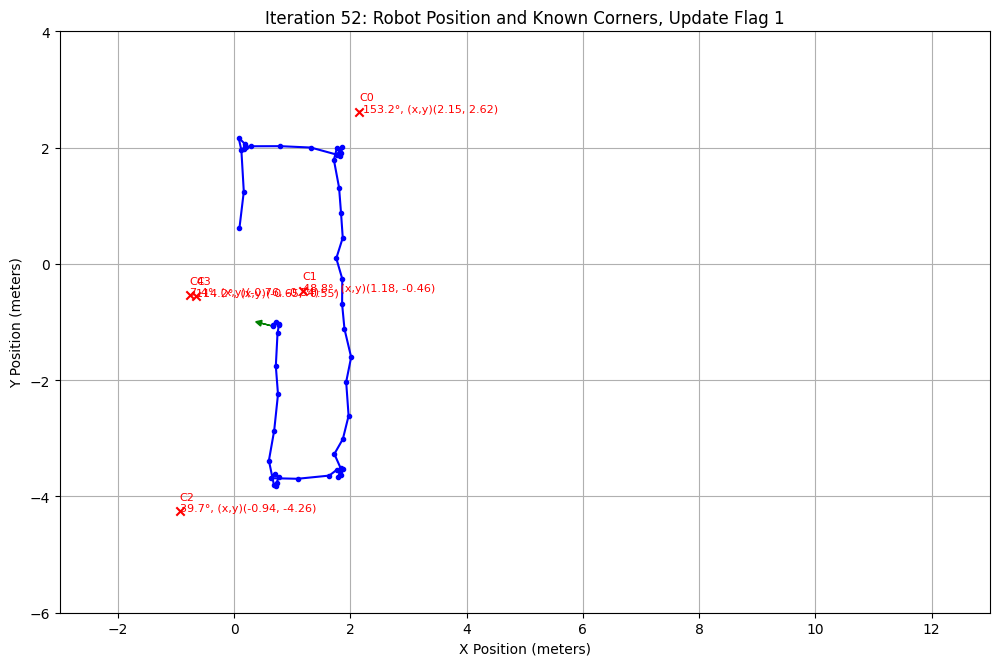

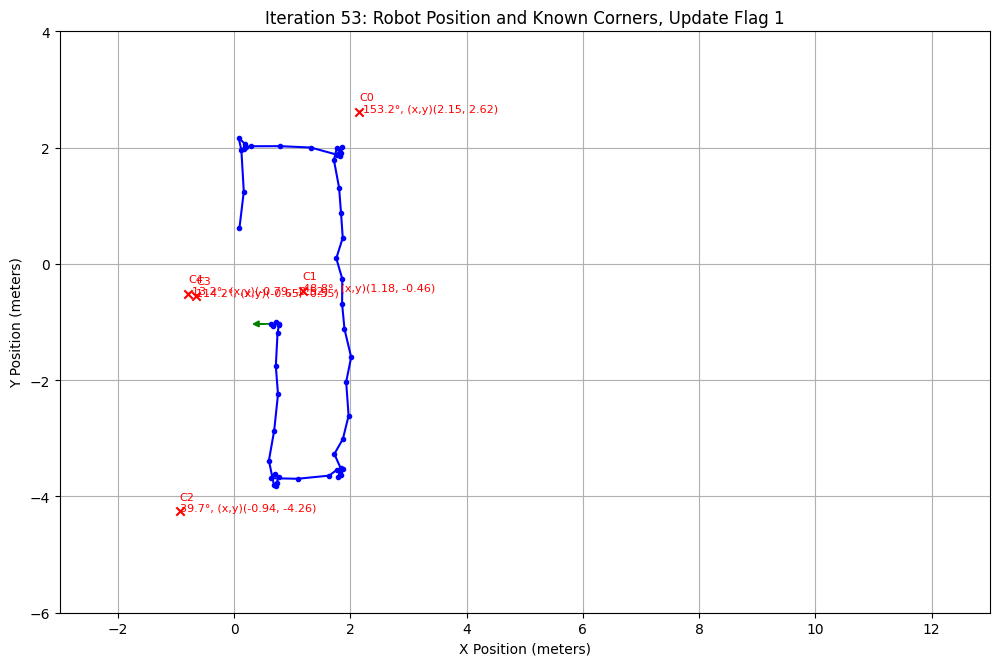

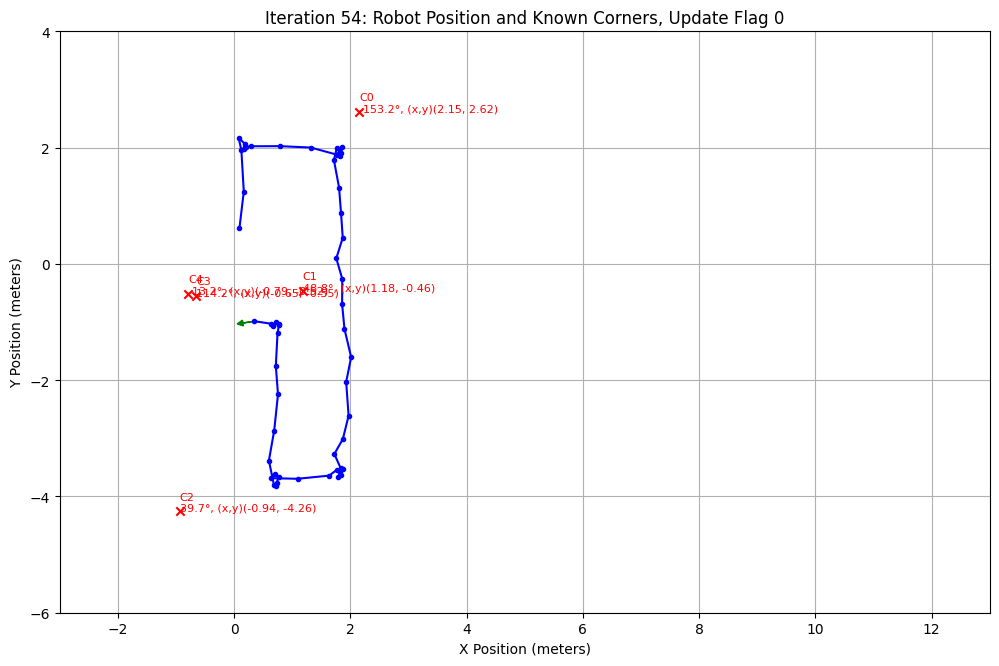

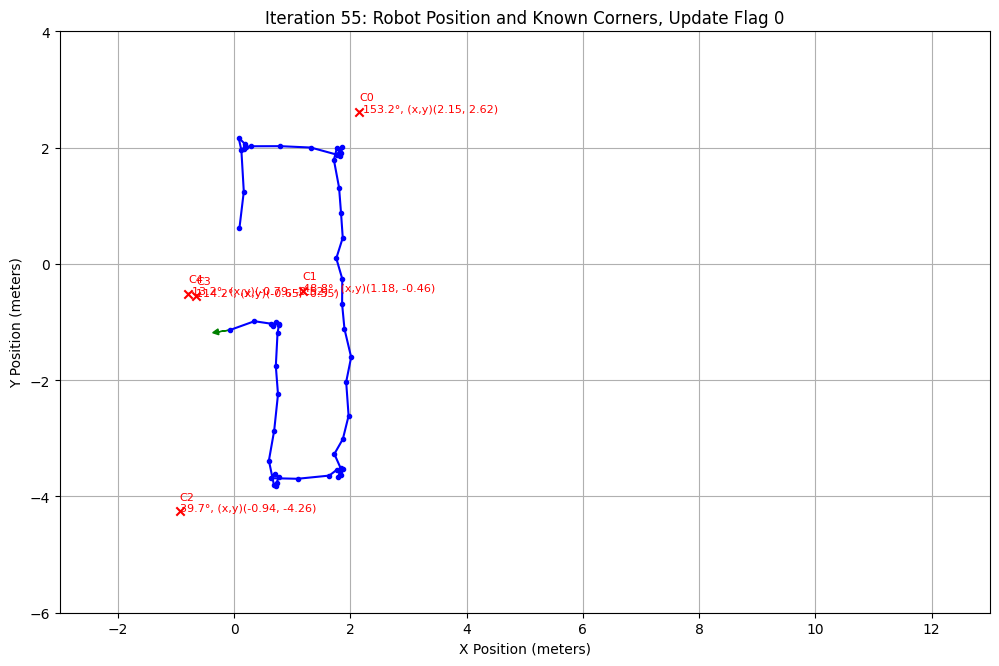

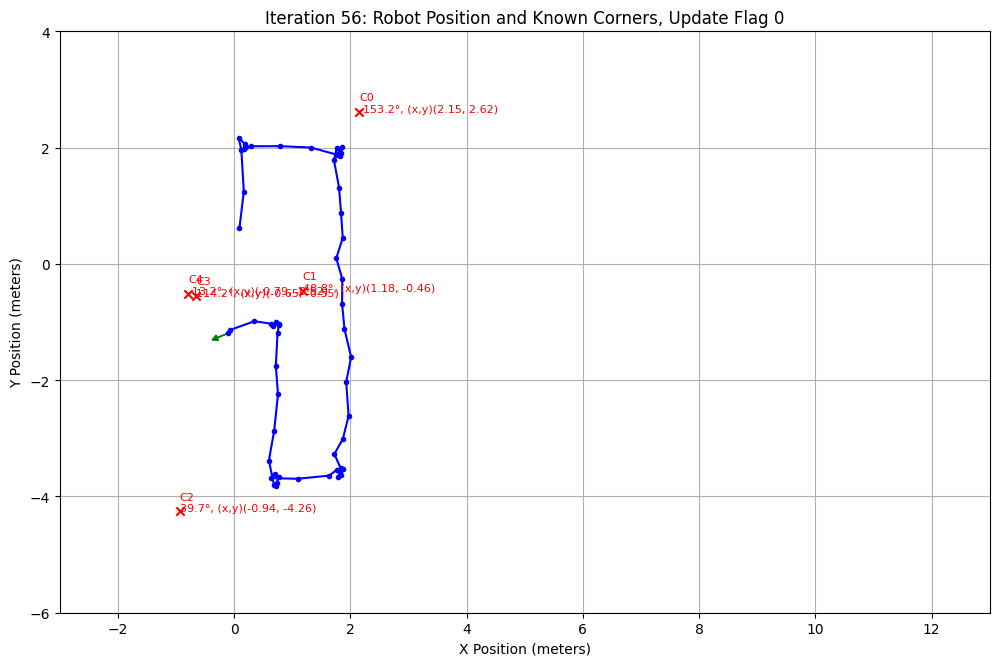

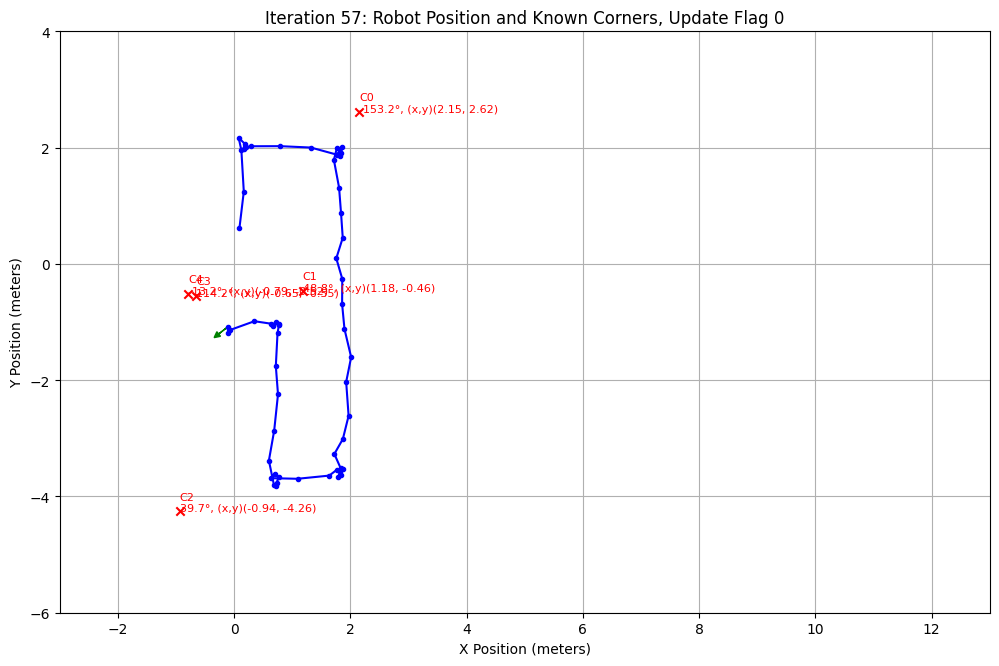

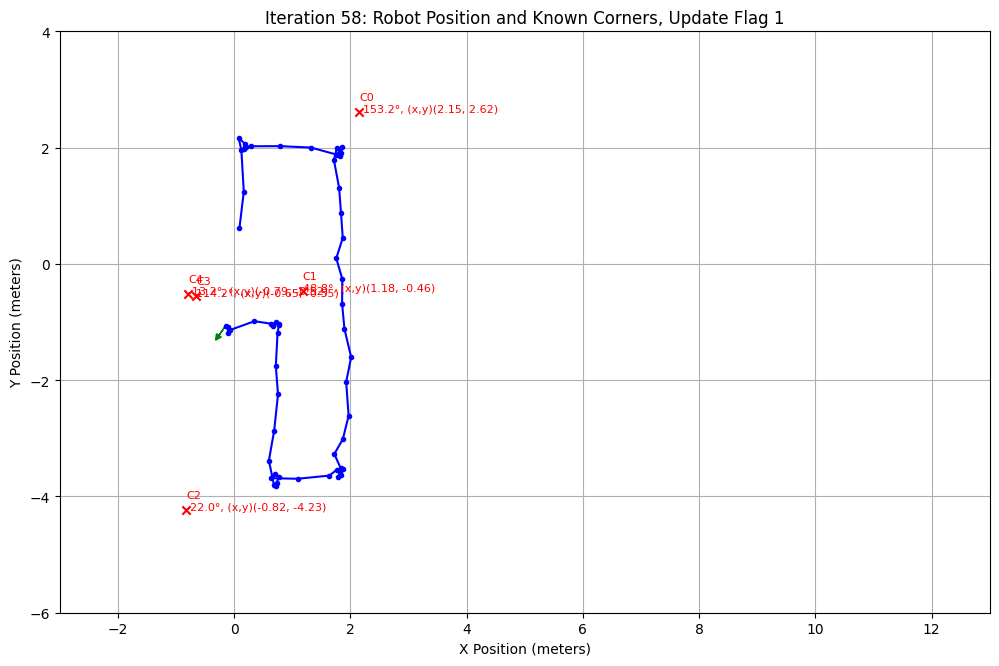

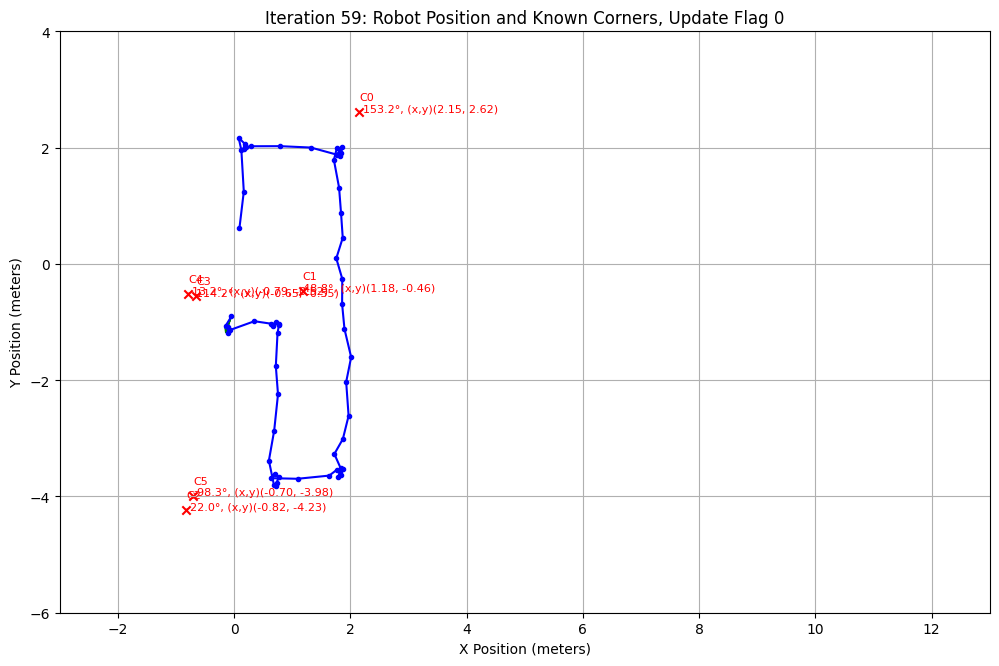

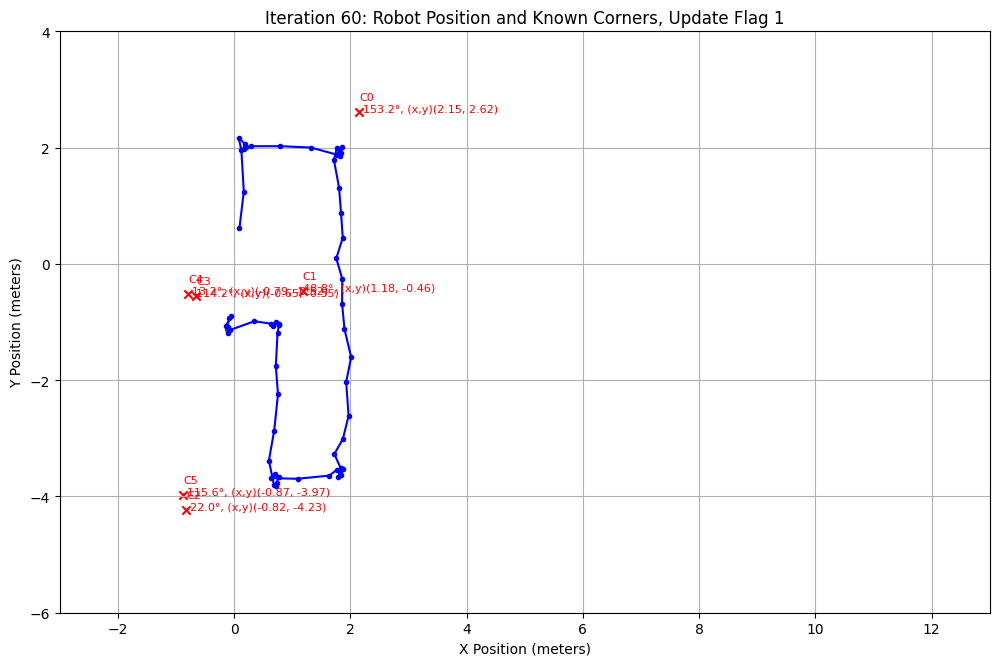

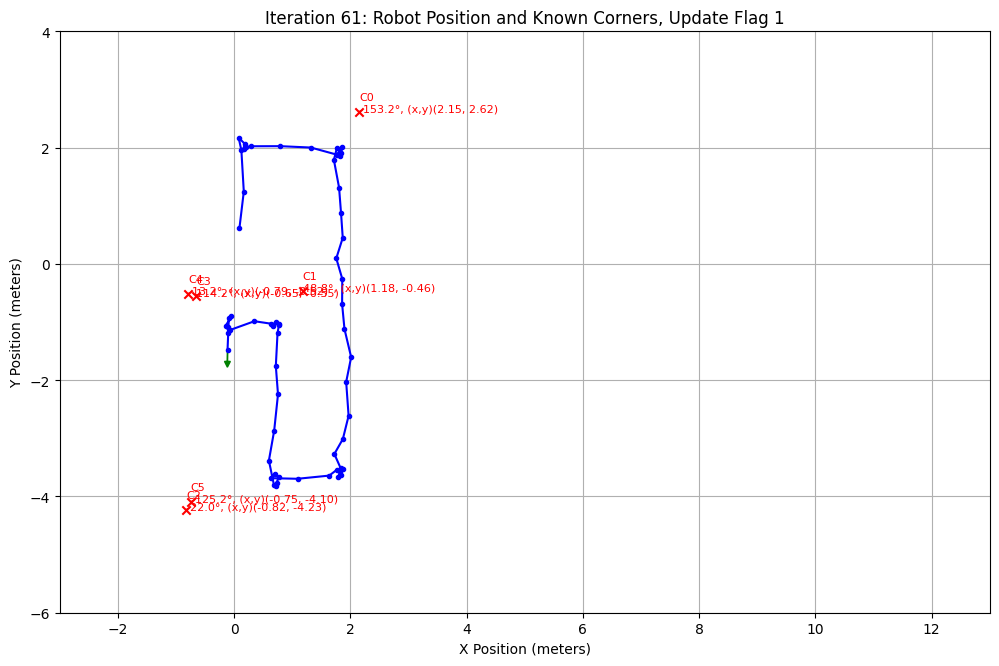

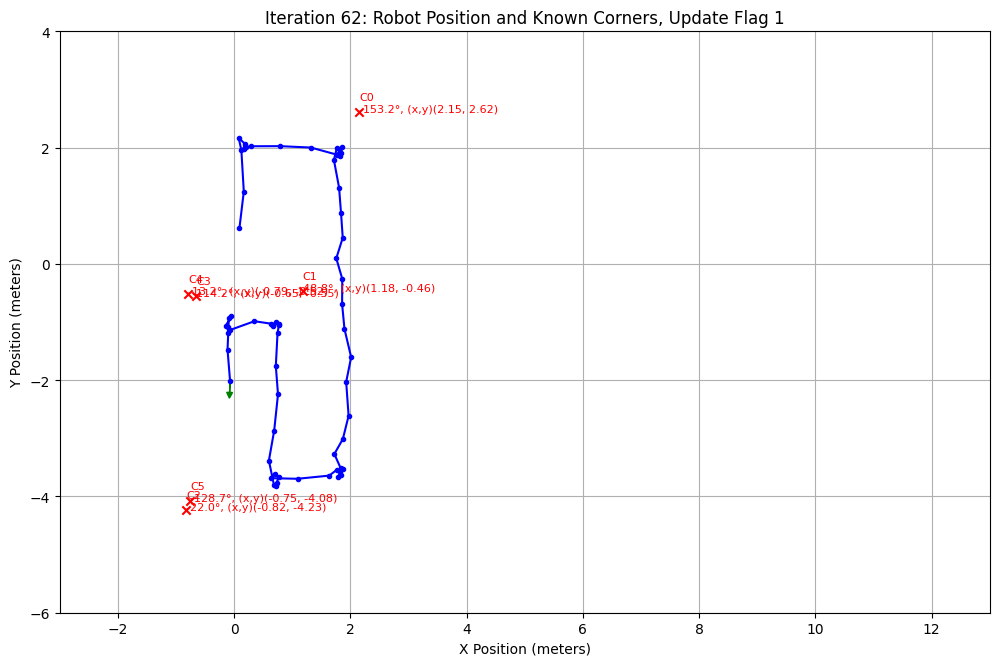

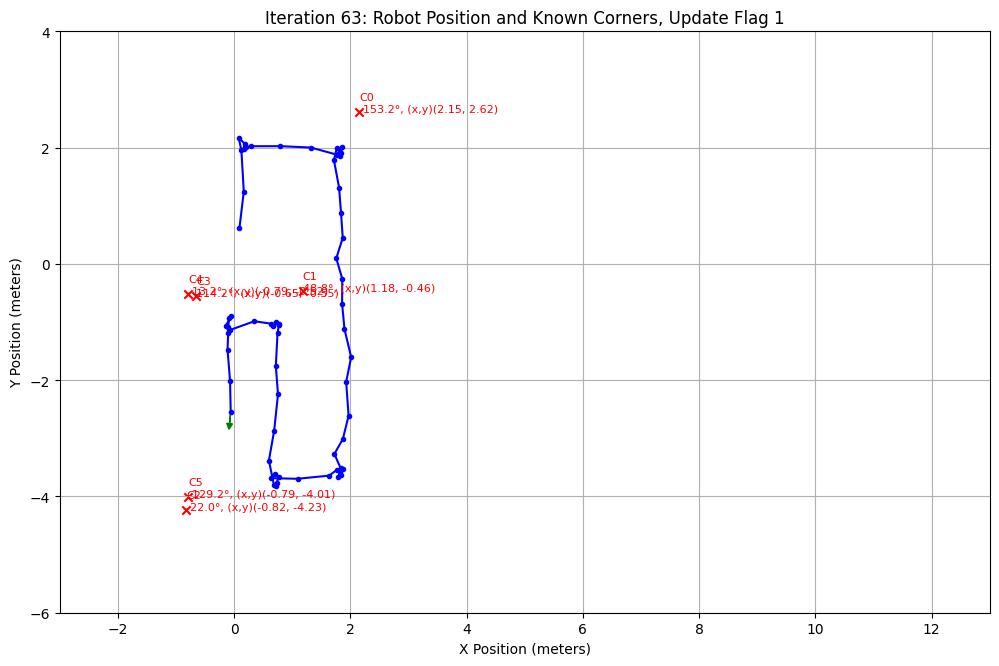

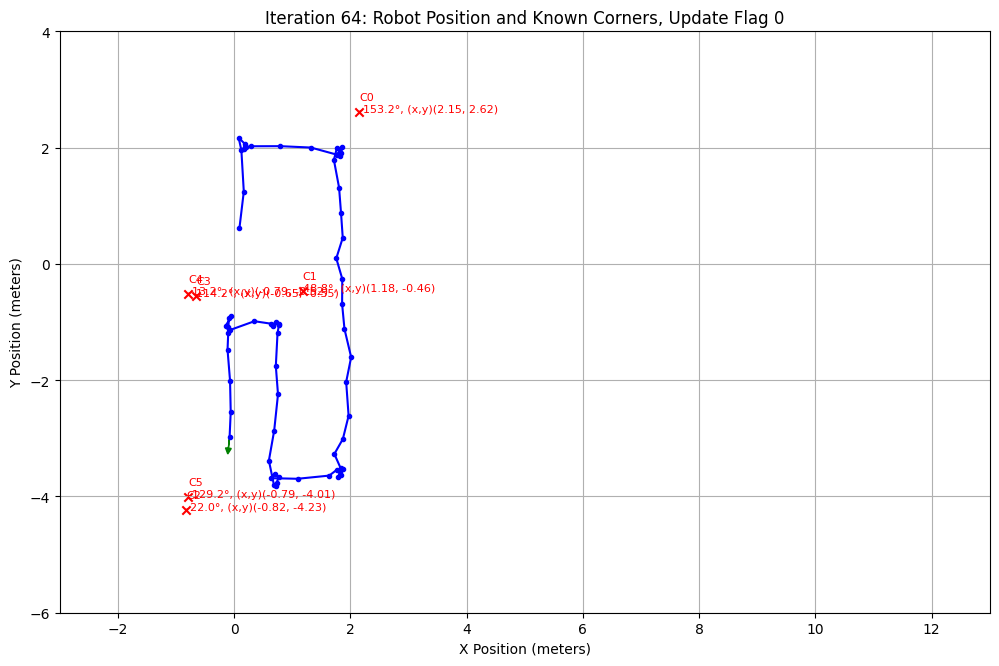

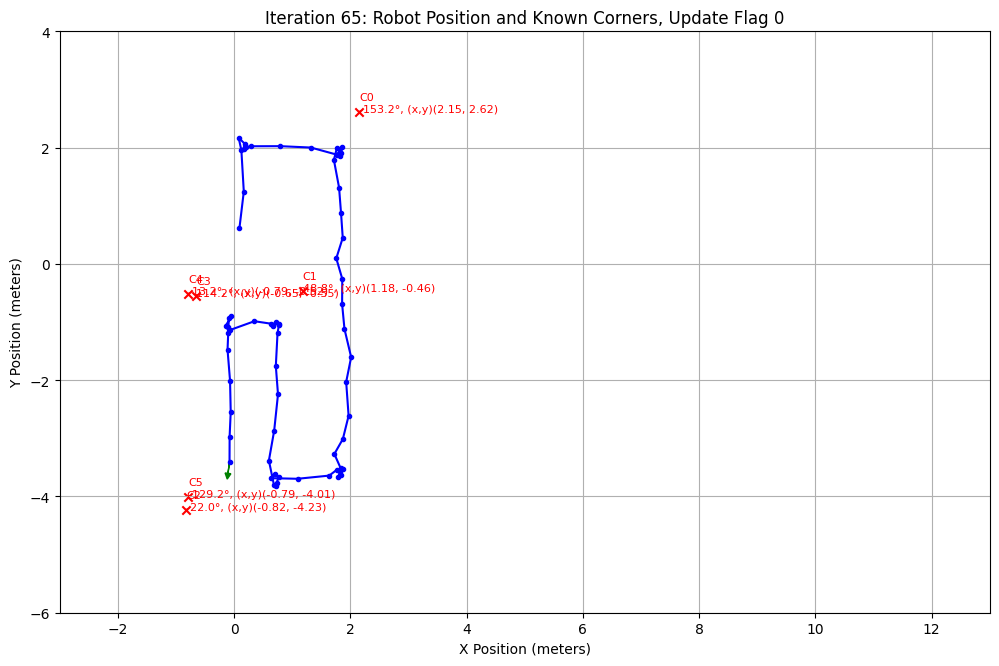

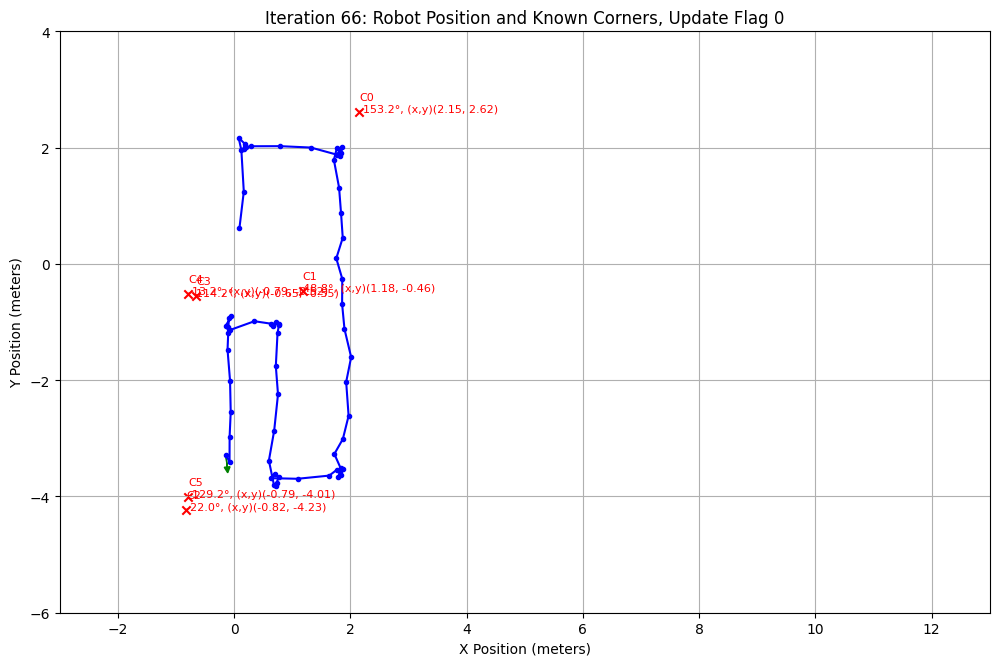

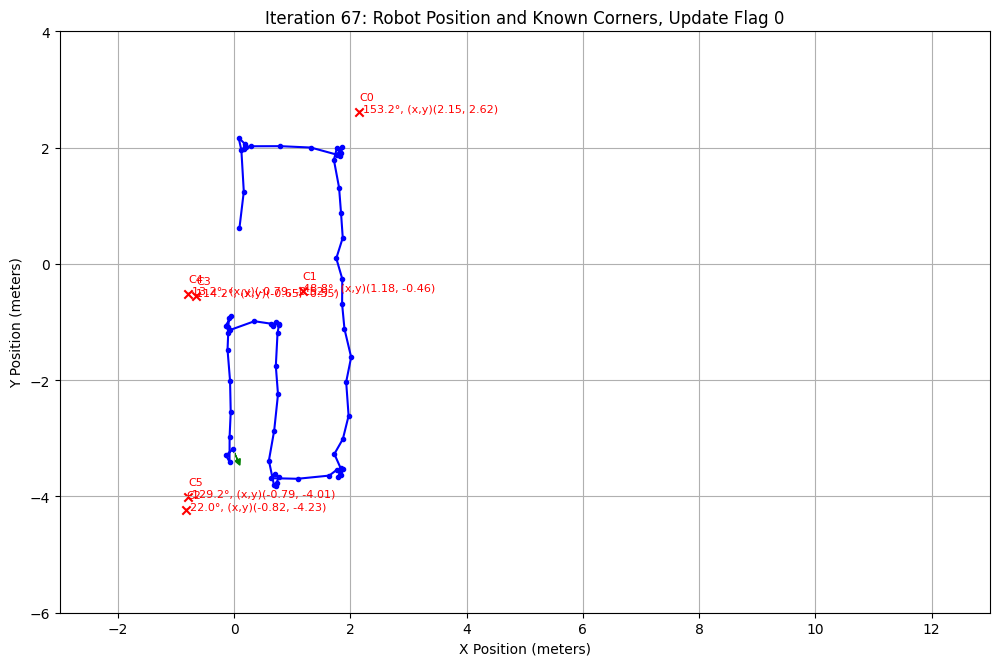

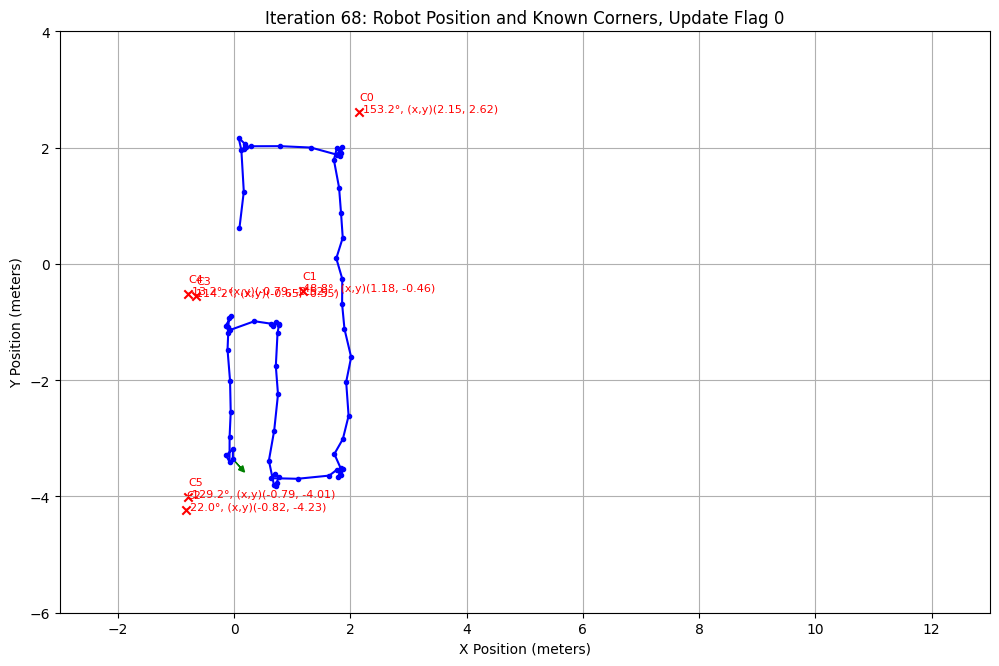

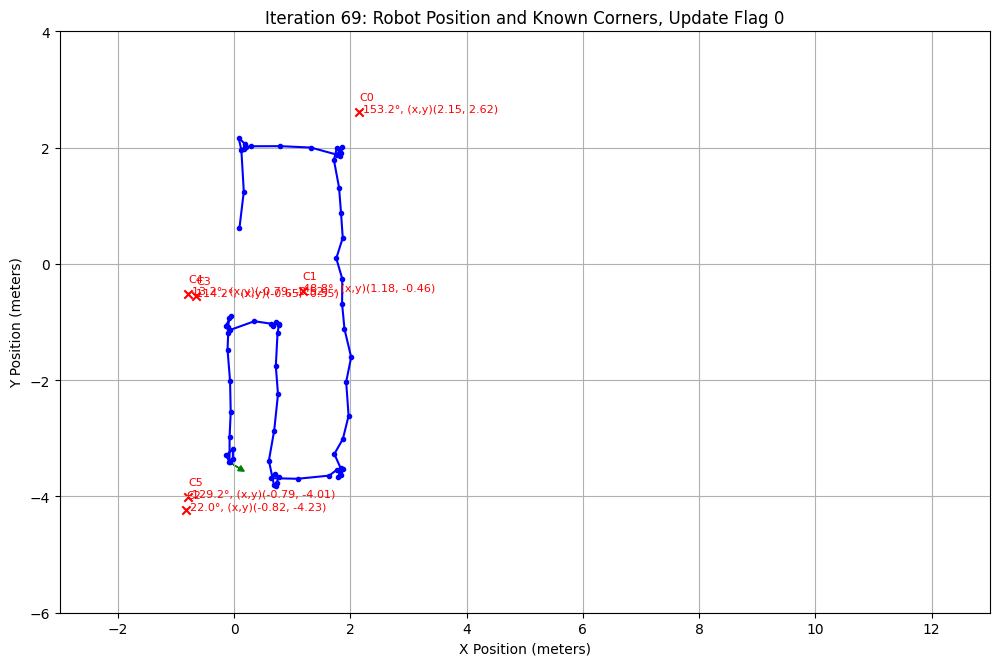

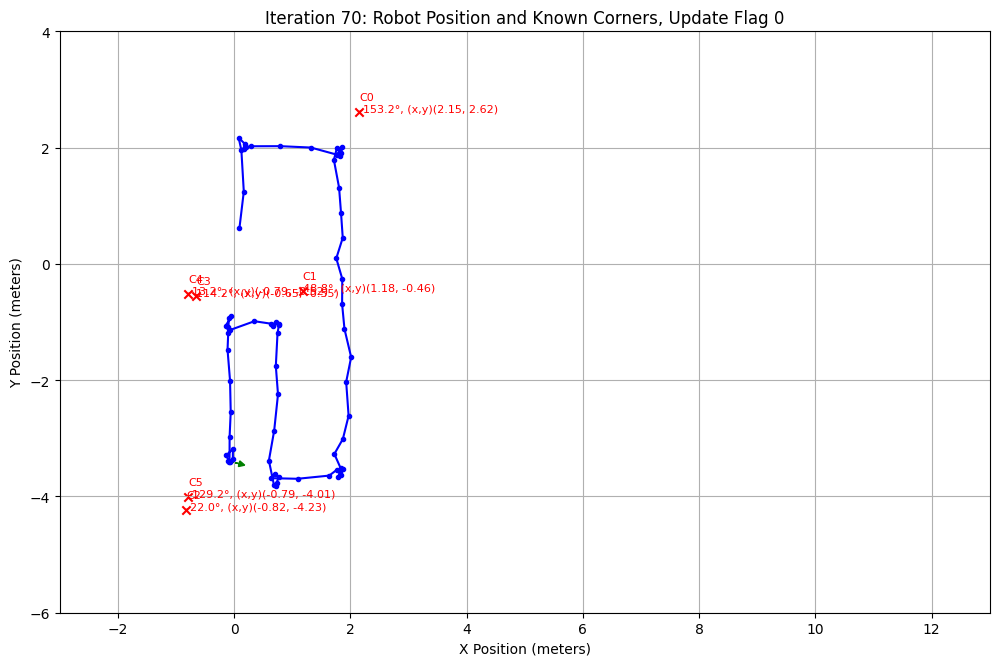

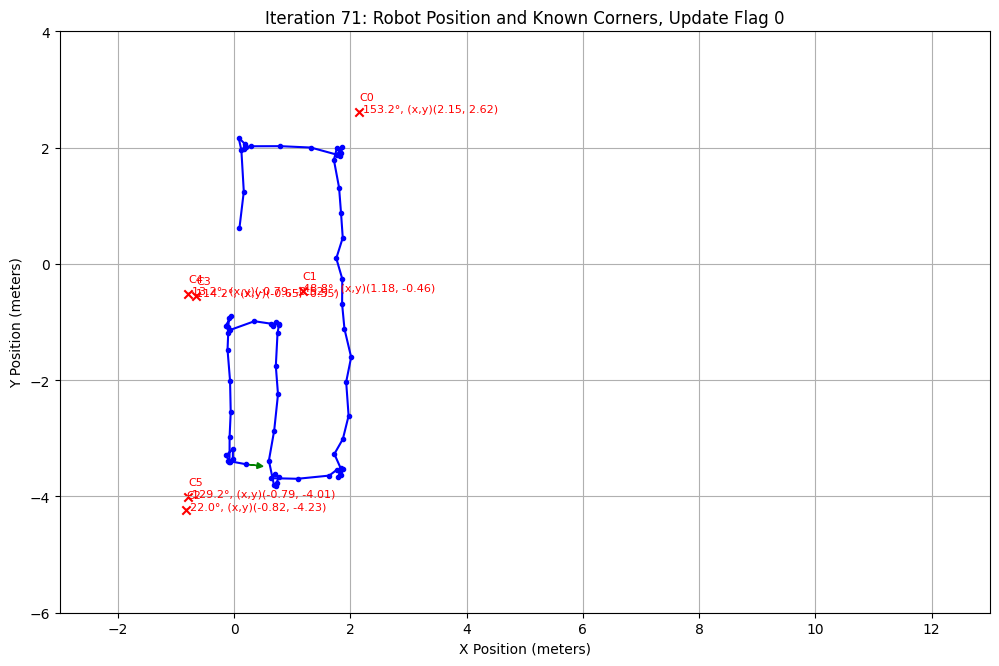

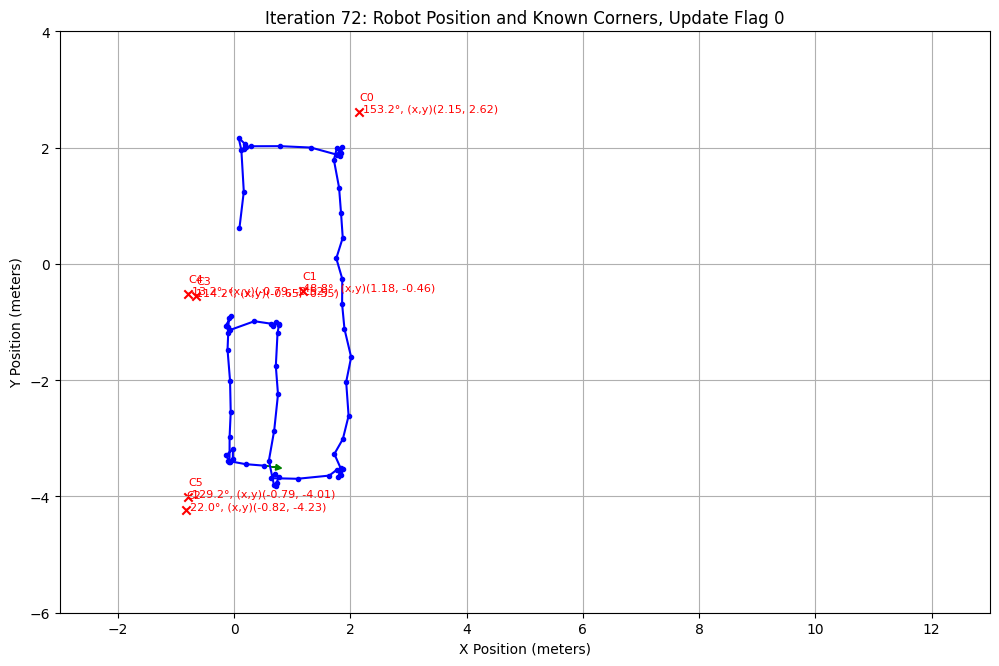

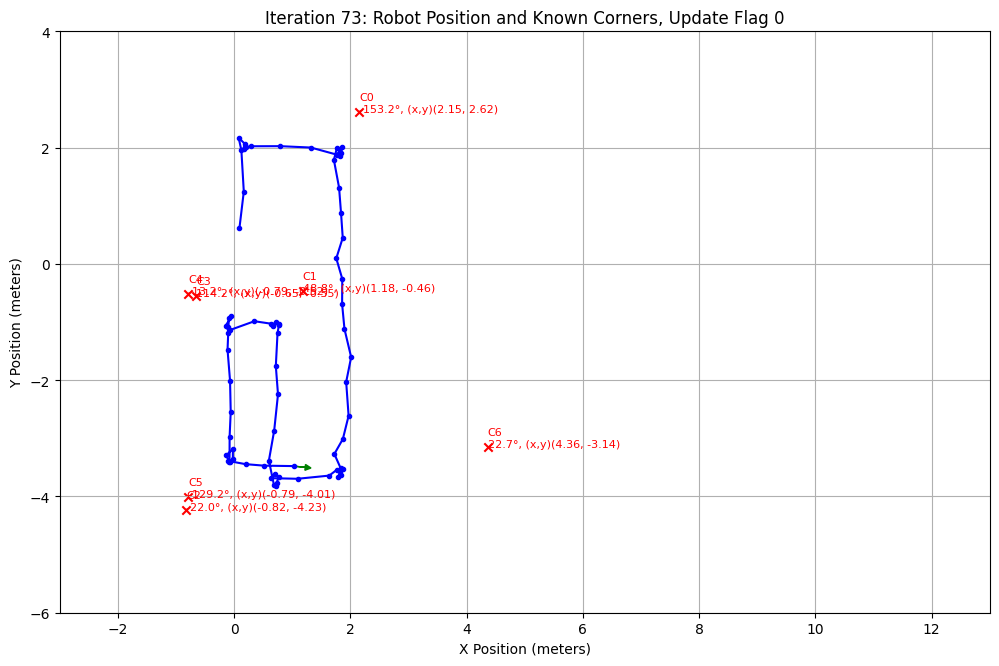

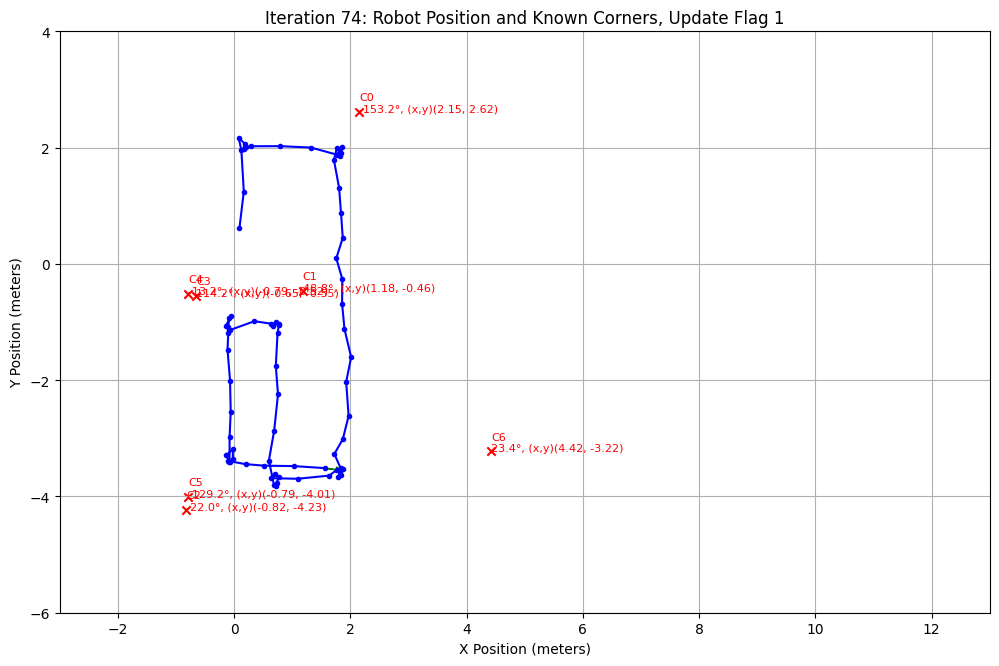

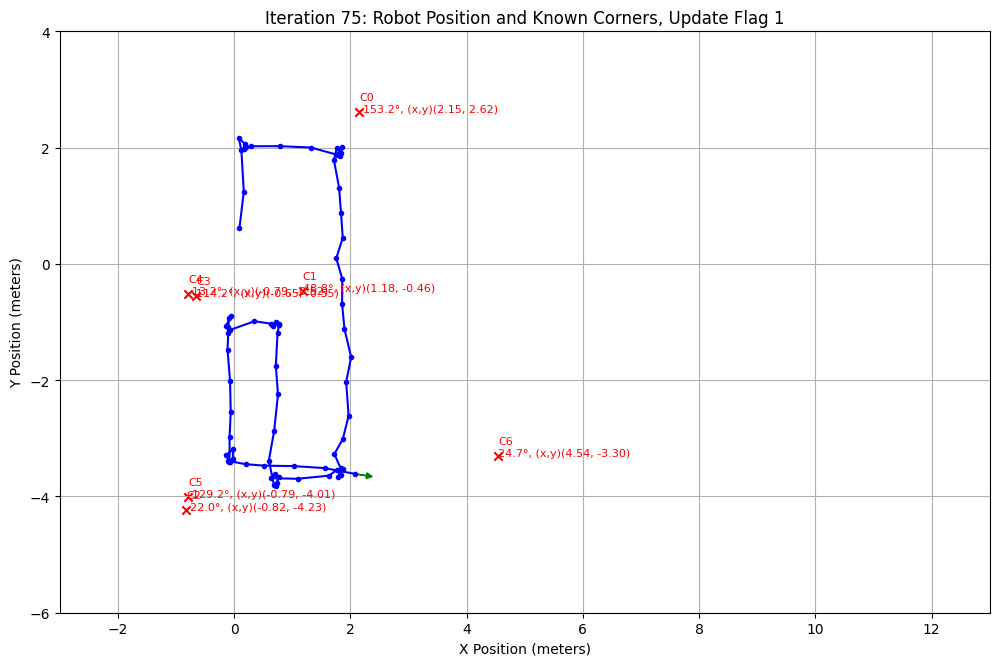

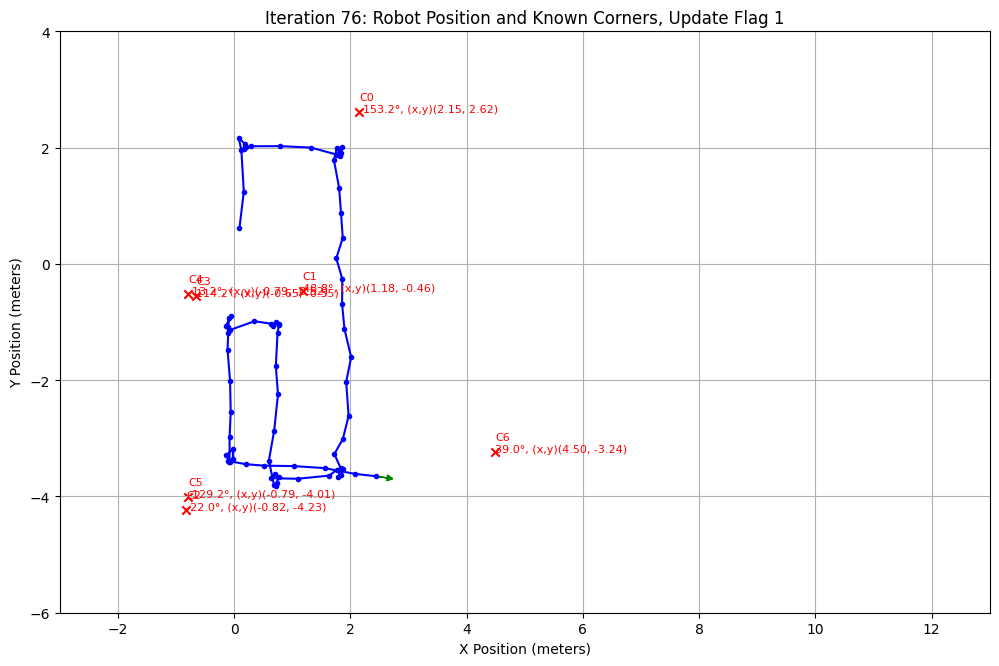

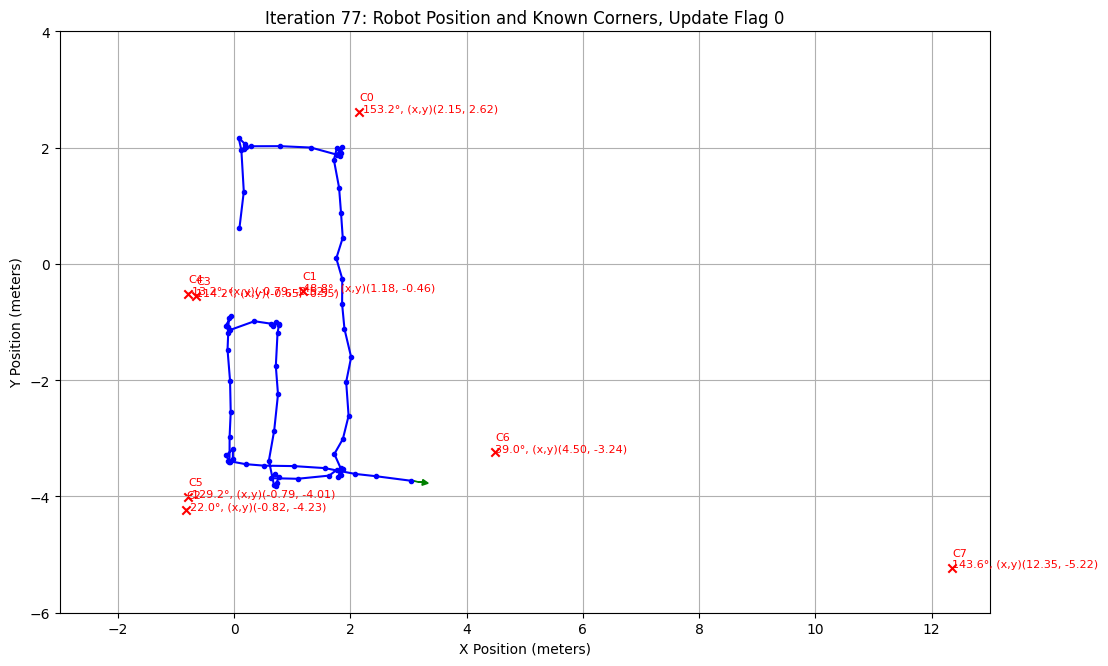

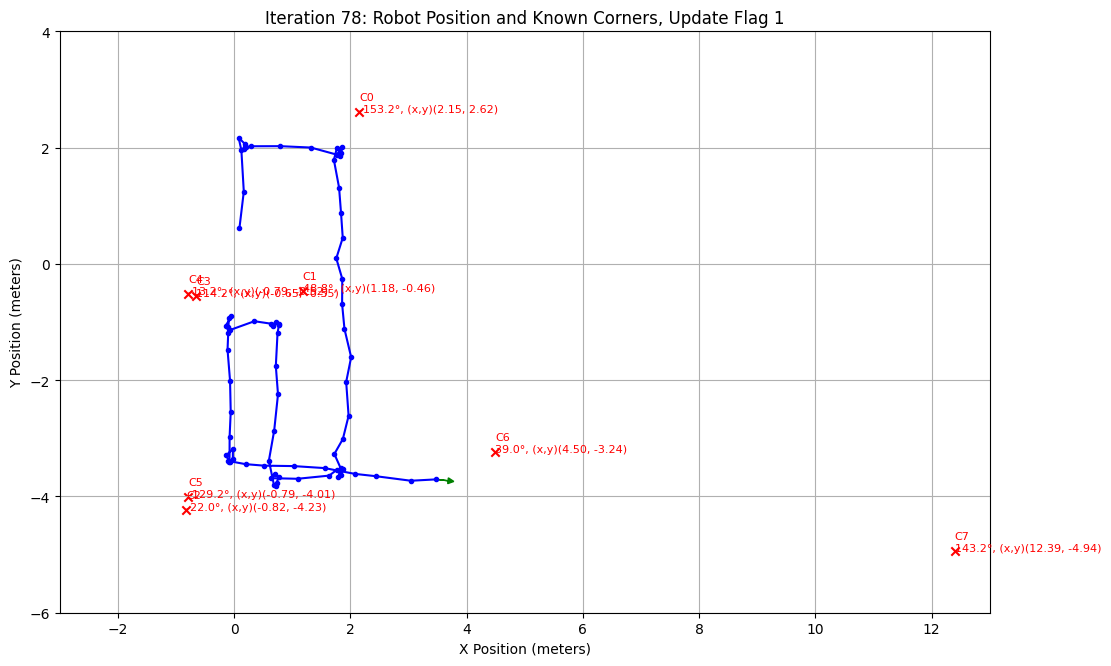

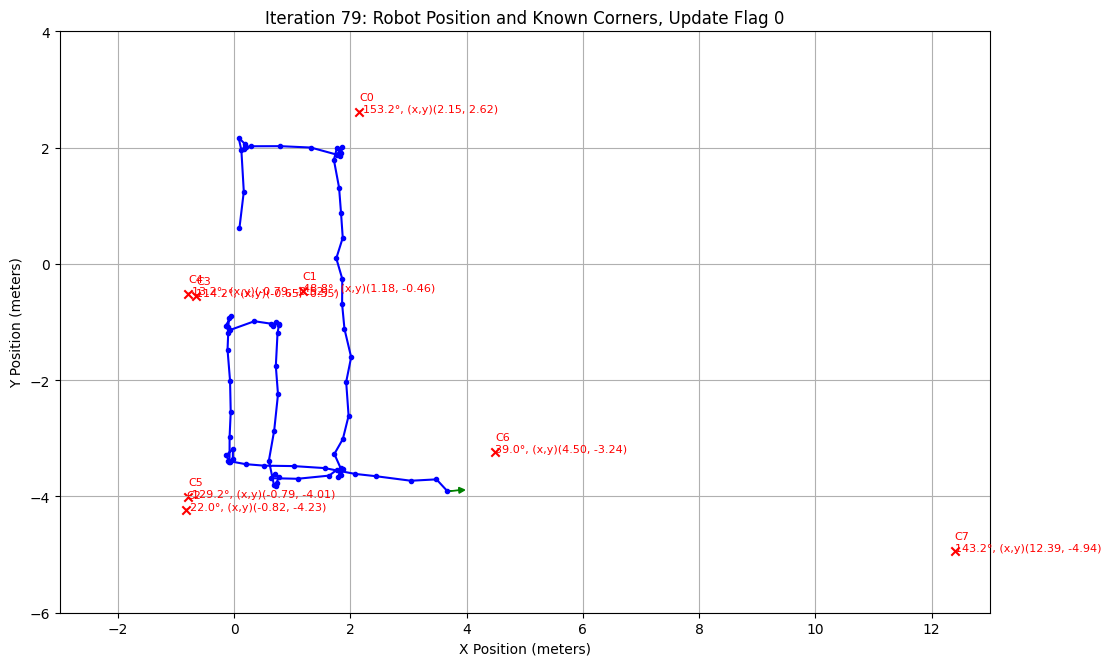

KeyboardInterrupt: 

In [119]:
initial_pose = np.array([0.0, 0.0, np.pi / 2])  # Robô começa em (0, 0, pi/2)
P = np.diag([0.2, 0.2, 0.2])

cov_q=0.0005 #Odometry

Q = np.diag([cov_q**2, cov_q**2, (cov_q*2)**2])

def update_pose(pose, delta_pose):
    x, y, theta = pose
    dx, dy, dtheta = delta_pose

    # Atualizar a pose
    new_x = x + dx
    new_y = y + dy
    new_theta = theta + dtheta

    return np.array([new_x, new_y, new_theta])

def lidar_to_global(pose, lidar_distances, angles):
    x_robot, y_robot, theta_robot = pose
    lidar_coords_global = []

    for distance, angle in zip(lidar_distances, angles):
        x_local = distance * np.cos(angle)
        y_local = distance * np.sin(angle)

        rotation_matrix = np.array([
            [np.cos(theta_robot), -np.sin(theta_robot)],
            [np.sin(theta_robot), np.cos(theta_robot)]
        ])

        lidar_local = np.array([x_local, y_local])
        lidar_global = rotation_matrix.dot(lidar_local)
        lidar_global += np.array([x_robot, y_robot])

        lidar_coords_global.append(lidar_global)

    return np.array(lidar_coords_global)


def is_known_corner(new_corner, pose_covariance, known_corners, known_corners_angles, known_corners_types, corner_angle, corner_type, base_threshold=0.1):
    """
    Verifies if a new corner is close to a known corner, using a dynamically scaled distance threshold.
    :param new_corner: Coordinates of the new corner (x, y).
    :param known_corners: List of known corners [(x1, y1), ...].
    :param pose_covariance: Covariance matrix (3x3) of the robot's pose.
    :param base_threshold: Base distance threshold.
    :return: Index of the known corner or -1 if no match is found.
    """
    # Extract position-related variances from pose covariance
    position_std = np.sqrt(pose_covariance[0, 0] + pose_covariance[1, 1])  # Combined std dev in x and y
    #dynamic_threshold = 8 * position_std  # Scale with a multiple of std dev
    dynamic_threshold = 0.9
    for i, (known_corner, known_corner_angle, known_corner_type) in enumerate(zip(known_corners, known_corners_angles, known_corners_types)):
        distance = np.linalg.norm(new_corner - known_corner)
        if distance < dynamic_threshold and np.abs(np.abs(known_corner_angle)-np.abs(corner_angle))<np.pi/4:
            return i
    return -1


def kalman_predict(state, P, delta_pose):
    x, y, theta = state
    dx, dy, dtheta = delta_pose
    predicted_state = np.array([
        x + dx ,
        y + dy ,
        normalize_angle(theta + dtheta)
    ])


    jacobian = np.eye(3)
    P = jacobian @ P @ jacobian.T + Q

    return predicted_state, P

def prune_inconsistent_features(features, observation_counts, angles, types, covariances, lifetimes, min_observations=3, grace_period=3):
    """
    Remove features observed fewer than min_observations times, unless they are within the grace period.
    :param features: List of known features [(x1, y1), ...].
    :param observation_counts: List of observation counts for each feature.
    :param angles: List of angles corresponding to the features.
    :param types: List of types corresponding to the features.
    :param covariances: List of covariance matrices for each feature.
    :param lifetimes: List of lifetimes for each feature.
    :param min_observations: Minimum number of observations to keep a feature.
    :param grace_period: Minimum lifetime before a feature can be pruned.
    :return: Updated features, observation_counts, angles, types, covariances, and lifetimes.
    """
    valid_indices = [
        i for i, (count, lifetime) in enumerate(zip(observation_counts, lifetimes))
        if count >= min_observations or lifetime < grace_period
    ]
    features = [features[i] for i in valid_indices]
    observation_counts = [observation_counts[i] for i in valid_indices]
    angles = [angles[i] for i in valid_indices]
    types = [types[i] for i in valid_indices]
    covariances = [covariances[i] for i in valid_indices]
    lifetimes = [lifetimes[i] for i in valid_indices]
    return features, observation_counts, angles, types, covariances, lifetimes

# Função para processar leituras LIDAR e variações da pose
def kalman_update(pose, P, lidar_data, angles, known_corners, corner_covariances):
    """
    Updates the robot's pose and the map with landmarks using LIDAR data and the Kalman filter.
    :param pose: Current robot pose [x, y, θ].
    :param P: Current pose covariance matrix.
    :param lidar_data: LIDAR distance readings (array of distances).
    :param angles: Angles corresponding to the LIDAR readings.
    :param known_corners: List of known corners [(x, y), ...].
    :param corner_covariances: List of covariance matrices for known corners.
    :return: Updated pose, updated known corners, updated pose covariance, updated corner covariances.
    """
    update_flag=0
    # Convert LIDAR data to global coordinates
    lidar_coords_global = lidar_to_global(pose, lidar_data, angles)

    # Detect corners in LIDAR data
    corners_indices, corners_type, corners_angle, corner_coords = detect_corners_douglas_peucker(lidar_data, angles)

    detected_corners = lidar_coords_global[corners_indices]

    new_P = P
    new_pose = pose

    for corner, corner_angle, corner_type in zip(detected_corners, corners_angle, corners_type):
        corner_angle_global = normalize_angle(corner_angle - pose[2])
        idx = is_known_corner(corner, P, known_corners, known_corners_angles, known_corners_types ,corner_angle_global, corner_type)
        if idx == -1:  # New corner
            known_corners.append(corner)
            known_corners_angles.append(corner_angle_global)
            known_corners_types.append(corner_type)
            corner_covariances.append(np.eye(2) * 0.05)  # Initialize covariance for the new landmark
            corner_observation_counts.append(1)
            corner_lifetimes.append(0)
        else:
            # Calculate expected measurement for the known corner
            update_flag=1
            corner_observation_counts[idx] += 1

            landmark = known_corners[idx]
            landmark_covariance = corner_covariances[idx]

            dist_p = np.sqrt((pose[0] - landmark[0])**2 + (pose[1] - landmark[1])**2)
            theta_p = normalize_angle(np.arctan2(landmark[1] - pose[1], landmark[0] - pose[0]) - pose[2])

            z = np.array([dist_p, theta_p])  # Expected measurement

            dist_p_e = np.sqrt((pose[0] - corner[0])**2 + (pose[1] - corner[1])**2)
            theta_p_e = normalize_angle(np.arctan2(corner[1] - pose[1], corner[0] - pose[0]) - pose[2])

            z_e = np.array([dist_p_e, theta_p_e])  # Observed measurement

            # Compute measurement Jacobian (H)
            H_pose = np.array([[-(landmark[0] - pose[0]) / dist_p, -(landmark[1] - pose[1]) / dist_p, 0],
                               [(landmark[1] - pose[1]) / dist_p**2, -(landmark[0] - pose[0]) / dist_p**2, -1]])
            H_landmark = np.array([[ (landmark[0] - pose[0]) / dist_p,  (landmark[1] - pose[1]) / dist_p],
                                   [-(landmark[1] - pose[1]) / dist_p**2,  (landmark[0] - pose[0]) / dist_p**2]])

            sdv_dist = 0.05
            sdv_ang = 0.001
            R = np.diag([(dist_p_e * sdv_dist)**2, sdv_ang**2])  # Measurement noise

            # Innovation covariance
            S = H_pose @ P @ H_pose.T + H_landmark @ landmark_covariance @ H_landmark.T + R

            # Kalman Gain
            K_pose = P @ H_pose.T @ np.linalg.inv(S)
            K_landmark = landmark_covariance @ H_landmark.T @ np.linalg.inv(S)

            # Measurement residual
            y = z - z_e
            y[1] = normalize_angle(y[1])

            # SINAL MENOS PODE TAR MAL
            new_pose = new_pose - K_pose @ y
            new_pose[2] = normalize_angle(new_pose[2])

            # Update pose covariance
            new_P = (np.eye(len(pose)) - K_pose @ H_pose) @ P

            # Update landmark position
            updated_landmark = landmark - (K_landmark @ y)
            known_corners[idx] = updated_landmark


            # Update landmark covariance
            corner_covariances[idx] = (np.eye(2) - K_landmark @ H_landmark) @ landmark_covariance

            known_corners_angles[idx] = np.arctan2(np.sin(known_corners_angles[idx]) + np.sin(corner_angle_global), np.cos(known_corners_angles[idx]) + np.cos(corner_angle_global))

    return new_pose, new_P, known_corners, corner_covariances, update_flag


def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def draw_robot_pose(ax, pose, color='blue', arrow_scale=0.2):
    x, y, theta = pose
    dx = arrow_scale * np.cos(theta)
    dy = arrow_scale * np.sin(theta)
    ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc=color, ec=color)

# Simulação do sistema
robot_pose = initial_pose  # Pose inicial

poses = []           # To store [x, y, theta]
pose_variances = []  # To store [var_x, var_y, var_theta]
known_corners = []  # Mapa inicial de cantos
corner_covariances = []  # Covariâncias dos cantos
known_corners_angles = []
known_corners_types = []
corner_observation_counts = []
corner_lifetimes = []

# Processar cada leitura do dataset
for i in range(len(lidar_data)):
    corner_lifetimes = [lifetime + 1 for lifetime in corner_lifetimes]

    # Prediction step
    delta_pose = pose_data[i]
    lidar_row = lidar_data[i]

    robot_pose, P = kalman_predict(robot_pose, P, delta_pose)

    # Update step
    robot_pose, P, known_corners, corner_covariances, update_flag = kalman_update(robot_pose, P, lidar_row, angles, known_corners, corner_covariances)

    poses.append(robot_pose)
    pose_variances.append(np.diag(P))  # Extract variances from P

    prune_interval = 10
    if i % prune_interval == 0:
        known_corners, corner_observation_counts, known_corners_angles, known_corners_types, corner_covariances, corner_lifetimes = \
            prune_inconsistent_features(
                known_corners, corner_observation_counts, known_corners_angles, known_corners_types,
                corner_covariances, corner_lifetimes, min_observations=3, grace_period=3
            )

    # Visualization at each iteration
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Plot robot trajectory so far
    poses_array = np.array(poses)
    ax.plot(poses_array[:, 0], poses_array[:, 1], linestyle="-", marker="o", markersize=3, color='blue', label="Trajectory")

    # Plot robot current pose with an arrow
    draw_robot_pose(ax, robot_pose, color='green')

    # Plot known corners
    if len(known_corners) > 0:
        known_corners_array = np.array(known_corners)
        ax.scatter(known_corners_array[:, 0], known_corners_array[:, 1], c='red', marker='x', label="Known Corners")

        # Annotate corners with their angles (optional)
        for j, (corner, angle) in enumerate(zip(known_corners, known_corners_angles)):
            ax.text(corner[0], corner[1], f"C{j}\n{np.degrees(angle):.1f}°, (x,y)({corner[0]:.2f}, {corner[1]:.2f})", fontsize=8, color='red')

    # Titles and labels
    ax.set_title(f"Iteration {i}: Robot Position and Known Corners, Update Flag {update_flag}")
    ax.set_xlabel("X Position (meters)")
    ax.set_ylabel("Y Position (meters)")
    ax.grid()
    ax.set_xlim([-3, 13])  # Fixed x-axis limits
    ax.set_ylim([-6, 4])   # Fixed y-axis limits
    ax.set_aspect('equal', adjustable='box')  # Set equal aspect ratio

    # Show the plot
    plt.show()

# Visualizar o mapa e a trajetória
poses = np.array(poses)
pose_variances = np.array(pose_variances)

'''
plt.figure(figsize=(12, 6))
plt.plot([pos[0] for pos in poses], [pos[1] for pos in poses], label="Trajectory", marker="o", markersize=3, linestyle="-")
plt.title("Robot Trajectory")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.legend()
plt.grid()
plt.axis("equal")  # Equal axis scaling to represent the real geometry
plt.show()

# Continue with existing plots

# Plot robot pose (x, y, theta)
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(poses[:, 0], label="x (meters)")
plt.plot(poses[:, 1], label="y (meters)")
plt.plot(poses[:, 2], label="theta (radians)")
plt.title("Robot Pose Evolution")
plt.xlabel("Iteration")
plt.ylabel("Pose")
plt.legend()
plt.grid()

# Plot pose variances (diagonal elements of P)
plt.subplot(3, 1, 2)
plt.plot(pose_variances[:, 0], label="var_x")
plt.plot(pose_variances[:, 1], label="var_y")
plt.plot(pose_variances[:, 2], label="var_theta")
plt.title("Pose Variance Evolution")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.legend()
plt.grid()

plt.figure(figsize=(12, 6))
plt.plot([pos[0] for pos in poses], [pos[1] for pos in poses], label="Trajectory", marker="o", markersize=3, linestyle="-")

# Plot the known corners (final ones)
known_corners_array = np.array(known_corners)
plt.scatter(known_corners_array[:, 0], known_corners_array[:, 1], c='r', marker='x', label="Known Corners")

# Titles and labels
plt.title("Robot Trajectory and Known Corners")
plt.xlabel("X Position (meters)")
plt.ylabel("Y Position (meters)")
plt.legend()
plt.grid()
plt.axis("equal")  # Equal axis scaling to represent the real geometry
plt.show()'''



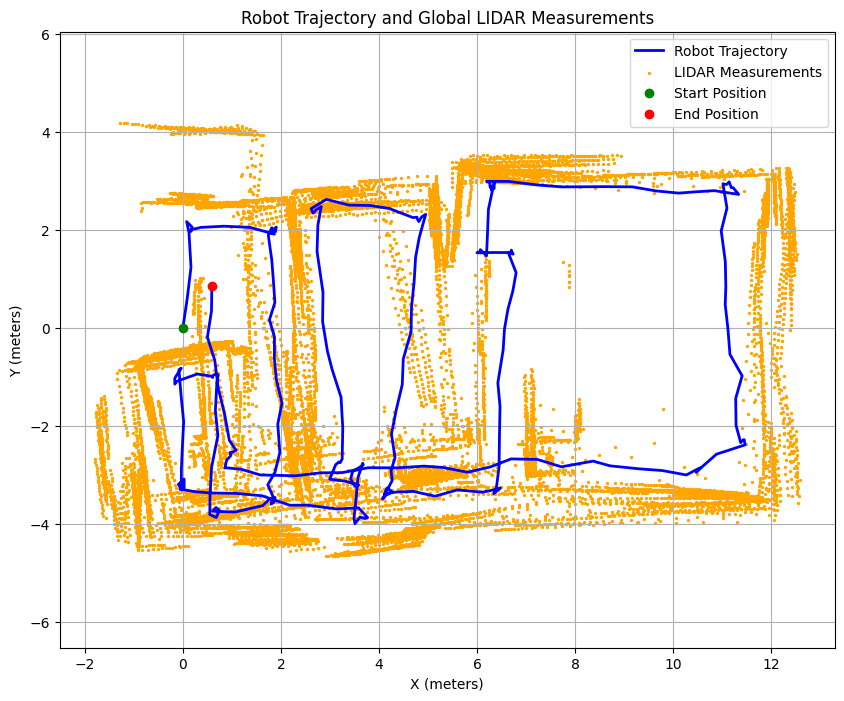

In [107]:
# Função para converter medições LIDAR para coordenadas globais
def lidar_to_global(pose, lidar_distances, angles):
    x_robot, y_robot, theta_robot = pose
    lidar_coords_global = []

    for distance, angle in zip(lidar_distances, angles):
        x_local = distance * np.cos(angle)
        y_local = distance * np.sin(angle)

        rotation_matrix = np.array([
            [np.cos(theta_robot), -np.sin(theta_robot)],
            [np.sin(theta_robot), np.cos(theta_robot)]
        ])

        lidar_local = np.array([x_local, y_local])
        lidar_global = rotation_matrix.dot(lidar_local)
        lidar_global += np.array([x_robot, y_robot])

        lidar_coords_global.append(lidar_global)

    return np.array(lidar_coords_global)

# Inicializar a pose do robô e listas para armazenar a trajetória e medições LIDAR globais
pose = initial_pose
trajectory = [pose]
lidar_global_data = []

# Calcular a trajetória e medições LIDAR globais

for i in range(len(poses)):
    pose = poses[i] # Get the pose from the poses array
    lidar_distances = lidar_data[i] # Get the corresponding lidar data

    trajectory.append(pose)

    lidar_global = lidar_to_global(pose, lidar_distances, angles)
    lidar_global_data.append(lidar_global)

# Converter listas para arrays
trajectory = np.array(trajectory)
lidar_global_data = np.vstack(lidar_global_data)  # Combinar todas as medições LIDAR

# Plotar a trajetória do robô e todas as medições LIDAR globais
plt.figure(figsize=(10, 8))

# Trajetória do robô
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label="Robot Trajectory", linewidth=2)

# Medições LIDAR globais
plt.scatter(lidar_global_data[:, 0], lidar_global_data[:, 1], color='orange', s=2, label="LIDAR Measurements")

# Marcar a posição inicial e final do robô
plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label="Start Position", zorder=5)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', label="End Position", zorder=5)

# Configurações do gráfico
plt.axis("equal")
plt.title("Robot Trajectory and Global LIDAR Measurements")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.grid(True)
plt.show()